# Initialize

## Initialization

In [2]:
import os
import re
import json
import sys
import random
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.stats import norm
from scipy.optimize import minimize, curve_fit, root
tfd=tfp.distributions
import pandas as pd
from timeit import default_timer as timer
from jupyterthemes import jtplot
jtplot.reset()
sys.path.append('../code')
import Bijectors,Distributions,Metrics,MixtureDistributions,Plotters,Trainer,Utils
paper_fig_dir = "../../../NormalizingFlows/papers/NFHD/figures/"
events_dir = "../ZplusJets/events/"
events_file = "../ZplusJets/events/precision_enthusiasts_dataset.h5"
events_dataset = "../ZplusJets/events/events.h5"

## Useful functions

In [3]:
def reset_random_seeds(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [4]:
def MixtureGaussian(ncomp,ndims,seed=0):
    targ_dist = MixtureDistributions.MixMultiNormal1(ncomp,ndims,seed=seed)
    return targ_dist

In [5]:
def build_data_from_runs(path,save_file_name,only_succeeded=True):
    if only_succeeded:
        result_string = "succeeded"
    else:
        result_string = "all"
    print("Processing path", path,"for",result_string,"runs.")
    runs_list=[[int(i.replace("run_","")),os.path.abspath(os.path.join(os.path.join(path,i),"results.txt"))] for i in os.listdir(path) if ("run" in i and os.path.isdir(os.path.abspath(os.path.join(path,i))))]
    runs_list.sort()
    i=0
    j=0
    data=pd.DataFrame()
    for run in runs_list:
        proceed = True
        try:
            if os.path.exists(run[1]):
                print(run[1])
                tmp = pd.read_csv(run[1])#.pop("time")
                if 'nan' in str(tmp) or "failed" in str(tmp):
                    if not only_succeeded:
                        proceed = True
                    else:
                        proceed = False
                else:
                    proceed = True
                if not 'swd_mean' in str(tmp):
                    tmp = recompute_metrics(run[1])
                else:
                    pass
                if proceed:
                    data=pd.concat([data,tmp])
                else:
                    pass
                i=i+1
            else:
                j=j+1
                print("No results available for run",run[0])
        except:
            j=j+1
            print("Failed to import run",run[0])
    data = data.reset_index(drop=True).replace("failed","nan")
    print("Succesfully imported", i, "runs (failed to import",j,"runs).")
    save_path = os.path.abspath(os.path.join(path,save_file_name))
    data.to_csv(save_path,index=False)
    print("Succesfully saved data to file", save_path)
    return data

In [6]:
def recompute_metrics(run):
    print("Recomputing metrics for run",run.replace("results.txt",""),".")
    start_all=timer()
    tmp = pd.read_csv(run)
    with open(run.replace('results.txt','details.json'), 'r') as f:
        tmp_json = json.load(f)
    X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
    np.shape(X_data_nf)
    run_n=int(tmp["run_n"])
    run_seed=int(tmp["run_seed"])
    ndims=int(tmp["ndims"])
    nsamples=int(tmp["nsamples"])
    correlation=str(tmp["correlation"][0])
    nbijectors=int(tmp["nbijectors"])
    bijector=str(tmp["bijector"][0])
    activation=str(tmp["activation"][0])
    spline_knots=int(tmp["spline_knots"])
    range_min=int(tmp["range_min"])
    eps_regulariser=tmp["eps_regulariser"][0]
    regulariser=tmp["regulariser"][0]
    hidden_layers=str(tmp["hidden_layers"][0])
    batch_size=int(tmp["batch_size"])
    epochs_input=int(tmp["epochs_input"])
    epochs_output=int(tmp["epochs_output"])
    dist_seed=int(tmp_json["dist_seed"])
    test_seed=int(tmp_json["test_seed"])
    time=tmp["time"][0]
    train_loss_history=tmp_json["train_loss_history"]
    val_loss_history=tmp_json["val_loss_history"]
    ncomp=3
    ntest_samples=nsamples
    seed_dist = 0
    seed_test = 0
    targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    start=timer()
    ks_mean,ks_std,ks_list,ad_mean,ad_std,ad_list,wd_mean,wd_std,wd_list,swd_mean,swd_std,swd_list,fn_mean,fn_std,fn_list=Metrics.ComputeMetrics(X_data_test,X_data_nf)
    hyperparams_dict = {'run_n': [run_n],
                       'run_seed': [run_seed],
                       'ndims':[ndims],
                       'nsamples':[nsamples],
                       'correlation':[correlation],
                       'nbijectors':[nbijectors],
                       'bijector':[bijector],
                       'spline_knots':[spline_knots],
                       'range_min':[range_min],
                       'hidden_layers':[hidden_layers],
                       'batch_size':[batch_size],
                       'activation':[activation],
                       'eps_regulariser':[eps_regulariser],
                       'regulariser':[regulariser],
                       'dist_seed':[dist_seed],
                       'test_seed':[test_seed]}
    results_dict = {'run_n': [run_n],
                    'run_seed': [run_seed],
                    'ndims':[ndims],
                    'nsamples':[nsamples],
                    'correlation':[correlation],
                    'nbijectors':[nbijectors],
                    'bijector':[bijector],
                    'activation':[activation],
                    'spline_knots':[spline_knots],
                    'range_min':[range_min],
                    'eps_regulariser':[eps_regulariser],
                    'regulariser':[regulariser],
                    'ks_mean':[ks_mean],
                    'ks_std':[ks_std],
                    'ks_list':[ks_list],
                    'ad_mean':[ad_mean],
                    'ad_std':[ad_std],
                    'ad_list':[ad_list],
                    'wd_mean':[wd_mean],
                    'wd_std':[wd_std],
                    'wd_list':[wd_list],
                    'swd_mean':[swd_mean],
                    'swd_std':[swd_std],
                    'swd_list':[swd_list],
                    'fn_mean':[fn_mean],
                    'fn_std':[fn_std],
                    'fn_list':[fn_list],
                    'hidden_layers':[hidden_layers],
                    'batch_size':[batch_size],
                    'epochs_input':[epochs_input],
                    'epochs_output':[epochs_output],
                    'time':[time]}
    #os.rename(run, run.replace(".txt","_old.txt"))
    os.rename(run.replace('results.txt','details.json'), run.replace('results.txt','details_bkp.json'))
    Utils.results_current(run.replace("results.txt",""),results_dict)
    Utils.save_details_json(hyperparams_dict,results_dict,train_loss_history,val_loss_history,run.replace("results.txt",""))
    tmp_new = pd.read_csv(run)
    tmp_new['ks_list'] = None
    tmp_new['ad_list'] = None
    tmp_new['wd_list'] = None
    tmp_new['swd_list'] = None
    tmp_new['fn_list'] = None
    tmp_new.at[0, 'ks_list'] = ks_list
    tmp_new.at[0, 'ad_list'] = ad_list
    tmp_new.at[0, 'wd_list'] = wd_list
    tmp_new.at[0, 'swd_list'] = swd_list
    tmp_new.at[0, 'fn_list'] = fn_list
    end=timer()
    print("Metrics for run",run.replace("results.txt",""),"computed and saved in",end-start,"s.")
    return tmp_new

In [7]:
#run = r"/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_1/results.txt"
#tmp = recompute_metrics(run)
#tmp

In [8]:
def extract_lines(df_bests,bij,corr,metric,replicas=False):
    result = []
    for df in df_bests:
        if replicas:
            tmp = df[df["correlation"]==corr][df["bijector"]==bij][["ndims",metric+"_mean",metric+"_std","run_n"]].to_numpy().flatten().tolist()
        else:
            tmp = df[df["correlation"]==corr][df["bijector"]==bij][["ndims",metric,metric.replace("mean","std"),"run_n"]].to_numpy().flatten().tolist()
        if tmp != []:
            result.append(tmp)
    return np.array(result)

In [9]:
def transform_string_1(input_string):
    # Regular expression to find parts like '& $2.42e-02\pm 1.00e-02$'
    matches = re.findall(r"(& \$(\d+\.\d+)(e-\d+)\\pm (\d+\.\d+)(e-\d+)\$)", input_string)

    # If we found matches
    if matches:
        for match in matches:
            # Check if exponents are the same
            if match[2] == match[4]:
                # Now move e-XX at end after $
                new_format = "{} $({}\\pm {}{}".format(match[0].split('$')[0], match[1], match[3], match[2])
                # Replace the original match with the new format
                input_string = input_string.replace(match[0], new_format)
            
    return input_string

In [10]:
def dataframe_highlight_min(s):
    '''
    highlight the minimum in a Series yellow.
    '''
    is_min = s == s.min()
    return ['background-color: red' if v else '' for v in is_min]

def dataframe_highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: red' if v else '' for v in is_max]

In [11]:
import re
def align_table_latex(table_str):
    lines = table_str.split('\n')
    aligned_lines = []
    max_counts = []
    # Pass 1: find the max index of each & position in all lines
    for line in lines:
        if not line.strip() or line.strip().startswith('%'):
            # Skip empty lines and lines starting with %
            aligned_lines.append((line, []))
            continue
        # Get the list of the positions of & in the current line
        counts = [m.start() for m in re.finditer('&', line)]
        # Extend max_counts if needed
        if len(counts) > len(max_counts):
            max_counts.extend([0] * (len(counts) - len(max_counts)))
        # Update the max index for each position
        for i, count in enumerate(counts):
            max_counts[i] = max(max_counts[i], count)
        aligned_lines.append((line, counts))
    # Pass 2: pad spaces to align & to the max positions
    for i in range(len(aligned_lines)):
        line, counts = aligned_lines[i]
        if counts:
            for j in reversed(range(len(counts))):
                line = line[:counts[j]] + ' ' * (max_counts[j] - counts[j]) + line[counts[j]:]
        aligned_lines[i] = line
    return '\n'.join(aligned_lines)

In [12]:
from math import log10, floor
def round_number(num,n=2):
    if num == 0:
        return 0
    digit_count = int(floor(log10(abs(num))))
    return round(num, -digit_count + n-1)
# Examples
#print(round_number(1234.567, 2))  # prints: "1200.0"
#print(round_number(12345.67, 2))  # prints: "12000.0"
#print(round_number(0.1234567, 2))  # prints: "0.12"

In [13]:
def format_number(num, n=4):
    if abs(num) >= 1:
        if len(str(int(num))) > n:  # If the integer part has more than n digits
            return "{:.2e}".format(num)
        else:
            return str(round(num))
    else:
        # For numbers less than 1
        if abs(num) < 10**-(n-1):
            return "{:.2e}".format(num)
        else:
            return ("{:.%df}" % (n - 1)).format(num).rstrip('0').rstrip('.')  # Remove trailing zeros

# Examples
#print(format_number(1234.567, 4))  # prints: "1235"
#print(format_number(12345.67, 4))  # prints: "1.23e+04"
#print(format_number(0.1234567, 4))  # prints: "0.123"
#print(format_number(0.0003, 4))  # prints: "3.00e-04"

In [14]:
def move_columns(df, cols_to_move, ref_col):
    """
    Move a list of columns to right after a specific column in dataframe.

    Parameters:
    df (pd.DataFrame): The original dataframe
    cols_to_move (list of str): List of columns to move
    ref_col (str): The column to move the other columns after
    
    Returns:
    pd.DataFrame: A dataframe with re-ordered columns
    """
    other_cols = [c for c in df.columns if c not in cols_to_move]
    
    start_cols = other_cols[:list(df.columns).index(ref_col) + 1]
    end_cols = [e for e in other_cols if e not in start_cols]
    
    return df[start_cols + cols_to_move + end_cols]

## Load and check events

In [3]:
import pandas as pd
df = pd.read_hdf(events_file, 'events')  # 'key' corresponds to the key you used when writing the file.
df = df.rename(columns={0: 'E_mu1',
                        1: 'px_mu1',
                        2: 'py_mu1',
                        3: 'pz_mu1',
                        4: 'E_mu2',
                        5: 'px_mu2',
                        6: 'py_mu2',
                        7: 'pz_mu2',
                        8: 'E_j1',
                        9: 'px_j1',
                        10: 'py_j1',
                        11: 'pz_j1',
                        12: 'E_j2',
                        13: 'px_j2',
                        14: 'py_j2',
                        15: 'pz_j2',
                        16: 'E_j3',
                        17: 'px_j3',
                        18: 'py_j3',
                        19: 'pz_j3'})
print("Imported",len(df),"events of Z+1,2,3j.")
df["E_cm"]=df["E_mu1"]+df["E_mu2"]+df["E_j1"]+df["E_j2"]+df["E_j3"]
df["px_cm"]=df["px_mu1"]+df["px_mu2"]+df["px_j1"]+df["px_j2"]+df["px_j3"]
df["py_cm"]=df["py_mu1"]+df["py_mu2"]+df["py_j1"]+df["py_j2"]+df["py_j3"]
df["pz_cm"]=df["pz_mu1"]+df["pz_mu2"]+df["pz_j1"]+df["pz_j2"]+df["pz_j3"]
df["M_inv"]=np.sqrt(df["E_cm"]**2-df["px_cm"]**2-df["py_cm"]**2-df["pz_cm"]**2)
#df_0 = df[(df['E_j1'] == 0) & (df['E_j2'] == 0) & (df['E_j3'] == 0)].copy()
df1 = df[(df['E_j1'] != 0) & (df['E_j2'] == 0) & (df['E_j3'] == 0)].copy()
df2 = df[(df['E_j1'] != 0) & (df['E_j2'] != 0) & (df['E_j3'] == 0)].copy()
df3 = df[(df['E_j1'] != 0) & (df['E_j2'] != 0) & (df['E_j3'] != 0)].copy()
print("There are",[len(df_1),len(df_2),len(df_3)],"events of [Z+1j,Z+2j,Z+3j]. They have been split in three datasets.")

Imported 5413184 events of Z+1,2,3j.


NameError: name 'df_1' is not defined

### Check 4-momentum conservation

In [165]:
muon1 = df[['E_mu1','px_mu1','py_mu1','pz_mu1']]
muon1['M']=None
muon1['M'] = np.sqrt(np.abs(df['E_mu1']**2-df['px_mu1']**2-df['py_mu1']**2-df['pz_mu1']**2))
len(muon1[muon1['M'] > muon1['E_mu1']/1000])
#np.all(muon1[:,0]**2-muon1[:,1]**2-muon1[:,2]**2-muon1[:,3]**2 < np.abs(np.min(muon1,axis=1)))

/tmp/ipykernel_327/49440600.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muon1['M']=None
/tmp/ipykernel_327/49440600.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muon1['M'] = np.sqrt(np.abs(df['E_mu1']**2-df['px_mu1']**2-df['py_mu1']**2-df['pz_mu1']**2))


0

In [110]:
muon2 = df[['E_mu2','px_mu2','py_mu2','pz_mu2']]
muon2['M']=None
muon2['M'] = np.sqrt(np.abs(df['E_mu2']**2-df['px_mu2']**2-df['py_mu2']**2-df['pz_mu2']**2))
len(muon2[muon2['M'] > muon2['E_mu2']/1000])

/tmp/ipykernel_327/3218335206.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muon2['M']=None
/tmp/ipykernel_327/3218335206.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muon2['M'] = np.sqrt(np.abs(df['E_mu2']**2-df['px_mu2']**2-df['py_mu2']**2-df['pz_mu2']**2))


0

In [114]:
j1 = df[['E_j1','px_j1','py_j1','pz_j1']]
j1['M']=None
j1['M'] = np.sqrt(np.abs(df['E_j1']**2-df['px_j1']**2-df['py_j1']**2-df['pz_j1']**2))
display(j1)
len(j1[j1['M'] > j1['E_j1']/2])

/tmp/ipykernel_327/3343528594.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  j1['M']=None
/tmp/ipykernel_327/3343528594.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  j1['M'] = np.sqrt(np.abs(df['E_j1']**2-df['px_j1']**2-df['py_j1']**2-df['pz_j1']**2))


E_j1      px_j1      py_j1       pz_j1         M
0      291.573975 -18.831652  27.458097  289.632385  4.459015
1       68.249321 -12.231569  30.145758  -59.624374  6.672771
2      112.327835   1.140762  22.940464  109.894241  3.637640
3      128.559647  35.689987  18.428099 -122.068893  3.660254
4       22.983244  22.762995  -2.040888   -1.300486  2.054039
...           ...        ...        ...         ...       ...
55743  132.806595  11.260182  17.994991 -130.944427  6.366876
55744  178.490723  65.027649  33.441177 -162.789230  3.419841
55745   42.084568 -13.071302 -32.244484  -23.080492  5.275989
55746   73.153984   3.890539  37.378010   62.400257  6.742509
55747  157.042862  36.077332   3.305644 -152.772339  3.251502

[5413184 rows x 5 columns]

0

In [115]:
j2 = df[['E_j2','px_j2','py_j2','pz_j2']]
j2['M']=None
j2['M'] = np.sqrt(np.abs(df['E_j2']**2-df['px_j2']**2-df['py_j2']**2-df['pz_j2']**2))
display(j2)
len(j2[j2['M'] > j2['E_j2']/2])

/tmp/ipykernel_327/1455975127.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  j2['M']=None
/tmp/ipykernel_327/1455975127.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  j2['M'] = np.sqrt(np.abs(df['E_j2']**2-df['px_j2']**2-df['py_j2']**2-df['pz_j2']**2))


E_j2      px_j2      py_j2       pz_j2         M
0        0.000000   0.000000   0.000000    0.000000  0.000000
1       31.572071 -17.839846 -23.196199  -11.319241  3.513780
2        0.000000   0.000000   0.000000    0.000000  0.000000
3      147.305573 -24.116796   2.873557  145.220261  4.486742
4        0.000000   0.000000   0.000000    0.000000  0.000000
...           ...        ...        ...         ...       ...
55743    0.000000   0.000000   0.000000    0.000000  0.000000
55744  240.299057 -26.954819   8.165919 -238.639908  1.177590
55745    0.000000   0.000000   0.000000    0.000000  0.000000
55746  298.785400   2.274149 -27.451210 -297.479584  4.458138
55747    0.000000   0.000000   0.000000    0.000000  0.000000

[5413184 rows x 5 columns]

0

In [116]:
j3 = df[['E_j3','px_j3','py_j3','pz_j3']]
j3['M']=None
j3['M'] = np.sqrt(np.abs(df['E_j3']**2-df['px_j3']**2-df['py_j3']**2-df['pz_j3']**2))
display(j3)
len(j3[j3['M'] > j3['E_j3']/2])

/tmp/ipykernel_327/86679044.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  j3['M']=None
/tmp/ipykernel_327/86679044.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  j3['M'] = np.sqrt(np.abs(df['E_j3']**2-df['px_j3']**2-df['py_j3']**2-df['pz_j3']**2))


E_j3      px_j3      py_j3       pz_j3         M
0        0.000000   0.000000   0.000000    0.000000  0.000000
1        0.000000   0.000000   0.000000    0.000000  0.000000
2        0.000000   0.000000   0.000000    0.000000  0.000000
3        0.000000   0.000000   0.000000    0.000000  0.000000
4        0.000000   0.000000   0.000000    0.000000  0.000000
...           ...        ...        ...         ...       ...
55743    0.000000   0.000000   0.000000    0.000000  0.000000
55744    0.000000   0.000000   0.000000    0.000000  0.000000
55745    0.000000   0.000000   0.000000    0.000000  0.000000
55746  108.968117  19.168037  10.982712 -106.652573  3.353374
55747    0.000000   0.000000   0.000000    0.000000  0.000000

[5413184 rows x 5 columns]

0

### Plots

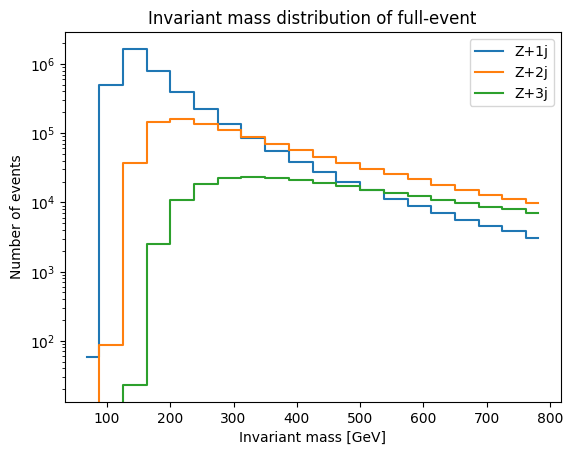

In [166]:
scale = 'log'
min_mass = 50  # lower limit of the binning
max_mass = 800  # upper limit of the binning
num_bins = 20  # number of bins

# Create histogram values but do not plot it
counts1, bin_edges = np.histogram(df_1["M_inv"], bins=np.linspace(min_mass, max_mass, num_bins + 1))
counts2, _ = np.histogram(df_2["M_inv"], bins=np.linspace(min_mass, max_mass, num_bins + 1))
counts3, _ = np.histogram(df_3["M_inv"], bins=np.linspace(min_mass, max_mass, num_bins + 1))

# Get the bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Draw the plot
plt.plot(bin_centers, counts1, '-',label='Z+1j', drawstyle='steps-mid')
plt.plot(bin_centers, counts2, '-',label='Z+2j', drawstyle='steps-mid')
plt.plot(bin_centers, counts3, '-',label='Z+3j', drawstyle='steps-mid')
plt.yscale(scale)
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Number of events')
plt.title('Invariant mass distribution of full-event')
plt.legend()
plt.show()

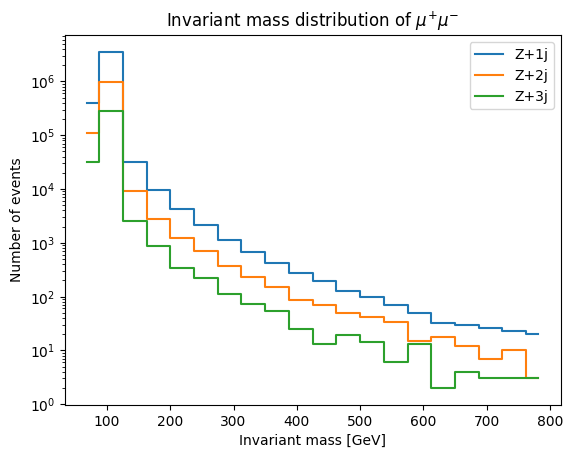

In [167]:
scale = 'log'
min_mass = 50  # lower limit of the binning
max_mass = 800  # upper limit of the binning
num_bins = 20  # number of bins

E_1=df1["E_mu1"]+df1["E_mu2"]
px_1=df1["px_mu1"]+df1["px_mu2"]
py_1=df1["py_mu1"]+df1["py_mu2"]
pz_1=df1["pz_mu1"]+df1["pz_mu2"]
M_inv_1=np.sqrt(E_1**2-px_1**2-py_1**2-pz_1**2)

E_2=df2["E_mu1"]+df2["E_mu2"]
px_2=df2["px_mu1"]+df2["px_mu2"]
py_2=df2["py_mu1"]+df2["py_mu2"]
pz_2=df2["pz_mu1"]+df2["pz_mu2"]
M_inv_2=np.sqrt(E_2**2-px_2**2-py_2**2-pz_2**2)

E_3=df3["E_mu1"]+df3["E_mu2"]
px_3=df3["px_mu1"]+df3["px_mu2"]
py_3=df3["py_mu1"]+df3["py_mu2"]
pz_3=df3["pz_mu1"]+df3["pz_mu2"]
M_inv_3=np.sqrt(E_3**2-px_3**2-py_3**2-pz_3**2)

# Create histogram values but do not plot it
counts1, bin_edges = np.histogram(M_inv_1, bins=np.linspace(min_mass, max_mass, num_bins + 1))
counts2, _ = np.histogram(M_inv_2, bins=np.linspace(min_mass, max_mass, num_bins + 1))
counts3, _ = np.histogram(M_inv_3, bins=np.linspace(min_mass, max_mass, num_bins + 1))

# Get the bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Draw the plot
plt.plot(bin_centers, counts1, '-',label='Z+1j', drawstyle='steps-mid')
plt.plot(bin_centers, counts2, '-',label='Z+2j', drawstyle='steps-mid')
plt.plot(bin_centers, counts3, '-',label='Z+3j', drawstyle='steps-mid')
plt.yscale(scale)
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Number of events')
plt.title('Invariant mass distribution of $\mu^{+}\mu^{-}$')
plt.legend()
plt.show()

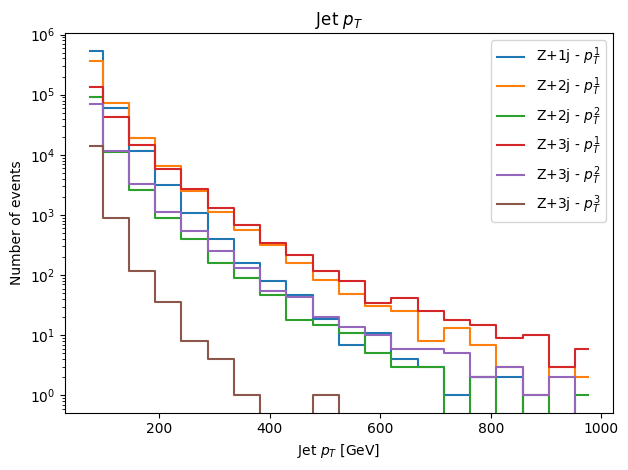

In [172]:
scale = 'log'
min_mass = 50  # lower limit of the binning
max_mass = 1000  # upper limit of the binning
num_bins = 20  # number of bins

pt1_1=np.sqrt(df1["px_j1"]**2+df1["py_j1"]**2)
pt2_1=np.sqrt(df2["px_j1"]**2+df2["py_j1"]**2)
pt2_2=np.sqrt(df2["px_j2"]**2+df2["py_j2"]**2)
pt3_1=np.sqrt(df3["px_j1"]**2+df3["py_j1"]**2)
pt3_2=np.sqrt(df3["px_j2"]**2+df3["py_j2"]**2)
pt3_3=np.sqrt(df3["px_j3"]**2+df3["py_j3"]**2)

# Create histogram values but do not plot it
counts1_1, _ = np.histogram(pt1_1, bins=np.linspace(min_mass, max_mass, num_bins + 1))
counts2_1, _ = np.histogram(pt2_1, bins=np.linspace(min_mass, max_mass, num_bins + 1))
counts2_2, _ = np.histogram(pt2_2, bins=np.linspace(min_mass, max_mass, num_bins + 1))
counts3_1, _ = np.histogram(pt3_1, bins=np.linspace(min_mass, max_mass, num_bins + 1))
counts3_2, _ = np.histogram(pt3_2, bins=np.linspace(min_mass, max_mass, num_bins + 1))
counts3_3, bin_edges = np.histogram(pt3_3, bins=np.linspace(min_mass, max_mass, num_bins + 1))

# Get the bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Draw the plot
plt.plot(bin_centers, counts1_1, '-',label='Z+1j - $p_{T}^{1}$', drawstyle='steps-mid')
plt.plot(bin_centers, counts2_1, '-',label='Z+2j - $p_{T}^{1}$', drawstyle='steps-mid')
plt.plot(bin_centers, counts2_2, '-',label='Z+2j - $p_{T}^{2}$', drawstyle='steps-mid')
plt.plot(bin_centers, counts3_1, '-',label='Z+3j - $p_{T}^{1}$', drawstyle='steps-mid')
plt.plot(bin_centers, counts3_2, '-',label='Z+3j - $p_{T}^{2}$', drawstyle='steps-mid')
plt.plot(bin_centers, counts3_3, '-',label='Z+3j - $p_{T}^{3}$', drawstyle='steps-mid')
plt.yscale(scale)
plt.xlabel('Jet $p_{T}$ [GeV]')
plt.ylabel('Number of events')
plt.title('Jet $p_{T}$')
plt.legend()
plt.tight_layout()
plt.show()

### Define datasets

In [48]:
try:
    df1 = df1.drop(['E_j2', 'px_j2', 'py_j2', 'pz_j2', 
                    'E_j3', 'px_j3', 'py_j3', 'pz_j3',
                    'E_cm', 'px_cm', 'py_cm', 'pz_cm','M_inv'], axis=1)
except:
    pass
try:
    df2 = df2.drop(['E_j3', 'px_j3', 'py_j3', 'pz_j3',
                    'E_cm', 'px_cm', 'py_cm', 'pz_cm','M_inv'], axis=1)
except:
    pass
try:
    df3 = df3.drop(['E_cm', 'px_cm', 'py_cm', 'pz_cm','M_inv'], axis=1)
except:
    pass
print("Datasets have shapes",[df1.shape,df2.shape,df3.shape],".")
print("Converting datasets to Numpy")
np1 = df1.to_numpy()
np2 = df2.to_numpy()
np3 = df3.to_numpy()
print("Saving datasets to file",events_dataset)
with h5py.File(events_dataset, 'w') as hdf:
    # Save the datasets into the file with unique names
    hdf.create_dataset('Z+1j', data=np1)
    hdf.create_dataset('Z+2j', data=np2)
    hdf.create_dataset('Z+3j', data=np3)

Datasets have shapes [(3987098, 12), (1110182, 16), (315904, 20)] .
Converting datasets to Numpy
Saving datasets to file ../ZplusJets/events/events.h5


In [49]:
events_dataset_path = "../ZplusJets/events/events.h5"

In [50]:
with h5py.File(events_dataset, 'r') as hdf:
    # Save the datasets into the file with unique names
    events = hdf['Z+1j'][:]

In [44]:
events

array([[  61.906208 ,   47.608257 ,  -10.776188 , ...,  -18.831652 ,
          27.458097 ,  289.6324   ],
       [  57.087345 ,    7.814155 ,  -51.43132  , ...,    1.1407624,
          22.940464 ,  109.89424  ],
       [ 603.49     ,   36.73659  ,  -12.078647 , ...,   22.762995 ,
          -2.0408876,   -1.3004861],
       ...,
       [ 112.52366  ,   24.635101 ,  -41.604565 , ...,   11.260182 ,
          17.994991 , -130.94443  ],
       [ 314.569    ,    9.959286 ,   69.94163  , ...,  -13.071302 ,
         -32.244484 ,  -23.080492 ],
       [ 114.3734   ,  -46.684956 ,   14.508317 , ...,   36.07733  ,
           3.305644 , -152.77234  ]], dtype=float32)

In [51]:
X_data_train = events[:nsamples]

In [36]:
X_data_train = np.concatenate([events[:nsamples,i:i+3] for i in range(1, len(events[0]), 4)])

In [41]:
nsamples=100000
#X_data_train = events[:nsamples,1::3]
X_data_train = np.concatenate([events[:nsamples,i:i+3] for i in range(1, len(events[0]), 4)],axis=1)
mean = X_data_train.mean(axis=0)
std = X_data_train.std(axis=0)
X_data_train_std = (X_data_train - mean) / std
X_data_train_std

array([[ 1.0665622 , -0.23791106, -0.08094089, ..., -0.64648056,
         0.92785245,  1.1443974 ],
       [ 0.17789881, -1.1471243 , -0.05067232, ...,  0.03183496,
         0.77463955,  0.43494526],
       [ 0.8237812 , -0.26703933, -1.2533977 , ...,  0.76618266,
        -0.0725887 , -0.00395623],
       ...,
       [-1.2828187 , -0.12128814,  0.63552   , ...,  3.2950537 ,
        -0.8842407 , -0.6393789 ],
       [-0.98983854,  1.259915  ,  0.55608296, ...,  0.00704609,
        -1.2973218 , -0.04632529],
       [-1.2540814 ,  0.3043262 , -0.77004725, ...,  0.5228074 ,
        -0.8902129 , -0.08950322]], dtype=float32)

In [45]:
import matplotlib.lines as mlines
import corner
def cornerplotter(target_test_data,nf_dist,max_dim=32):
    # Define the two samples (target and nf)
    shape = target_test_data.shape
    target_samples=target_test_data
    nf_samples=nf_dist
    ndims = shape[1]
    # Check/remove nans
    nf_samples_no_nans = nf_samples[~np.isnan(nf_samples).any(axis=1), :]
    if len(nf_samples) != len(nf_samples_no_nans):
        print("Samples containing nan have been removed. The fraction of nans over the total samples was:", str((len(nf_samples)-len(nf_samples_no_nans))/len(nf_samples)),".")
    else:
        pass
    nf_samples = nf_samples_no_nans[:shape[0]]
    # Define generic labels
    labels = []
    for i in range(shape[1]):
        labels.append(r"$\theta_{%d}$" % i)
        i = i+1
    # Choose dimensions to plot
    thin = int(shape[1]/max_dim)+1
    if thin<=2:
        thin = 1
    # Select samples to plot
    target_samples = target_samples[:,::thin]
    nf_samples = nf_samples[:,::thin]
    # Select labels
    labels = list(np.array(labels)[::thin])

    n_bins = 50
    #red_bins=50
    #density=(np.max(target_samples,axis=0)-np.min(target_samples,axis=0))/red_bins
    #
    #blue_bins=(np.max(nf_samples,axis=0)-np.min(nf_samples,axis=0))/density
    #blue_bins=blue_bins.astype(int).tolist()

    #file = open(path_to_plots+'/samples.pkl', 'wb')
    #pkl.dump(np.array(target_samples), file, protocol=4)
    #pkl.dump(np.array(nf_samples), file, protocol=4)
    #file.close()

    blue_line = mlines.Line2D([], [], color='red', label='target')
    red_line = mlines.Line2D([], [], color='blue', label='NF')
    figure=corner.corner(target_samples,color='red',bins=n_bins,labels=[r"%s" % s for s in labels])
    corner.corner(nf_samples,color='blue',bins=n_bins,fig=figure)
    plt.legend(handles=[blue_line,red_line], bbox_to_anchor=(-ndims+1.8, ndims+.3, 1., 0.) ,fontsize='xx-large')
    #plt.savefig(path_to_plots+'/corner_plot.pdf',dpi=300)#pil_kwargs={'quality':50})
    plt.show()
    plt.close()
    return

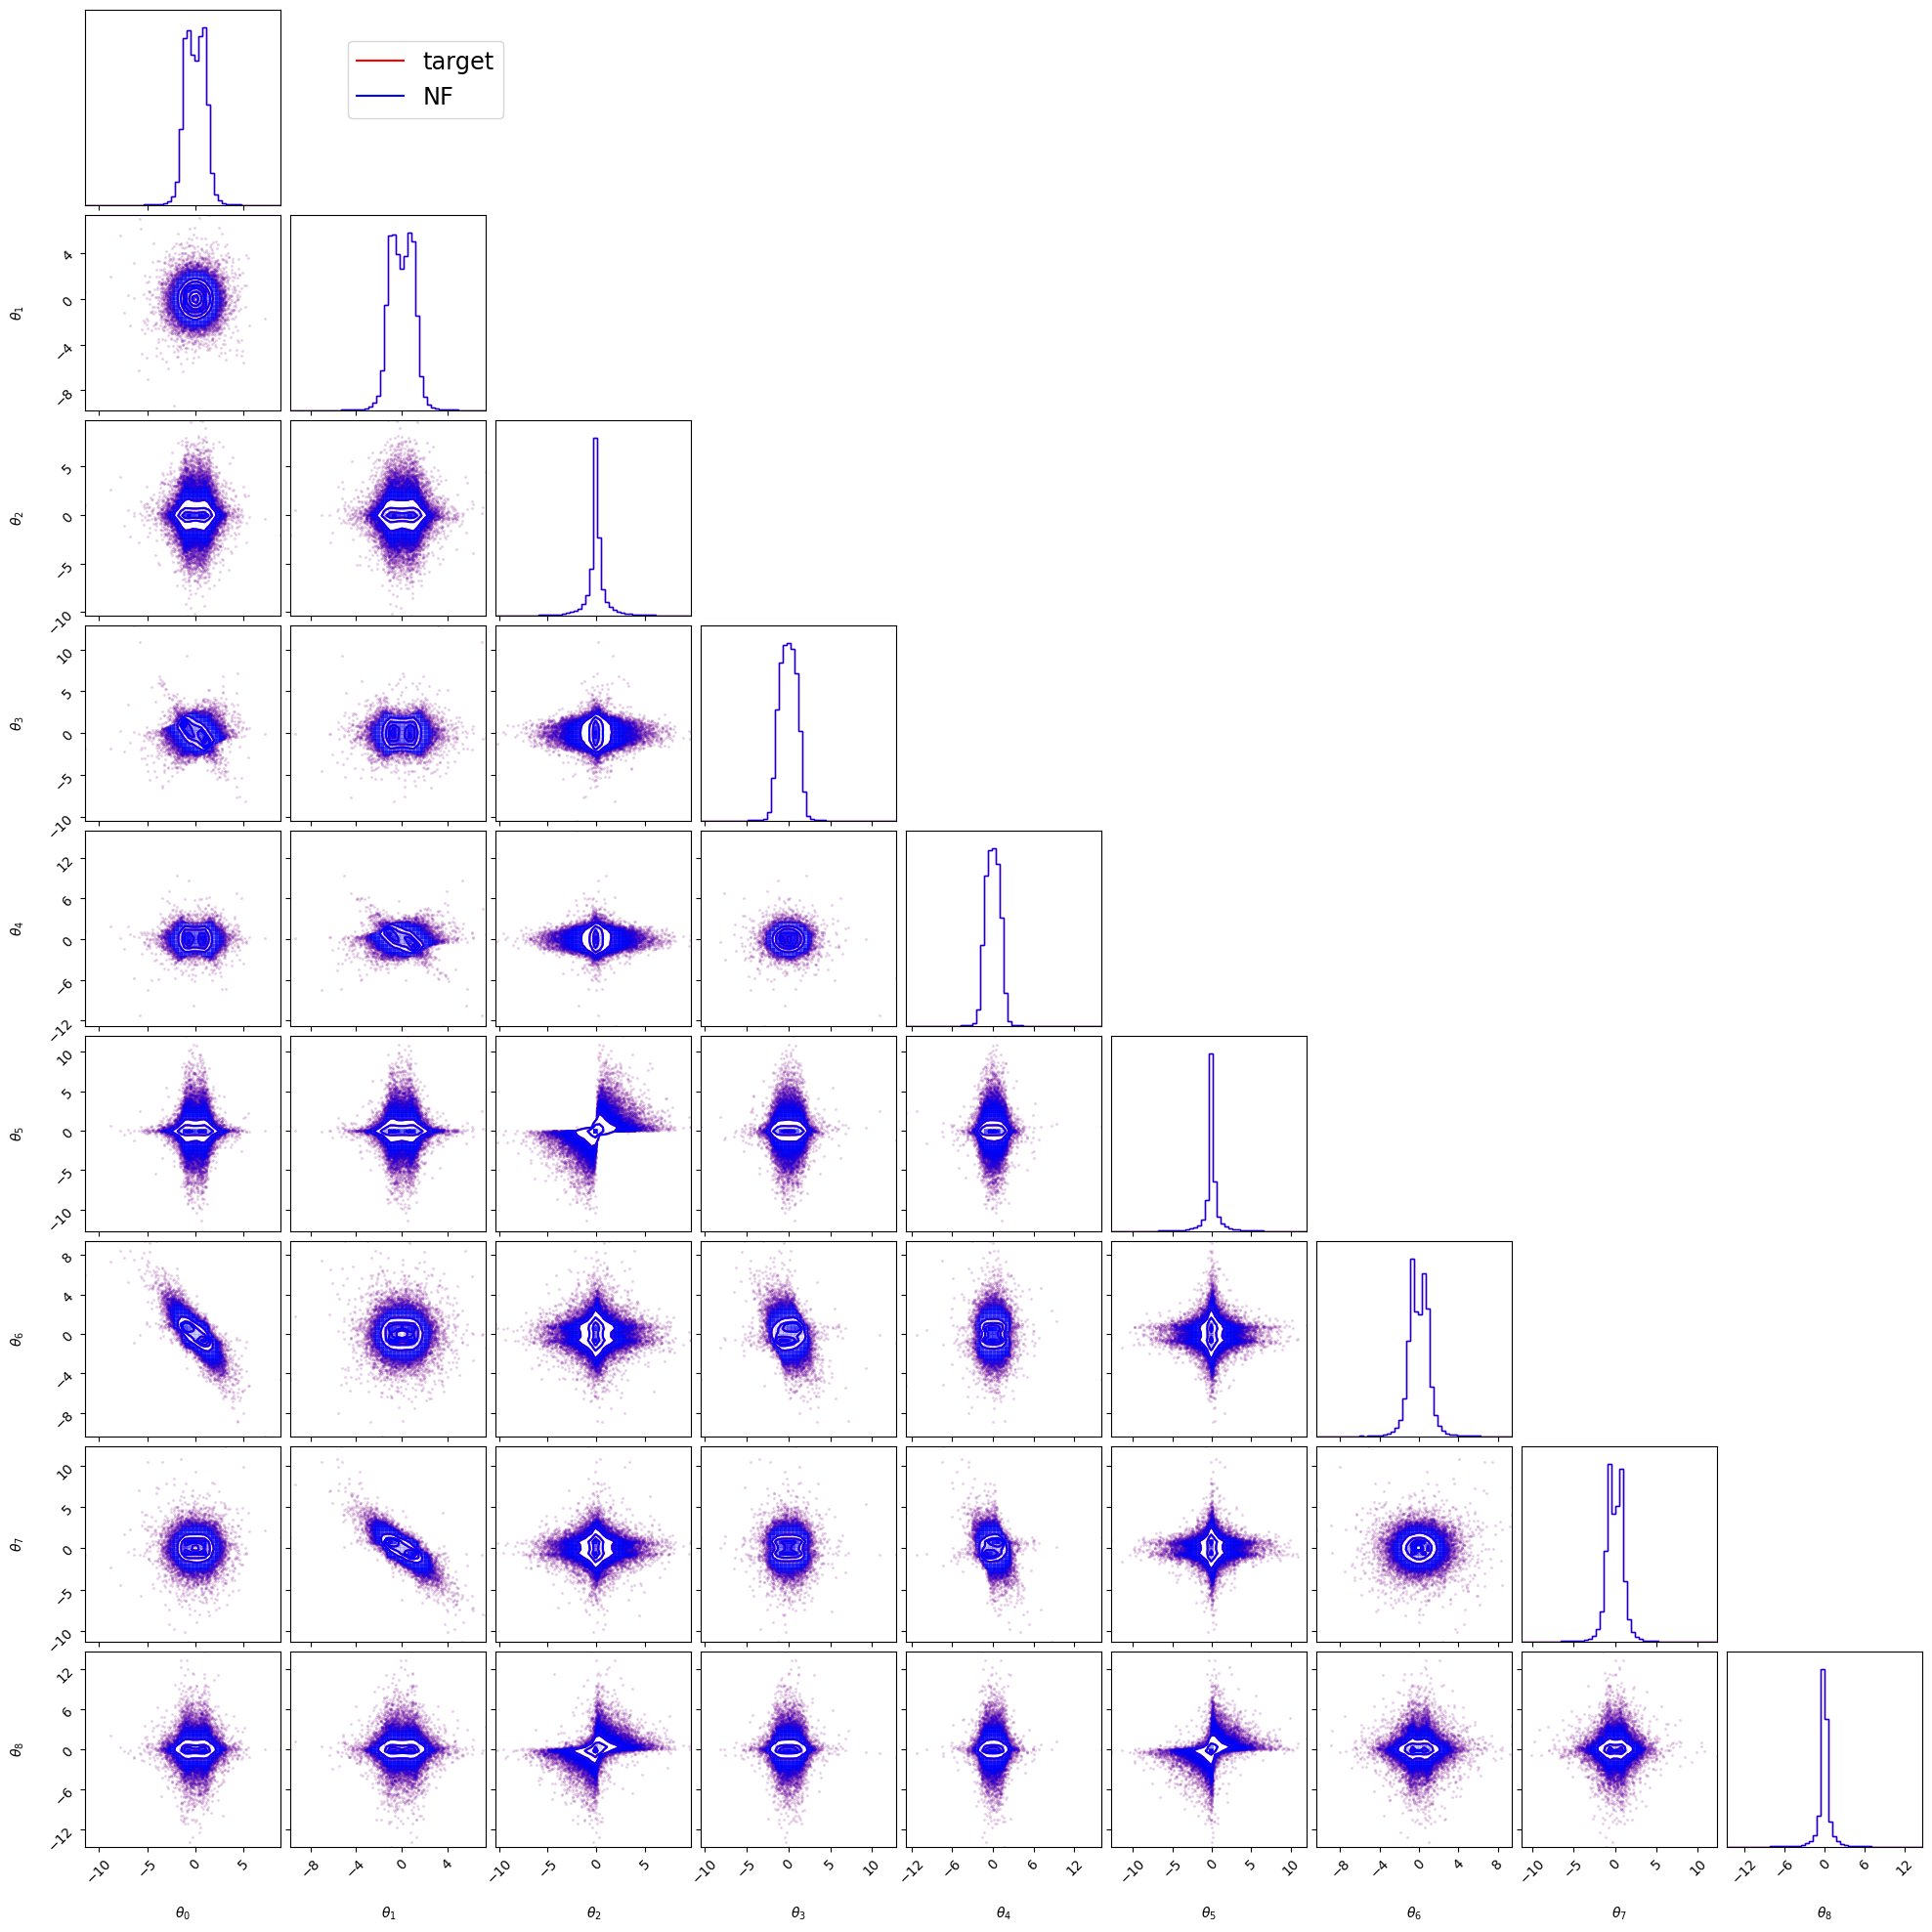

In [43]:
cornerplotter(X_data_train_std,X_data_train_std,max_dim=32)

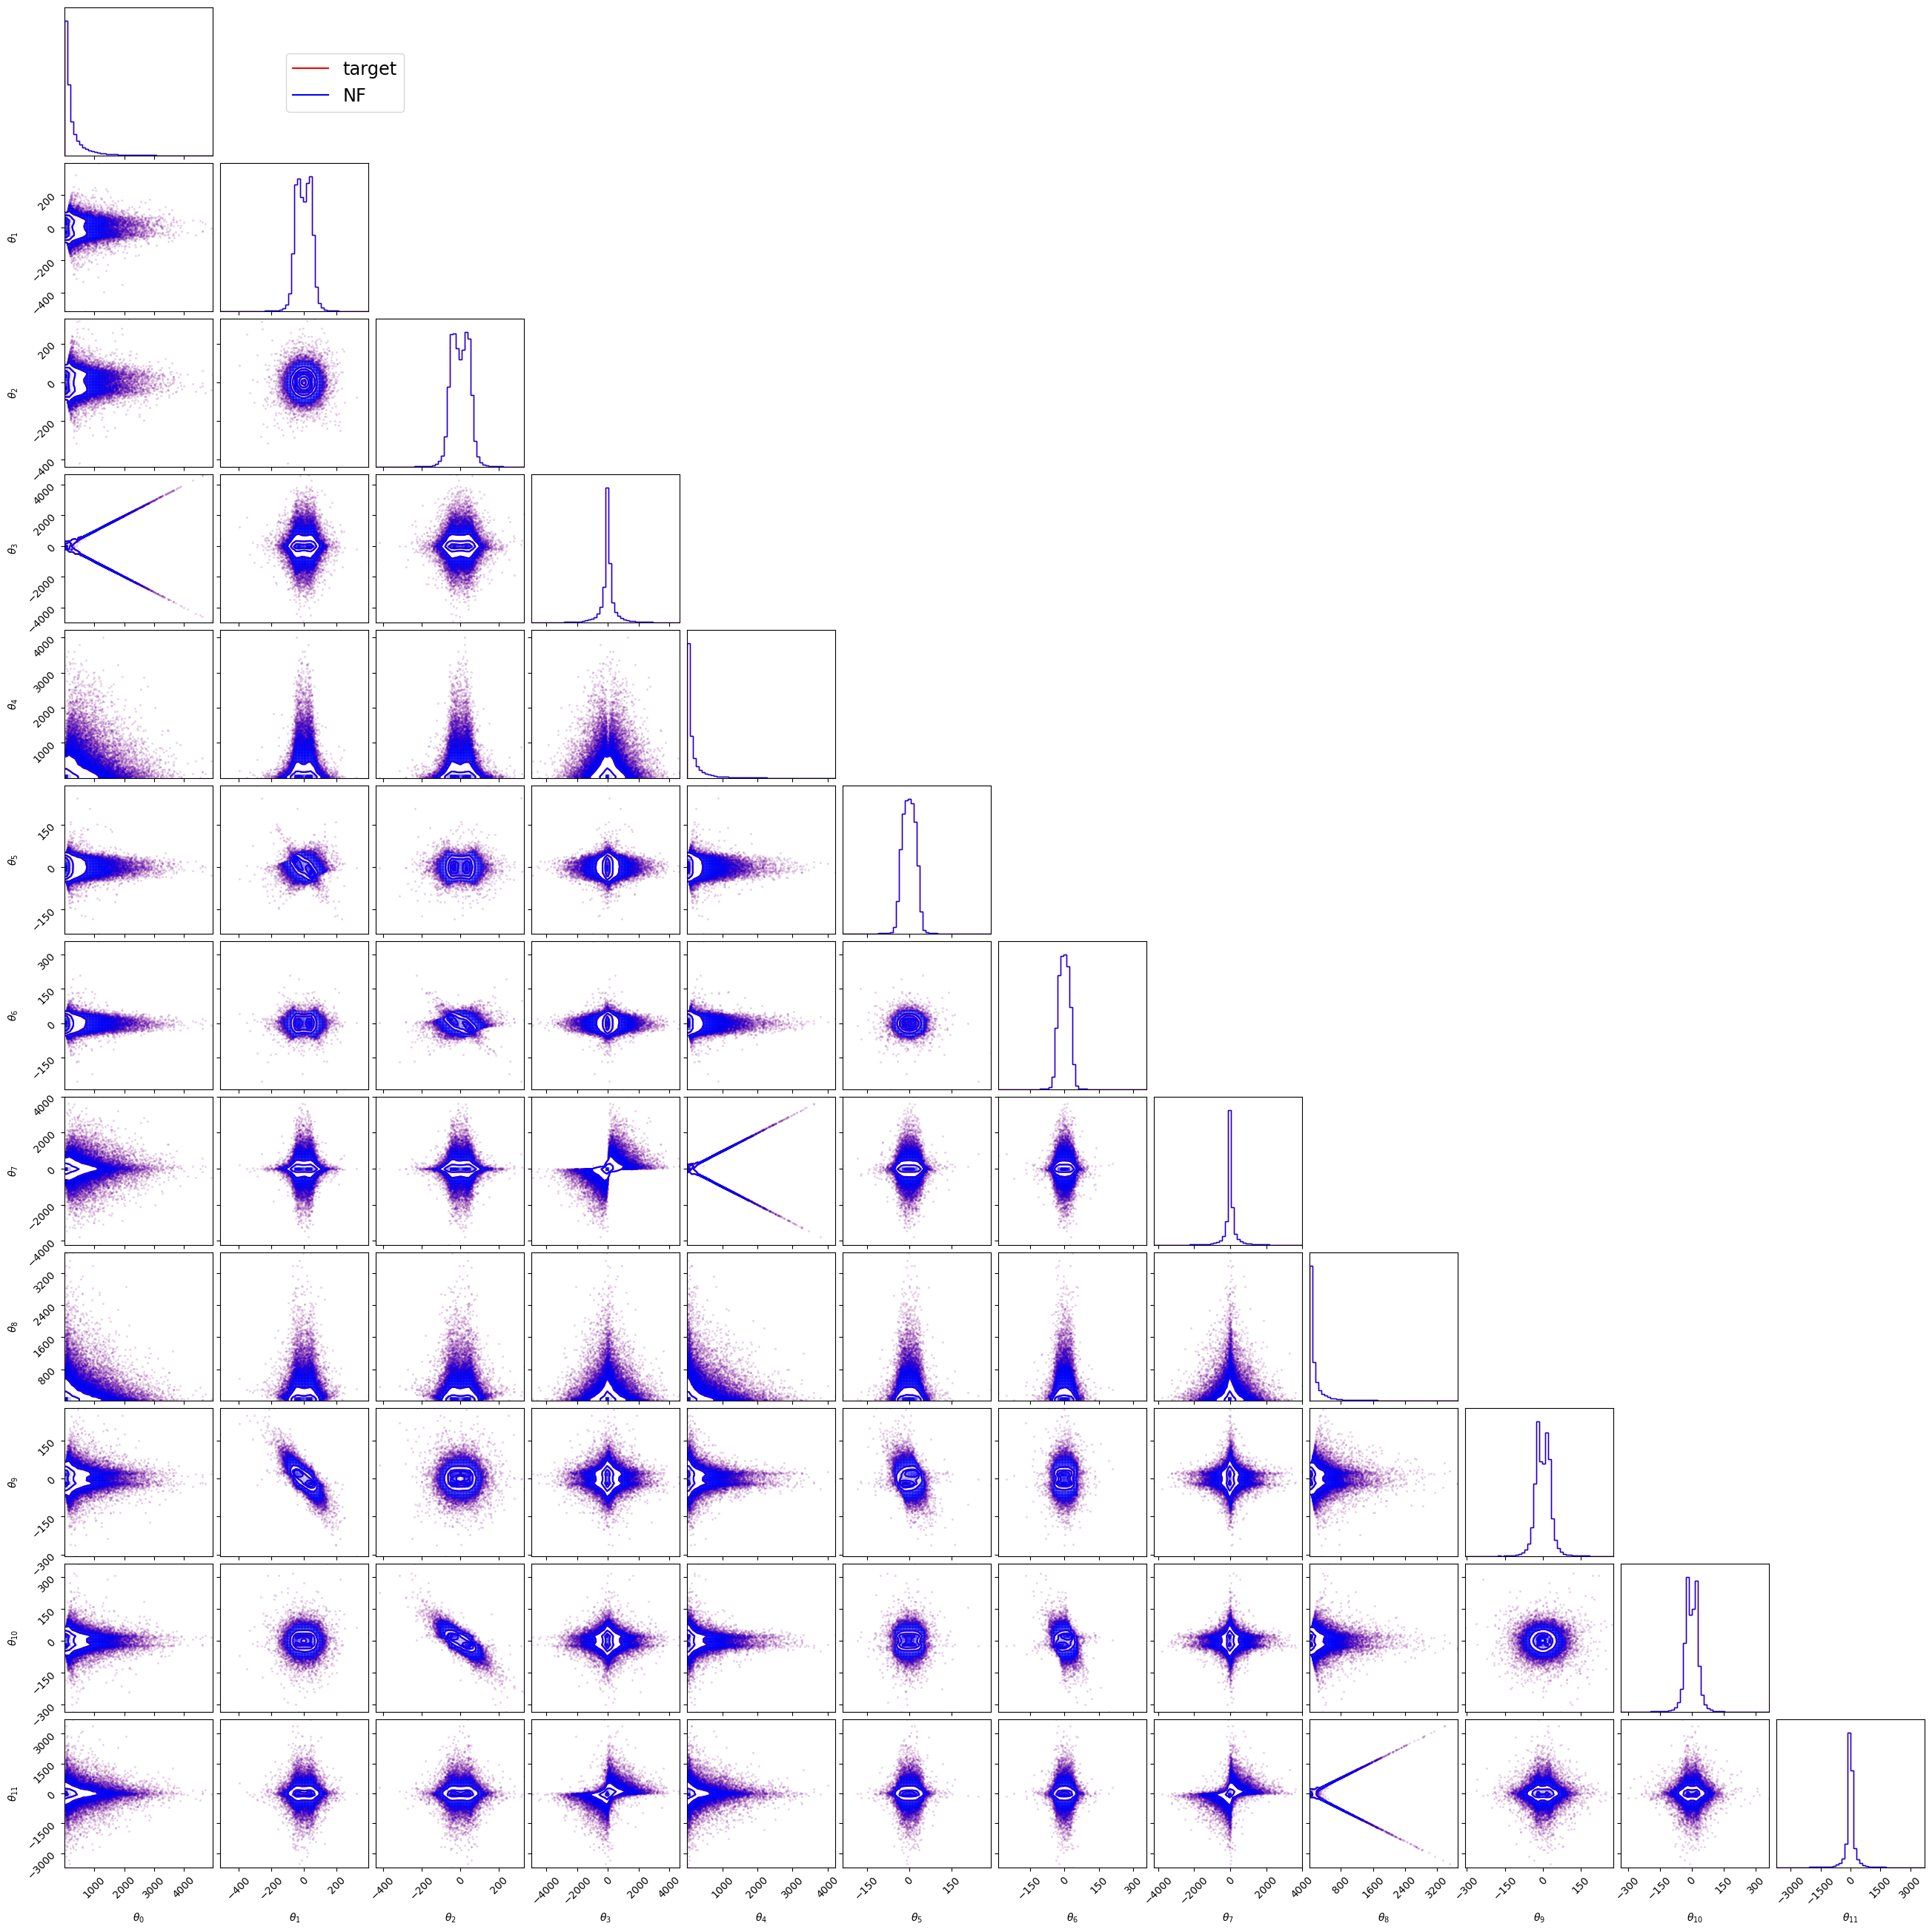

In [54]:
cornerplotter(X_data_train,X_data_train,max_dim=32)

## Check, fix, import results

### Check and fix results

In [15]:
correlated_results_paths = {"MAFN": "../CMoG/results/MAFN/",
                           "RealNVPN": "../CMoG/results/RealNVPN/",
                           "MsplineN": "../CMoG/results/MsplineN/",
                           "CsplineN": "../CMoG/results/CsplineN/"
                          }
correlated_unc_results_paths = {"MAFN": "../CMoG/results/MAFN_best/",
                                "RealNVPN": "../CMoG/results/RealNVPN_best/",
                                "MsplineN": "../CMoG/results/MsplineN_best/",
                                "CsplineN": "../CMoG/results/CsplineN_best/"
                               }

In [78]:
#import shutil
#for path in correlated_results_paths.values():
#    #path=correlated_results_paths["MAFN"]
#    print(path)
#    runs_list=[os.path.abspath(os.path.join(os.path.join(path,i),"results.txt")) for i in os.listdir(path) if ("run" in i and os.path.isdir(os.path.abspath(os.path.join(path,i))))]
#    for r in runs_list:
#        source_path=r.replace("NF4HEP/NormalizingFlowsHD","NF4HEP/NormalizingFlowsHD-2/Riccardo")
#        destination_path=r.replace("results.txt","results_bkp.txt")
#        shutil.copy2(source_path, destination_path)
#        print([source_path,destination_path,"Done."])

#### Runs

In [79]:
for res in correlated_results_paths.values():
    build_data_from_runs(res,"log_file_eternal_final.txt")

Processing path ../CMoG/results/MAFN/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_1/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_2/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_3/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_4/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_5/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_6/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_7/results.t

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_24/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_25/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_26/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_27/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_28/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_29/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN/run_30/results.txt
/mnt/c/Users/rtorre/

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_8/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_9/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_10/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_11/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_12/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_13/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_14/results.txt
/mnt/c/Users/rtorre/Dr

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_69/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_70/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_71/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_72/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_73/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_74/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN/run_75/results.txt
/mnt/c/Users/rtorre/

#### Uncertainties

In [16]:
for res in correlated_unc_results_paths.values():
    runs = [res+"/"+i+"/" for i in os.listdir(res)]
    for res_runs in runs:
        build_data_from_runs(res_runs,"log_file_eternal_final.txt")

Processing path ../CMoG/results/MAFN_best//1000D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_1/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_2/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_3/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_4/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_5/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/1000D/run_6/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHu

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/run_10/results.txt
Succesfully imported 10 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/32D/log_file_eternal_final.txt
Processing path ../CMoG/results/MAFN_best//400D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_1/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_2/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN_best/400D/run_3/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/run_10/results.txt
Succesfully imported 10 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/1000D/log_file_eternal_final.txt
Processing path ../CMoG/results/RealNVPN_best//100D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_1/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_2/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/100D/run_3/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/Nor

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_1/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_2/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_3/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_4/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_5/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNVPN_best/4D/run_6/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/RealNV

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_9/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/run_10/results.txt
Succesfully imported 10 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/16D/log_file_eternal_final.txt
Processing path ../CMoG/results/MsplineN_best//200D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_1/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/200D/run_2/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/Normaliz

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/64D/run_6/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/64D/run_7/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/64D/run_8/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/64D/run_9/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/64D/run_10/results.txt
Succesfully imported 10 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MsplineN_best/64D/log_file_eternal_final.txt
Processing path

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN_best/32D/run_7/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN_best/32D/run_8/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN_best/32D/run_9/results.txt
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN_best/32D/run_10/results.txt
Succesfully imported 10 runs (failed to import 0 runs).
Succesfully saved data to file /mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/CsplineN_best/32D/log_file_eternal_final.txt
Processing path ../CMoG/results/CsplineN_best//400D/ for succeeded runs.
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/Normalizin

### Import results

#### Runs

In [81]:
tmp_paths = {k: v+"log_file_eternal_final.txt" for k,v in correlated_results_paths.items()}
tmp = {k: pd.read_csv(tmp_paths[k]) for k in tmp_paths.keys()}
try:
    for k in tmp.keys():
        tmp[k]["epochs_input"] = tmp[k]["epochs_input"].fillna(1000)
        tmp[k]["epochs_output"] = tmp[k]["epochs_output"].fillna(0)
except:
    pass
df_correlated = pd.concat([df for df in tmp.values()],ignore_index=True).dropna().reset_index(drop=True)
df_correlated = df_correlated[~(df_correlated == 'failed').any(axis=1)]
len(df_correlated)

157

In [82]:
df_correlated

run_n  run_seed  ndims  nsamples correlation  nbijectors  bijector  \
0        1         0      4    100000        corr           5      MAFN   
1        2         0      4    100000        corr           5      MAFN   
2        3         0      4    100000        corr          10      MAFN   
3        4         0      4    100000        corr          10      MAFN   
4        5         0      8    100000        corr           5      MAFN   
..     ...       ...    ...       ...         ...         ...       ...   
152     51         0     64    100000        corr           5  CsplineN   
153     52         0     64    100000        corr           5  CsplineN   
154     53         0     64    100000        corr           5  CsplineN   
155     54         0     64    100000        corr           5  CsplineN   
156     63         0    100    100000        corr           5  CsplineN   

    activation  spline_knots  range_min  ...    wd_std  swd_mean   swd_std  \
0         relu             8         -5  ...  0.011880  0.029394  0.012714   
1         relu             8         -5  ...  0.011148  0.027307  0.011358   
2         relu             8         -5  ...  0.011683  0.032942  0.015316   
3         relu             8         -5  ...  0.012653  0.040439  0.018065   
4         relu             8         -5  ...  0.023241  0.041212  0.022324   
..         ...           ...        ...  ...       ...       ...       ...   
152       relu             8        -16  ...  0.052517  0.097759  0.054988   
153       relu            12        -16  ...  0.028621  0.050309  0.032722   
154       relu            12        -16  ...  0.031050  0.069015  0.034801   
155       relu            12        -16  ...  0.043200  0.082895  0.045368   
156       relu             8        -16  ...  0.060951  0.105275  0.063527   

      fn_mean    fn_std  hidden_layers  batch_size  epochs_input  \
0    0.043974  0.013159    128-128-128         512          1000   
1    0.034974  0.014084    256-256-256         512          1000   
2    0.025757  0.007126    128-128-128         512          1000   
3    0.054567  0.014298    256-256-256         512          1000   
4    0.078752  0.020209    128-128-128         512          1000   
..        ...       ...            ...         ...           ...   
152  1.206197  0.068597    512-512-512         512          1000   
153  0.858337  0.171722    128-128-128         512          1000   
154  1.181459  0.030153    256-256-256         512          1000   
155  1.222647  0.082691    512-512-512         512          1000   
156  2.368010  0.281556    512-512-512         512          1000   

     epochs_output         time  
0              323   745.240984  
1              361   833.398603  
2              288  1834.018883  
3              202   901.423236  
4              327   752.582348  
..             ...          ...  
152            109  2482.542158  
153            249  6506.313299  
154            152  3980.556303  
155            110  2915.697962  
156            148  3317.098976  

[157 rows x 27 columns]

#### Uncertainties

In [17]:
tmp_paths = {}
for k,v in correlated_unc_results_paths.items():
    runs = [v+"/"+i+"/log_file_eternal_final.txt" for i in os.listdir(v)]
    tmp_paths[k] = runs
flat_list = list()
for runs in list(tmp_paths.values()):
    flat_list += runs
tmp = []
for f in flat_list:
    print("Working on file",f)
    try:
        ttmp = pd.read_csv(f)
        ttmp['ks_list'] = None
        ttmp['ad_list'] = None
        ttmp['wd_list'] = None
        ttmp['swd_list'] = None
        ttmp['fn_list'] = None
        for index, row in ttmp.iterrows():
            #print(row)
            run_n = row['run_n']
            run_folder = f.replace("log_file_eternal_final.txt","run_"+str(run_n))
            run_details = run_folder+r"/details.json"
            try:
                #print("Loading file",run_details,".")
                with open(run_details, 'r') as file:
                    tmp_json = json.load(file)
                ks_list=tmp_json["ks_list"]
                ad_list=tmp_json["ad_list"]
                wd_list=tmp_json["wd_list"]
                swd_list=tmp_json["swd_list"]
                fn_list=tmp_json["fn_list"]
                #print(tmp_json["tmp_json"])
                ttmp.at[index, 'ks_list'] = ks_list
                ttmp.at[index, 'ad_list'] = ad_list
                ttmp.at[index, 'wd_list'] = wd_list
                ttmp.at[index, 'swd_list'] = swd_list
                ttmp.at[index, 'fn_list'] = fn_list
                #print("File",run_details,"succeeded.")
            except:
                ttmp.at[index, 'ks_list'] = None
                ttmp.at[index, 'ad_list'] = None
                ttmp.at[index, 'wd_list'] = None
                ttmp.at[index, 'swd_list'] = None
                ttmp.at[index, 'fn_list'] = None
                #print("File",run_details,"failed.")
        #print(ttmp)
        try:
            for j in ttmp.keys():
                ttmp[j]["epochs_input"] = ttmp[j]["epochs_input"].fillna(1000)
                ttmp[j]["epochs_output"] = ttmp[j]["epochs_output"].fillna(0)
        except:
            pass
        #print(ttmp)
        tmp.append(ttmp)
    except:
        pass
df_correlated_unc = pd.concat([df for df in tmp],ignore_index=True).reset_index(drop=True)
df_correlated_unc = df_correlated_unc[~(df_correlated_unc == 'failed').any(axis=1)]
len(df_correlated_unc)

Working on file ../CMoG/results/MAFN_best//1000D/log_file_eternal_final.txt
Working on file ../CMoG/results/MAFN_best//100D/log_file_eternal_final.txt
Working on file ../CMoG/results/MAFN_best//16D/log_file_eternal_final.txt
Working on file ../CMoG/results/MAFN_best//200D/log_file_eternal_final.txt
Working on file ../CMoG/results/MAFN_best//32D/log_file_eternal_final.txt
Working on file ../CMoG/results/MAFN_best//400D/log_file_eternal_final.txt
Working on file ../CMoG/results/MAFN_best//4D/log_file_eternal_final.txt
Working on file ../CMoG/results/MAFN_best//64D/log_file_eternal_final.txt
Working on file ../CMoG/results/MAFN_best//8D/log_file_eternal_final.txt
Working on file ../CMoG/results/RealNVPN_best//1000D/log_file_eternal_final.txt
Working on file ../CMoG/results/RealNVPN_best//100D/log_file_eternal_final.txt
Working on file ../CMoG/results/RealNVPN_best//16D/log_file_eternal_final.txt
Working on file ../CMoG/results/RealNVPN_best//200D/log_file_eternal_final.txt
Working on file

343

In [18]:
df_correlated_unc

run_n run_seed  ndims  nsamples correlation  nbijectors  bijector  \
0        1        0   1000    100000        corr           5      MAFN   
1        2      187   1000    100000        corr           5      MAFN   
2        3      377   1000    100000        corr           5      MAFN   
3        4      440   1000    100000        corr           5      MAFN   
4        5      520   1000    100000        corr           5      MAFN   
..     ...      ...    ...       ...         ...         ...       ...   
338      6      NaN      8    100000        None           5  CsplineN   
339      7      NaN      8    100000        None           5  CsplineN   
340      8      NaN      8    100000        None           5  CsplineN   
341      9      NaN      8    100000        None           5  CsplineN   
342     10      NaN      8    100000        None           5  CsplineN   

    activation  spline_knots  range_min  ...  epochs_input epochs_output  \
0         relu             8         -5  ...          1000         100.0   
1         relu             8         -5  ...          1000         214.0   
2         relu             8         -5  ...          1000         242.0   
3         relu             8         -5  ...          1000         563.0   
4         relu             8         -5  ...          1000         663.0   
..         ...           ...        ...  ...           ...           ...   
338       relu            12        -16  ...             2         179.0   
339       relu            12        -16  ...             2         210.0   
340       relu            12        -16  ...             2         211.0   
341       relu            12        -16  ...             2         206.0   
342       relu            12        -16  ...             2         190.0   

            time                                            ks_list  \
0     329.823233  [1.4686464406742677e-99, 6.442340194451593e-55...   
1     600.372778  [2.420211791699103e-79, 1.669865745518459e-104...   
2     654.317292  [0.000929977128997009, 5.77660747207657e-07, 3...   
3    1500.437258  [0.0025704904555854183, 3.101038755709402e-08,...   
4    1673.747293  [2.127433046037415e-145, 5.057758553530154e-68...   
..           ...                                                ...   
338   382.625413  [0.0006278972799238128, 0.3667356837968788, 2....   
339   393.927758  [0.23009750585879926, 0.7912059350314521, 0.00...   
340   366.987998  [0.127110543245193, 0.018824742428484434, 0.50...   
341   374.460552  [0.08413471385146415, 0.6042251174586427, 0.00...   
342   333.221533  [0.000832086912285238, 0.2582344696265808, 0.2...   

                                               ad_list  \
0    [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0...   
1    [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0...   
2    [0.02572657813719495, 0.001, 0.001, 0.001, 0.0...   
3    [0.001, 0.001, 0.001, 0.25, 0.0353217852379817...   
4    [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0...   
..                                                 ...   
338  [0.001, 0.21118126369371878, 0.001, 0.00538328...   
339  [0.14910451479674292, 0.25, 0.0172981777328977...   
340  [0.09813510434193667, 0.004755333551418563, 0....   
341  [0.1019197646756847, 0.25, 0.001, 0.25, 0.25, ...   
342  [0.007556318311781241, 0.12610070700730036, 0....   

                                               wd_list  \
0    [0.36360401089191435, 0.491645390514913, 0.182...   
1    [0.31896370434761045, 0.7342492719023256, 0.15...   
2    [0.0494065857887268, 0.21656142594378908, 0.08...   
3    [0.04044032316207885, 0.2462394874357851, 0.06...   
4    [0.4303507014274597, 0.5697559416941134, 0.114...   
..                                                 ...   
338  [0.05899910777251149, 0.027828065069090184, 0....   
339  [0.022513917534924033, 0.016858873527658913, 0...   
340  [0.10777010937286524, 0.06857346822870998, 0.0...   
341  [0.05277919262603458, 0.03102109030114183, 0.0...   
342  [0.1007103

In [19]:
df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==4][df_correlated_unc["bijector"]=="CsplineN"])
df_reduced

/tmp/ipykernel_8408/3307993237.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==4][df_correlated_unc["bijector"]=="CsplineN"])


run_n run_seed  ndims  nsamples correlation  nbijectors  bijector  \
313      1      NaN      4    100000        None           5  CsplineN   
314      2      NaN      4    100000        None           5  CsplineN   
315      3      NaN      4    100000        None           5  CsplineN   
316      4      NaN      4    100000        None           5  CsplineN   
317      5      NaN      4    100000        None           5  CsplineN   
318      6      NaN      4    100000        None           5  CsplineN   
319      7      NaN      4    100000        None           5  CsplineN   
320      8      NaN      4    100000        None           5  CsplineN   
321      9      NaN      4    100000        None           5  CsplineN   
322     10      NaN      4    100000        None           5  CsplineN   

    activation  spline_knots  range_min  ...  epochs_input epochs_output  \
313       relu             8        -16  ...             2         289.0   
314       relu             8        -16  ...             2         359.0   
315       relu             8        -16  ...             2         340.0   
316       relu             8        -16  ...             2         267.0   
317       relu             8        -16  ...             2         278.0   
318       relu             8        -16  ...             2         313.0   
319       relu             8        -16  ...             2         466.0   
320       relu             8        -16  ...             2         411.0   
321       relu             8        -16  ...             2         215.0   
322       relu             8        -16  ...             2         379.0   

           time                                            ks_list  \
313  311.298180  [5.881899170341349e-05, 0.27321683386131995, 0...   
314  340.927551  [0.3667356837968788, 0.5004275626413702, 0.006...   
315  346.714436  [0.005450549851452592, 0.32189015194890147, 0....   
316  340.003751  [0.2968514903604106, 0.28881767299299355, 0.10...   
317  333.029242  [0.08717458640626448, 0.2582344696265808, 0.33...   
318  314.857788  [0.15454104632436025, 0.06771054835137846, 0.1...   
319  331.449224  [0.04639733883233797, 0.23009750585879926, 0.0...   
320  301.781730  [0.02141057602373857, 0.734599370602186, 0.906...   
321  274.099022  [0.01512953257863315, 0.09685235111383245, 0.9...   
322  272.130009  [0.24386411273382524, 0.5457429448400982, 0.10...   

                                               ad_list  \
313  [0.001, 0.23790596828167018, 0.25, 0.25, 0.142...   
314  [0.25, 0.25, 0.04312394186859987, 0.1004852987...   
315  [0.0016997237876440671, 0.25, 0.14333831325162...   
316  [0.25, 0.23582203051287265, 0.1411669672060824...   
317  [0.14090725372235324, 0.25, 0.25, 0.0401618160...   
318  [0.21726568643433516, 0.12439802836839353, 0.2...   
319  [0.042615125558200934, 0.1734367367134652, 0.0...   
320  [0.01838559114406863, 0.25, 0.25, 0.0471667741...   
321  [0.014004552552260564, 0.056765739640559504, 0...   
322  [0.10905953705238625, 0.25, 0.1288181943326071...   

                                               wd_list  \
313  [0.046460873206434605, 0.023212679178797636, 0...   
314  [0.017028489977776184, 0.02086007090501944, 0....   
315  [0.0665296241770866, 0.026688493432656973, 0.0...   
316  [0.022520487873977382, 0.02958743731801647, 0....   
317  [0.033532111218211515, 0.030906885901515503, 0...   
318  [0.012229046672418139, 0.028090274779921865, 0...   
319  [0.07325767105298367, 0.03727138695812351, 0.0...   
320  [0.026095331417805307, 0.022010108761318814, 0...   
321  [0.02605459746374647, 0.03907173865392645, 0.0...   
322  [0.02585478292589833, 0.025875959374594394, 0....   

                                              swd_list  \
313  [0.05112138602035841, 0.020633359016750105, 0....   
314  [0.032257172770693024, 0.04354080818474807, 0....   
315  [0.039365980878563155, 0.07000078542877161, 0....   
316  [0.025909881874998913, 0.03384046772912721, 0....   
317  [0.031380

In [29]:
for ndims in [4,8,16,32,64,100,200,400,1000]:
    print("\n================================   ",str(ndims)+"D   ======================================")
    for bijector in ["MAFN","RealNVPN","MsplineN","CsplineN"]:
        try:
            print("-------------------------------------------------------------------------------")
            df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
            rry = np.array(list(df_reduced["ks_list"]))
            print(bijector,"bijector in",ndims,"dimensions. KS:",[np.mean(rry.flatten()),np.std(rry.flatten())])
            rry = np.array(list(df_reduced["swd_list"]))
            print(bijector,"bijector in",ndims,"dimensions. SWD:",[np.mean(rry.flatten()),np.std(rry.flatten())])
            rry = np.array(list(df_reduced["fn_list"]))
            print(bijector,"bijector in",ndims,"dimensions. FN:",[np.mean(rry.flatten()),np.std(rry.flatten())])
            rry = np.array(list(df_reduced["time"]))
            print(bijector,"bijector in",ndims,"dimensions. Time:",[np.mean(rry.flatten()),np.std(rry.flatten())])
        except:
            print(bijector,"bijector in",ndims,"dimensions:",[np.nan,np.nan])


================================    4D   ======================================
-------------------------------------------------------------------------------
MAFN bijector in 4 dimensions. KS: [0.2986428084034797, 0.2704245384221802]
MAFN bijector in 4 dimensions. SWD: [0.029640768036248016, 0.013426351874369821]
MAFN bijector in 4 dimensions. FN: [0.036953894837445295, 0.014610044023810055]
MAFN bijector in 4 dimensions. Time: [31.66023581569316, 6.842120873443246]
-------------------------------------------------------------------------------
RealNVPN bijector in 4 dimensions. KS: [0.28350828504112857, 0.2848725528696947]
RealNVPN bijector in 4 dimensions. SWD: [0.0307832916191555, 0.014977572301549847]
RealNVPN bijector in 4 dimensions. FN: [0.03291809328426553, 0.014931350530471437]
RealNVPN bijector in 4 dimensions. Time: [131.2038691337002, 33.725772776460026]
-------------------------------------------------------------------------------
MsplineN bijector in 4 dimensions. KS:

/tmp/ipykernel_8408/2886143408.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


## Likelihood fit

In [120]:
#def likelihood_uniform(measurements, uncertainties):
#    # Ensure that all measurements are within the interval [0,1]
#    if np.any(measurements < 0) or np.any(measurements > 1):
#        return 0
#    # Compute the likelihood assuming Gaussian uncertainties
#    likelihoods = (1/(np.sqrt(2*np.pi)*uncertainties)) * np.exp(-0.5 * ((measurements - 0.5) / uncertainties)**2)
#    # The total likelihood is the product of individual likelihoods
#    total_likelihood = np.prod(likelihoods)
#    return total_likelihood
#
#def neg_likelihood_uniform(measurements, uncertainties):
#    return -likelihood_uniform(measurements, uncertainties)
#
#def neg_log_likelihood_gaussian(mu, measurements, uncertainties=None):
#    n = len(measurements)
#    if uncertainties is None:    
#        log_likelihood = n*np.log(sigma * np.sqrt(2 * np.pi)) + np.sum((measurements - mu)**2 / (2 * sigma**2))
#    else:
#        log_likelihood = np.sum(np.log(uncertainties * np.sqrt(2 * np.pi)) + ((measurements - mu)**2 / (2 * uncertainties**2)))
#    return log_likelihood



#def gaussian(x, mu, sigma):
#    return (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-(x-mu)**2 / (2 * sigma**2))
#
#def weighted_sum_of_squared_differences(params, measurements, uncertainties):
#    mu, sigma = params
#    model_values = norm(loc=mu, scale=np.sqrt(sigma**2 + uncertainties**2)).pdf(measurements)
#    differences = measurements - model_values
#    weighted_squares = differences**2 / uncertainties**2
#    return np.sum(weighted_squares)

In [309]:
uncertainties = ks[:,1]
uncertainties

array([0.26999525, 0.22366441, 0.24493149, 0.20944349, 0.10945168,
       0.295335  , 0.23826307, 0.26175365, 0.30373726, 0.25307937])


Getting best estimates in 100 dimensions through maximum likelihood

-----------------------------------------------------------------------
CsplineN bijector
[1.08631315e-02 2.46483968e-03 1.31752658e-02 5.38419881e-03
 2.06448648e-02 1.95832645e-02 3.71541222e-02 1.75711316e-38
 1.66550282e-02 6.25728167e-03]
[4.61698666e-02 1.70797665e-02 4.65758785e-02 4.74896695e-02
 7.29379842e-02 6.88133990e-02 1.05225969e-01 3.06070358e-37
 5.44194565e-02 3.97474058e-02]
Point 8 is likely an outlier. Deleting it before estimating parameters.
[mean,std] excluding point 8 are [0.0146868885629205, 0.009955484504631013] .
Value of pount 8 is [1.7571131578913516e-38, 3.060703581877197e-37]


/tmp/ipykernel_50/1139947028.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


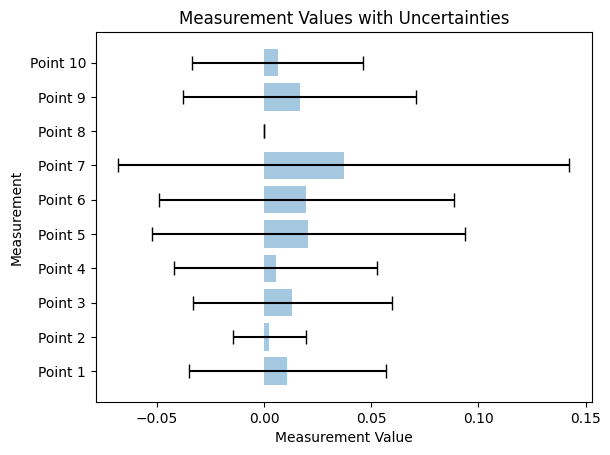

Measurements are compatible. Estimating weighted mean and std.
KS - initial guess:  [0.0146868885629205, 0.009955484504631013]
KS - WM mean estimate:  0.00686132986426756
KS - Sigma_syst estimate:  0.009955484504631013
KS - Sigma_stat estimate:  0.055384377287738186
KS - Sigma_wm estimate:  0.012637420952118046
-.-.-.-.-.-.-.-.
[0.12160115 0.13104592 0.11148076 0.21711406 0.0906318  0.09715026
 0.07501029 2.7012301  0.1030261  0.11925859]
[0.06756744 0.08252081 0.06422475 0.1374442  0.05103157 0.05847157
 0.03678527 1.61334041 0.06090794 0.06861688]
Point 8 is likely an outlier. Deleting it before estimating parameters.
[mean,std] excluding point 8 are [0.11847988195503673, 0.03844886170524288] .
Value of pount 8 is [2.7012300998313785, 1.6133404078332427]


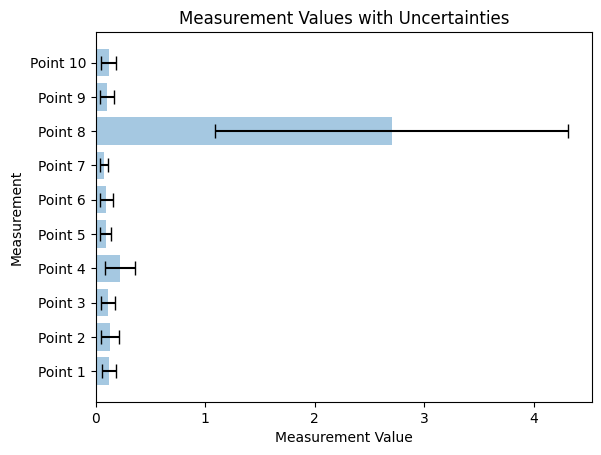

Measurements are compatible. Estimating weighted mean and std.
SWD - initial guess:  [0.11847988195503673, 0.03844886170524288]
SWD - WM mean estimate:  0.1001098105742256
SWD - Sigma_syst estimate:  0.03844886170524288
SWD - Sigma_stat estimate:  0.06973004937151255
SWD - Sigma_wm estimate:  0.01976923425387647
-.-.-.-.-.-.-.-.
[ 3.6177912   2.91910267  3.64655588  3.08639435  2.33717565  2.90541779
  2.10968715 60.19848202  2.14033934  3.60023727]
[0.46941172 0.29256796 0.48668806 0.23493972 0.2221166  0.43992106
 0.2990295  0.20045669 0.15976361 0.65916243]
Point 8 is likely an outlier. Deleting it before estimating parameters.
[mean,std] excluding point 8 are [2.929189033139579, 0.5877283228073377] .
Value of pount 8 is [60.19848201990244, 0.2004566949985247]


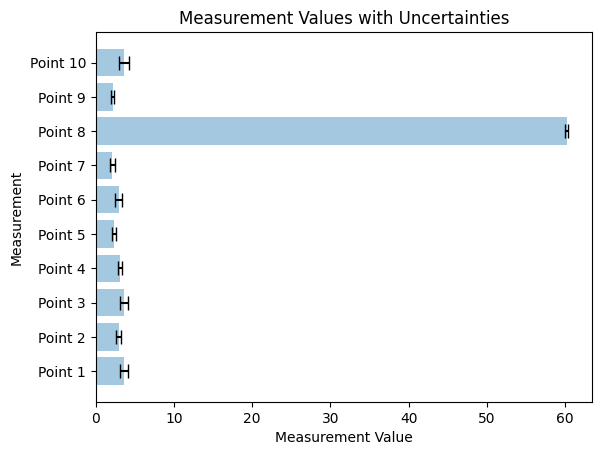

Measurements are compatible. Estimating weighted mean and std.
FN - initial guess:  [2.929189033139579, 0.5877283228073377]
FN - WM mean estimate:  2.5711841654949006
FN - Sigma_syst estimate:  0.5877283228073377
FN - Sigma_stat estimate:  0.3626222953999531
FN - Sigma_wm estimate:  0.09258490185984625
-.-.-.-.-.-.-.-.
Time - Best initial guess:  [3522.6134697787347, 424.4497409444365]
Time - Best MLE estimate:  3522.613470056274
Time - Sigma_tot estimate:  424.44974009309743


In [482]:
# This is our likelihood function
def neg_log_likelihood(params, measurements, uncertainties):
    mu, sigma = params
    #mu, log_sigma = params
    #sigma = np.exp(log_sigma)
    if uncertainties is not None:
        sigma_tot = np.sqrt(sigma**2+uncertainties**2)
    else:
        sigma_tot = sigma
    return np.sum(np.log(sigma_tot * np.sqrt(2 * np.pi)) + ((measurements - mu)**2 / (2 * sigma_tot**2)))

def plot_measurements(measurements,uncertainties):
    # Create y positions
    y_pos = range(len(measurements))
    # Create horizontal bars
    plt.barh(y_pos, measurements, xerr=uncertainties, align='center', alpha=0.4, ecolor='black', capsize=5)
    #Create names on the y-axis
    plt.yticks(y_pos, ['Point '+str(i) for i in range(1,len(measurements)+1)])
    plt.xlabel('Measurement Value')
    plt.ylabel('Measurement')
    plt.title('Measurement Values with Uncertainties')
    # Show graphic
    plt.show()

#def neg_log_likelihood_gaussian(params, measurements):
#    mu, sigma = params
#    #n = len(measurements)
#    #log_likelihood = n*np.log(sigma * np.sqrt(2 * np.pi)) + np.sum((measurements - mu)**2 / (2 * sigma**2))
#    return -np.sum(norm.logpdf(measurements, loc=mu, scale=sigma))
#    #return log_likelihood

# Now for the confidence interval, we find where the likelihood decreases by 0.5 from its maximum
#def tmu(mu, measurements, uncertainties):
#    initial_guess = np.mean(measurements)
#    result = minimize(neg_log_likelihood, initial_guess, args=(measurements, uncertainties))
#    mu_mle = result.x[0]
#    return 2*(neg_log_likelihood(mu, measurements, uncertainties)-neg_log_likelihood(mu_mle, measurements, uncertainties))
#
#def solve_high(x,mu_mle, measurements, uncertainties):
#    return tmu(mu_mle+x, measurements, uncertainties)-1
#    
#def solve_low(x,mu_mle, measurements, uncertainties):
#    return tmu(mu_mle-x, measurements, uncertainties)-1

for ndims in [100]:
    print("\n=======================================================================")
    print("Getting best estimates in",ndims,"dimensions through maximum likelihood")
    for bijector in ["CsplineN"]:
        print("\n-----------------------------------------------------------------------")
        print(bijector,"bijector")
        df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
        ### KS
        ks = df_reduced[["ks_mean","ks_std"]].to_numpy()
        measurements = ks[:,0]
        uncertainties = ks[:,1]
        print(measurements)
        print(uncertainties)
        to_delete=[]
        mean = np.mean(measurements)
        sigma_stat = np.mean(uncertainties)
        sigma_0 = np.std(measurements)
        for i in range(len(measurements)):
            m = np.delete(measurements,i)
            mean_not_i = np.mean(m)
            std_not_i = np.std(m)
            if measurements[i]<mean_not_i/10 or measurements[i]>10*mean_not_i:
                print("Point",i+1,"is likely an outlier. Deleting it before estimating parameters.")
                print("[mean,std] excluding point",i+1,"are",[mean_not_i,std_not_i],".")
                print("Value of pount",i+1,"is",[measurements[i],uncertainties[i]])
                to_delete.append(i)
        if to_delete != []:
            plot_measurements(measurements,uncertainties)
        measurements=np.delete(measurements,to_delete)
        uncertainties=np.delete(uncertainties,to_delete)
        mean = np.mean(measurements)
        sigma_stat = np.mean(uncertainties)
        sigma_0 = np.std(measurements)
        initial_guess = [mean, sigma_0]
        if sigma_0<=2*sigma_stat:
            # Weighted mean
            print("Measurements are compatible. Estimating weighted mean and std.")
            weights = 1/(uncertainties**2)
            mu_wm = np.dot(measurements,weights)/np.sum(weights)
            sigms_wm = 1/np.sqrt(np.sum(weights))
            print('KS - initial guess: ', initial_guess)
            print('KS - WM mean estimate: ', mu_wm)
            print('KS - Sigma_syst estimate: ', sigma_0)
            print('KS - Sigma_stat estimate: ', sigma_stat)
            print('KS - Sigma_wm estimate: ', sigms_wm)
            print('-.-.-.-.-.-.-.-.')
        else:
            print("Measurements are not compatible. Performing MLE of mean and std.")
            # ML estimate
            bounds = [(None, None), (1e-10, None)]  # bounds for mu and sigma
            result = minimize(neg_log_likelihood, initial_guess, args=(measurements, uncertainties),bounds=bounds, method='L-BFGS-B',options={"maxiter": 100000,"gtol":1e-12,"ftol":1e-12})
            mu_mle, sigma_syst = result.x
            sigma_tot_mle = np.sqrt(sigma_syst**2+sigma_stat**2)
            print('KS - Best initial guess: ', initial_guess)
            print('KS - Best MLE estimate: ', mu_mle)
            print('KS - Sigma_syst estimate: ', sigma_syst)
            print('KS - Sigma_stat estimate: ', sigma_stat)
            print('KS - Sigma_tot estimate: ', sigma_tot_mle)
            print('-.-.-.-.-.-.-.-.')
        ## SWD
        swd = df_reduced[["swd_mean","swd_std"]].to_numpy()
        measurements = swd[:,0]
        uncertainties = swd[:,1]
        print(measurements)
        print(uncertainties)
        to_delete=[]
        mean = np.mean(measurements)
        sigma_stat = np.mean(uncertainties)
        sigma_0 = np.std(measurements)
        for i in range(len(measurements)):
            m = np.delete(measurements,i)
            mean_not_i = np.mean(m)
            std_not_i = np.std(m)
            if measurements[i]<mean_not_i/10 or measurements[i]>10*mean_not_i:
                print("Point",i+1,"is likely an outlier. Deleting it before estimating parameters.")
                print("[mean,std] excluding point",i+1,"are",[mean_not_i,std_not_i],".")
                print("Value of pount",i+1,"is",[measurements[i],uncertainties[i]])
                to_delete.append(i)
        if to_delete != []:
            plot_measurements(measurements,uncertainties)
        measurements=np.delete(measurements,to_delete)
        uncertainties=np.delete(uncertainties,to_delete)
        mean = np.mean(measurements)
        sigma_stat = np.mean(uncertainties)
        sigma_0 = np.std(measurements)
        initial_guess = [mean, sigma_0]
        if sigma_0<=2*sigma_stat:
            # Weighted mean
            print("Measurements are compatible. Estimating weighted mean and std.")
            weights = 1/(uncertainties**2)
            mu_wm = np.dot(measurements,weights)/np.sum(weights)
            sigms_wm = 1/np.sqrt(np.sum(weights))
            print('SWD - initial guess: ', initial_guess)
            print('SWD - WM mean estimate: ', mu_wm)
            print('SWD - Sigma_syst estimate: ', sigma_0)
            print('SWD - Sigma_stat estimate: ', sigma_stat)
            print('SWD - Sigma_wm estimate: ', sigms_wm)
            print('-.-.-.-.-.-.-.-.')
        else:
            print("Measurements are not compatible. Performing MLE of mean and std.")
            # ML estimate
            bounds = [(None, None), (1e-10, None)]  # bounds for mu and sigma
            result = minimize(neg_log_likelihood, initial_guess, args=(measurements, uncertainties),bounds=bounds, method='L-BFGS-B',options={"maxiter": 100000,"gtol":1e-12,"ftol":1e-12})
            mu_mle, sigma_syst = result.x
            sigma_tot_mle = np.sqrt(sigma_syst**2+sigma_stat**2)
            print('SWD - Best initial guess: ', initial_guess)
            print('SWD - Best MLE estimate: ', mu_mle)
            print('SWD - Sigma_syst estimate: ', sigma_syst)
            print('SWD - Sigma_stat estimate: ', sigma_stat)
            print('SWD - Sigma_tot estimate: ', sigma_tot_mle)
            print('-.-.-.-.-.-.-.-.')
        ### FN
        fn = df_reduced[["fn_mean","fn_std"]].to_numpy()
        measurements = fn[:,0]
        uncertainties = fn[:,1]
        print(measurements)
        print(uncertainties)
        to_delete=[]
        mean = np.mean(measurements)
        sigma_stat = np.mean(uncertainties)
        sigma_0 = np.std(measurements)
        for i in range(len(measurements)):
            m = np.delete(measurements,i)
            mean_not_i = np.mean(m)
            std_not_i = np.std(m)
            if measurements[i]<mean_not_i/10 or measurements[i]>10*mean_not_i:
                print("Point",i+1,"is likely an outlier. Deleting it before estimating parameters.")
                print("[mean,std] excluding point",i+1,"are",[mean_not_i,std_not_i],".")
                print("Value of pount",i+1,"is",[measurements[i],uncertainties[i]])
                to_delete.append(i)
        if to_delete != []:
            plot_measurements(measurements,uncertainties)
        measurements=np.delete(measurements,to_delete)
        uncertainties=np.delete(uncertainties,to_delete)
        mean = np.mean(measurements)
        sigma_stat = np.mean(uncertainties)
        sigma_0 = np.std(measurements)
        initial_guess = [mean, sigma_0]
        if sigma_0<=2*sigma_stat:
            # Weighted mean
            print("Measurements are compatible. Estimating weighted mean and std.")
            weights = 1/(uncertainties**2)
            mu_wm = np.dot(measurements,weights)/np.sum(weights)
            sigms_wm = 1/np.sqrt(np.sum(weights))
            print('FN - initial guess: ', initial_guess)
            print('FN - WM mean estimate: ', mu_wm)
            print('FN - Sigma_syst estimate: ', sigma_0)
            print('FN - Sigma_stat estimate: ', sigma_stat)
            print('FN - Sigma_wm estimate: ', sigms_wm)
            print('-.-.-.-.-.-.-.-.')
        else:
            print("Measurements are not compatible. Performing MLE of mean and std.")
            # ML estimate
            bounds = [(None, None), (1e-10, None)]  # bounds for mu and sigma
            result = minimize(neg_log_likelihood, initial_guess, args=(measurements, uncertainties),bounds=bounds, method='L-BFGS-B',options={"maxiter": 100000,"gtol":1e-12,"ftol":1e-12})
            mu_mle, sigma_syst = result.x
            sigma_tot_mle = np.sqrt(sigma_syst**2+sigma_stat**2)
            print('FN - Best initial guess: ', initial_guess)
            print('FN - Best MLE estimate: ', mu_mle)
            print('FN - Sigma_syst estimate: ', sigma_syst)
            print('FN - Sigma_stat estimate: ', sigma_stat)
            print('FN - Sigma_tot estimate: ', sigma_tot_mle)
            print('-.-.-.-.-.-.-.-.')
        ### TIME
        time = df_reduced["time"].to_numpy()
        measurements = time
        uncertainties = None
        mean = np.mean(measurements)
        sigma_0 = np.std(measurements)
        initial_guess = [mean, sigma_0]
        result = minimize(neg_log_likelihood, initial_guess, args=(measurements, None),method='Powell')
        mu_mle = result.x[0]
        sigma_tot_mle = result.x[1]
        print('Time - Best initial guess: ', initial_guess)
        print('Time - Best MLE estimate: ', mu_mle)
        print('Time - Sigma_tot estimate: ', sigma_tot_mle)

In [440]:
measurements

array([1.08631315e-02, 2.46483968e-03, 1.31752658e-02, 5.38419881e-03,
       2.06448648e-02, 1.95832645e-02, 3.71541222e-02, 1.75711316e-38,
       1.66550282e-02, 6.25728167e-03])

In [449]:
from scipy import stats
# Calculate z-scores
z_scores = np.abs(stats.zscore(measurements))

# Chose a threshold
threshold = 0.01

# Find outliers
outliers = measurements[z_scores > threshold]

print("Outliers: ", z_scores)

Outliers:  [0.22597518 1.03181403 0.00411962 0.75169361 0.71260863 0.61074521
 2.29671661 1.26832207 0.32977301 0.66791894]


In [407]:
[measurements, uncertainties]

[array([0.12160115, 0.13104592, 0.11148076, 0.21711406, 0.0906318 ,
        0.09715026, 0.07501029, 0.1030261 , 0.11925859]),
 array([0.06756744, 0.08252081, 0.06422475, 0.1374442 , 0.05103157,
        0.05847157, 0.03678527, 0.06090794, 0.06861688])]

In [350]:
print(neg_log_likelihood([0.028,0],measurements,uncertainties),neg_log_likelihood([0.028,0.001],measurements,uncertainties))

-33.09130639304707 -33.045457251811186


In [417]:
measurements

array([3293.8100225 , 3327.77013644, 3634.90744427, 3354.08085802,
       3525.71747086, 3908.77780004, 3800.7869425 , 2494.55528361,
       3813.23137209, 4072.49736745])

In [425]:
['Measurement '+str(i) for i in range(1,len(measurements)+1)]

['Measurement 1',
 'Measurement 2',
 'Measurement 3',
 'Measurement 4',
 'Measurement 5',
 'Measurement 6',
 'Measurement 7',
 'Measurement 8',
 'Measurement 9',
 'Measurement 10']

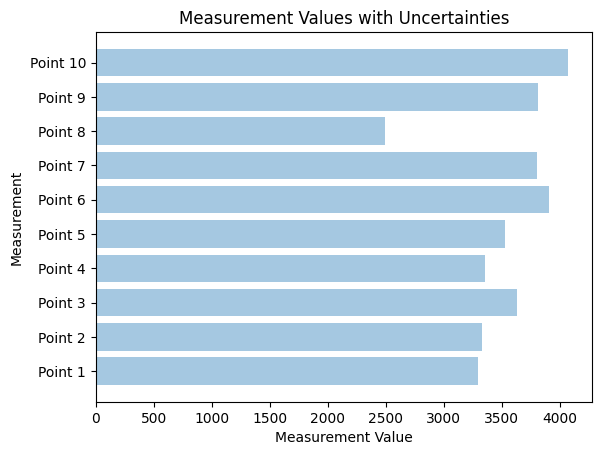

In [427]:
def plot_measurements(measurements,uncertainties):
    # Create y positions
    y_pos = range(len(measurements))
    # Create horizontal bars
    plt.barh(y_pos, measurements, xerr=uncertainties, align='center', alpha=0.4, ecolor='black', capsize=5)
    #Create names on the y-axis
    plt.yticks(y_pos, ['Point '+str(i) for i in range(1,len(measurements)+1)])
    plt.xlabel('Measurement Value')
    plt.ylabel('Measurement')
    plt.title('Measurement Values with Uncertainties')
    # Show graphic
    plt.show()

In [481]:
ndims=4
bijector = "MAFN"
df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
### Check for outliers
to_delete=[]
ks = df_reduced[["ks_mean","ks_std"]].to_numpy()
measurements = ks[:,0]
uncertainties = ks[:,1]
print(measurements,uncertainties)

[0.28561654 0.48163636 0.57410869 0.20632799 0.12295968 0.36141184
 0.60336069 0.32436373 0.47867247 0.43143097] [0.26999525 0.22366441 0.24493149 0.20944349 0.10945168 0.295335
 0.23826307 0.26175365 0.30373726 0.25307937]


/tmp/ipykernel_50/2162307296.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


In [485]:
def neg_log_likelihood(params, measurements, uncertainties=None):
    mu, sigma = params
    #mu, log_sigma = params
    #sigma = np.exp(log_sigma)
    if uncertainties is not None:
        sigma_tot = np.sqrt(sigma**2+uncertainties**2)
    else:
        sigma_tot = sigma
    return np.sum(np.log(sigma_tot * np.sqrt(2 * np.pi)) + ((measurements - mu)**2 / (2 * sigma_tot**2)))


Getting best estimates in 4 dimensions through maximum likelihood

-----------------------------------------------------------------------
MAFN bijector

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
KS - Best initial guess:  [0.3869888971722256, 0.14777412878832172]
KS - Best MLE estimate:  0.32537776668041746
KS - Sigma_syst estimate:  0.07354727740834476
KS - Sigma_stat estimate:  0.24096546563066545
KS - Sigma_tot estimate:  0.2519395912531086
-.-.-.-.-.-.-.-.

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.0301333226607809, 0.006429830020876331]
SWD - WM mean estimate:  0.027295375923345532
SWD - Sigma_syst estimate:  0.006429830020876331
SWD - Sigma_stat estimate:  0.012954493745989431
SWD - Sigma_wm estimate:  0.003621917941988377
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
FN - initial guess:  [0.034605985

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


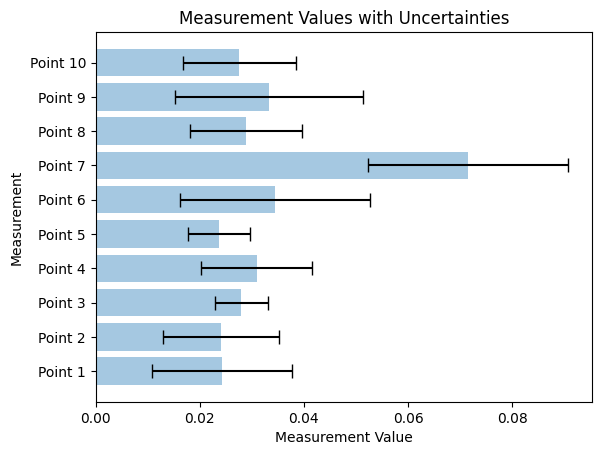


!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
KS - Best initial guess:  [0.41859226713137165, 0.1833850706144501]
KS - Best MLE estimate:  0.36601805266526904
KS - Sigma_syst estimate:  0.09590483574467447
KS - Sigma_stat estimate:  0.24010924693088923
KS - Sigma_tot estimate:  0.258554033000709
-.-.-.-.-.-.-.-.

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.027865349396874788, 0.006253191311235575]
SWD - WM mean estimate:  0.025252059379211232
SWD - Sigma_syst estimate:  0.006253191311235575
SWD - Sigma_stat estimate:  0.012216354910584433
SWD - Sigma_wm estimate:  0.0036928492031783338
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
FN - initial guess:  [0.02834344011332962, 0.0037353478958829884]
FN - WM mean estimate:  0.027059903942239165
FN - Sigma_syst estimate:  0.0037353478958829884
FN - Sigma_stat estimate:

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.3491085603835248, 0.08850258573556102]
KS - WM mean estimate:  0.3293265313031836
KS - Sigma_syst estimate:  0.08850258573556102
KS - Sigma_stat estimate:  0.2634426946485159
KS - Sigma_wm estimate:  0.08146653998359352
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.03993927070796754, 0.011500810117727642]
SWD - WM mean estimate:  0.03525840175539176
SWD - Sigma_syst estimate:  0.011500810117727642
SWD - Sigma_stat estimate:  0.024371829976978232
SWD - Sigma_wm estimate:  0.0066688942381738225
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
FN - initial guess:  [0.06512553414472928, 0.01253798669165739]
FN - WM mean estimate:  0.06779366932759126
FN - Sigma_syst estimate:  0.01253798669165739
FN - Sigma_stat estimate:  0.021662617470930713
FN - Sigma_wm es

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


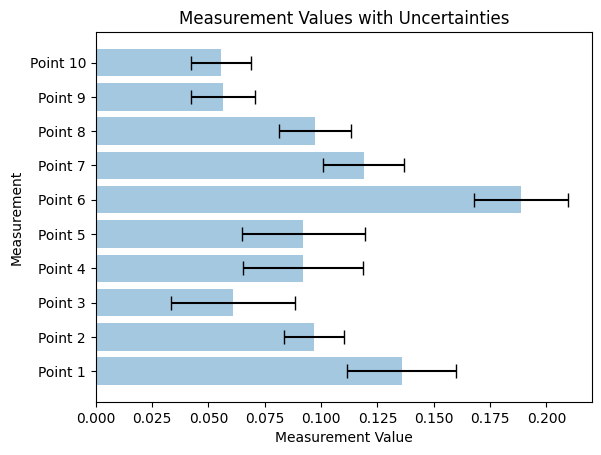

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.23617746087852337, 0.0703188768915547]
KS - WM mean estimate:  0.21601006697272865
KS - Sigma_syst estimate:  0.0703188768915547
KS - Sigma_stat estimate:  0.2310707217590708
KS - Sigma_wm estimate:  0.07447295897369753
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.04202302401412688, 0.00731387624923725]
SWD - WM mean estimate:  0.04005176788328094
SWD - Sigma_syst estimate:  0.00731387624923725
SWD - Sigma_stat estimate:  0.022997247692041367
SWD - Sigma_wm estimate:  0.007374582861117295
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [0.08952955435257623, 0.026210631496341695]
FN - Best MLE estimate:  0.0875192624780629
FN - Sigma_syst estimate:  0.019146320154013383
FN - Sigma_stat estimate:  0.0199795

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.3290293224637762, 0.08142351692054382]
KS - WM mean estimate:  0.2998587383014766
KS - Sigma_syst estimate:  0.08142351692054382
KS - Sigma_stat estimate:  0.26078834124512507
KS - Sigma_wm estimate:  0.07951581737667117
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.03611148703586569, 0.007060894791138982]
SWD - WM mean estimate:  0.03349828609079167
SWD - Sigma_syst estimate:  0.007060894791138982
SWD - Sigma_stat estimate:  0.020233834594876772
SWD - Sigma_wm estimate:  0.005925651724752074
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [1.1729822751438765, 0.24948970960531064]
FN - Best MLE estimate:  1.1769336460666606
FN - Sigma_syst estimate:  0.19478777835000158
FN - Sigma_stat estimate:  0.1661098

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


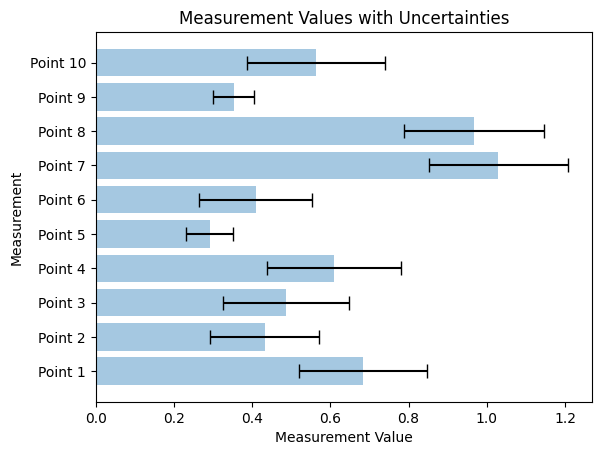

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.09864879316881511, 0.04911917474913033]
KS - WM mean estimate:  0.08361472533250555
KS - Sigma_syst estimate:  0.04911917474913033
KS - Sigma_stat estimate:  0.1837028920418181
KS - Sigma_wm estimate:  0.057976326788974575
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.04389268225169117, 0.00884052889266828]
SWD - WM mean estimate:  0.04108455932973563
SWD - Sigma_syst estimate:  0.00884052889266828
SWD - Sigma_stat estimate:  0.021758378246691287
SWD - Sigma_wm estimate:  0.006895745679696964
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [0.5325842474862614, 0.19366596710682912]
FN - Best MLE estimate:  0.48233804571156474
FN - Sigma_syst estimate:  0.1321845023704248
FN - Sigma_stat estimate:  0.1383210

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.05859554581413916, 0.0414778677977087]
KS - WM mean estimate:  0.012086822383063888
KS - Sigma_syst estimate:  0.0414778677977087
KS - Sigma_stat estimate:  0.13089846672284094
KS - Sigma_wm estimate:  0.01672843150497093
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.060141435113743126, 0.0177115502939214]
SWD - WM mean estimate:  0.051754110642305284
SWD - Sigma_syst estimate:  0.0177115502939214
SWD - Sigma_stat estimate:  0.031837472936718354
SWD - Sigma_wm estimate:  0.008469949225589643
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [0.7441053602133791, 0.20884966121013876]
FN - Best MLE estimate:  0.7194329792303544
FN - Sigma_syst estimate:  0.1902418904360511
FN - Sigma_stat estimate:  0.130247663

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


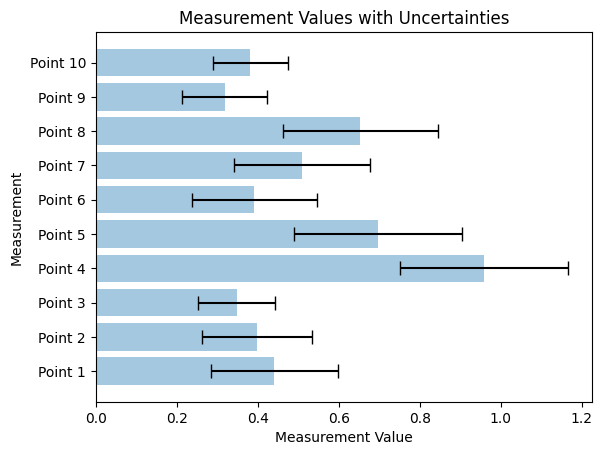

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.25884428946592897, 0.04237679660326585]
KS - WM mean estimate:  0.2522593457504476
KS - Sigma_syst estimate:  0.04237679660326585
KS - Sigma_stat estimate:  0.26364614981635026
KS - Sigma_wm estimate:  0.08699227689572019
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.03728974844623011, 0.00598264137059088]
SWD - WM mean estimate:  0.0354802196061858
SWD - Sigma_syst estimate:  0.00598264137059088
SWD - Sigma_stat estimate:  0.020383013644753593
SWD - Sigma_wm estimate:  0.006419194982053406
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
FN - initial guess:  [0.45982502521653956, 0.12601897097368986]
FN - WM mean estimate:  0.4064631478442869
FN - Sigma_syst estimate:  0.12601897097368986
FN - Sigma_stat estimate:  0.14509313300194476
FN - Sigma_wm estima

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.0552418217551115, 0.017138194332149366]
SWD - WM mean estimate:  0.04461810372273839
SWD - Sigma_syst estimate:  0.017138194332149366
SWD - Sigma_stat estimate:  0.02918846707026538
SWD - Sigma_wm estimate:  0.007698420602379498
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [0.7107492502894232, 0.2162932074371977]
FN - Best MLE estimate:  0.6852658393378751
FN - Sigma_syst estimate:  0.15997768662911127
FN - Sigma_stat estimate:  0.14557346317424774
FN - Sigma_tot estimate:  0.21629723391607714
-.-.-.-.-.-.-.-.

Time - Best initial guess:  [1276.1078770284075, 171.4523599156503]
Time - Best MLE estimate:  1276.1078810446365
Time - Sigma_tot estimate:  171.45235992699614

-----------------------------------------------------------------------
MsplineN bijector
MLE estimates neglig

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


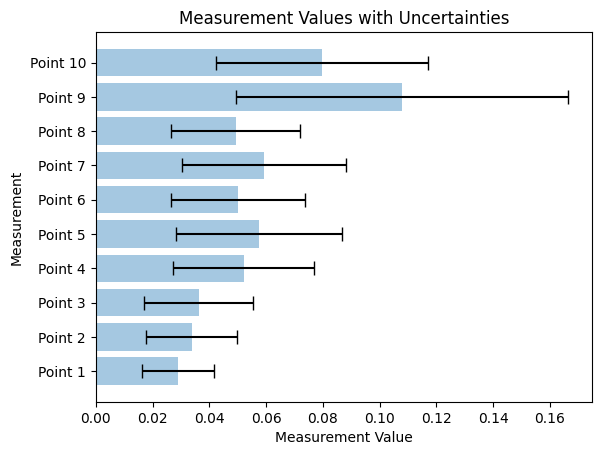

FN - Point 9 is likely an outlier. Deleting it before estimating parameters.
FN - [mean,std] excluding point 9 are [0.6987203093161778, 0.21653049810354053] .
FN - Value of pount 9 is [1.1465568123830432, 0.1041805277461543]
[0.39623539 0.49916907 0.45722096 0.72059061 0.91618039 0.64841993
 1.01936457 0.72756248 1.14655681 0.90373938]
[0.05004519 0.09203811 0.07032384 0.07857058 0.04504622 0.05224039
 0.07466901 0.04812896 0.10418053 0.06094408]


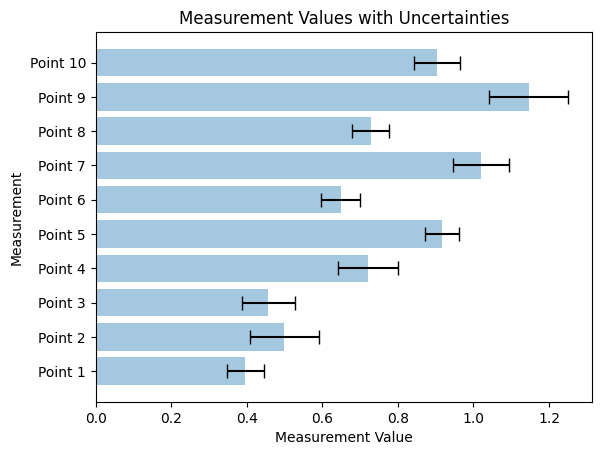

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.12792357356520084, 0.08966028135264019]
KS - WM mean estimate:  0.08293436868105536
KS - Sigma_syst estimate:  0.08966028135264019
KS - Sigma_stat estimate:  0.189666950730674
KS - Sigma_wm estimate:  0.05412298774321071
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.049658965017737866, 0.014616452837636967]
SWD - WM mean estimate:  0.041134786116411325
SWD - Sigma_syst estimate:  0.014616452837636967
SWD - Sigma_stat estimate:  0.023838166281558208
SWD - Sigma_wm estimate:  0.006855938932538669
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [0.6987203093161778, 0.2069928929029918]
FN - Best MLE estimate:  0.7000921774868623
FN - Sigma_syst estimate:  0.19620513053388025
FN - Sigma_stat estimate:  0.063556

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


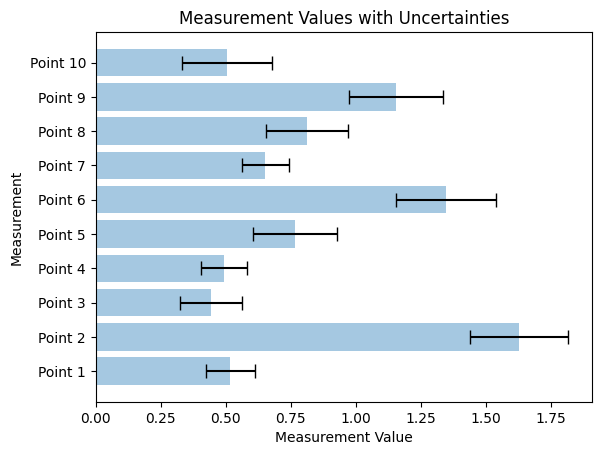

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.24809404977875704, 0.16262872983789506]
KS - WM mean estimate:  0.12209929018456347
KS - Sigma_syst estimate:  0.16262872983789506
KS - Sigma_stat estimate:  0.22481688441779404
KS - Sigma_wm estimate:  0.05808612453624294
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.05616684363069554, 0.026948916360134755]
SWD - WM mean estimate:  0.03954632632831016
SWD - Sigma_syst estimate:  0.026948916360134755
SWD - Sigma_stat estimate:  0.03649640607401239
SWD - Sigma_wm estimate:  0.008887531670336898
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [0.7430238129845492, 0.2995142257591685]
FN - Best MLE estimate:  0.7115475530967551
FN - Sigma_syst estimate:  0.23069600852047192
FN - Sigma_stat estimate:  0.1396463

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


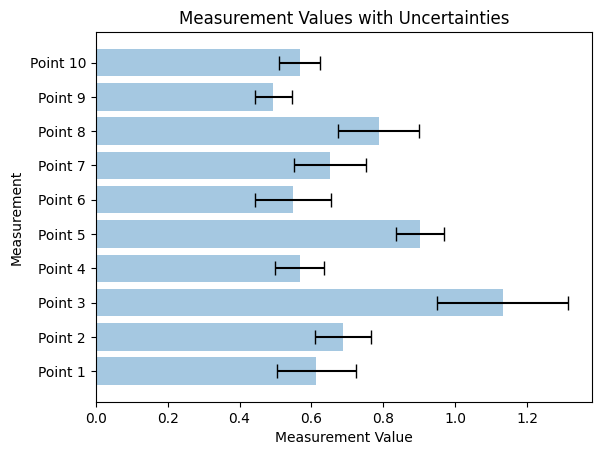

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.22885101094450455, 0.05278050631793715]
KS - WM mean estimate:  0.21655142430089702
KS - Sigma_syst estimate:  0.05278050631793715
KS - Sigma_stat estimate:  0.25578976900708894
KS - Sigma_wm estimate:  0.08369393543124849
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.04121795476226913, 0.007961694002565661]
SWD - WM mean estimate:  0.0383402197954355
SWD - Sigma_syst estimate:  0.007961694002565661
SWD - Sigma_stat estimate:  0.02274001024594529
SWD - Sigma_wm estimate:  0.007074901529422531
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [0.6466565284316198, 0.12159365922649709]
FN - Best MLE estimate:  0.6416261387656609
FN - Sigma_syst estimate:  0.10527594247624285
FN - Sigma_stat estimate:  0.0833146

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


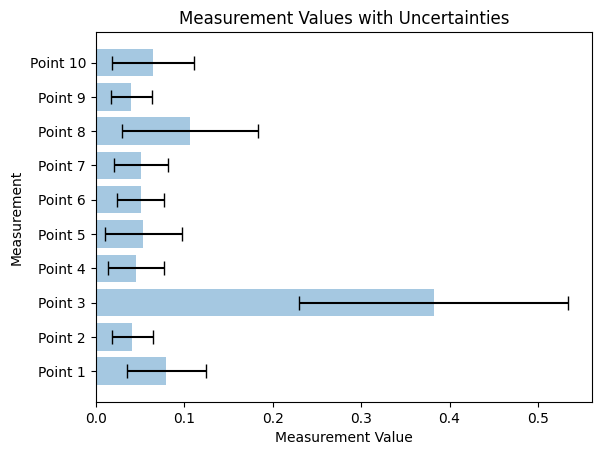

FN - Point 3 is likely an outlier. Deleting it before estimating parameters.
FN - [mean,std] excluding point 3 are [0.9125272158257395, 0.2874438682813643] .
FN - Value of pount 3 is [10.049617163973789, 0.0486125348707233]
[ 1.30466749  0.68256793 10.04961716  0.61808963  1.11278584  0.79695542
  0.77378835  1.33458395  0.77760683  0.8116995 ]
[0.13456304 0.06807617 0.04861253 0.14855229 0.17760036 0.09240223
 0.12243435 0.2163402  0.07927195 0.201529  ]


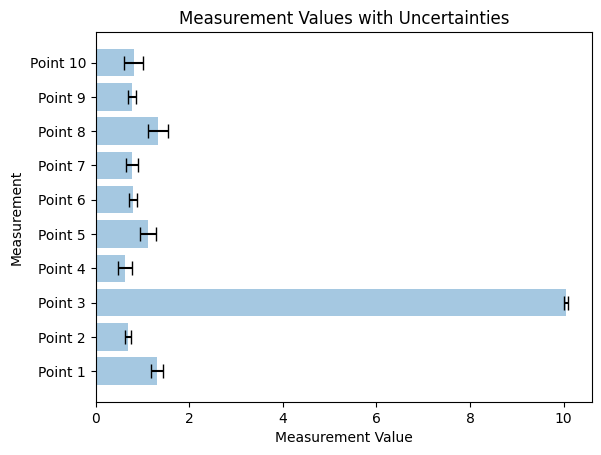

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.16438994416578823, 0.08275331308125326]
KS - WM mean estimate:  0.10158537652768537
KS - Sigma_syst estimate:  0.08275331308125326
KS - Sigma_stat estimate:  0.20650087475746154
KS - Sigma_wm estimate:  0.05738830784843734
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.05922807197402877, 0.020390481703250606]
SWD - WM mean estimate:  0.04950237862118624
SWD - Sigma_syst estimate:  0.020390481703250606
SWD - Sigma_stat estimate:  0.03866249330650022
SWD - Sigma_wm estimate:  0.01065657833519595
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [0.9125272158257395, 0.25222547654235533]
FN - Best MLE estimate:  0.8801577400396812
FN - Sigma_syst estimate:  0.1859932343154996
FN - Sigma_stat estimate:  0.13786328

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


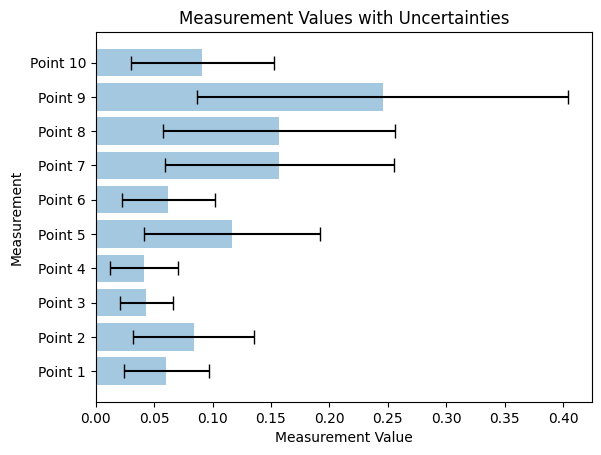

[2.22734854 2.97528863 1.31740242 1.10802382 1.59342631 1.2983582
 2.03779477 2.52512919 2.97811338 3.22963532]
[0.44637105 0.44919389 0.31845081 0.28827187 0.2247908  0.30800852
 0.29106551 0.57261577 0.30085551 0.70135432]


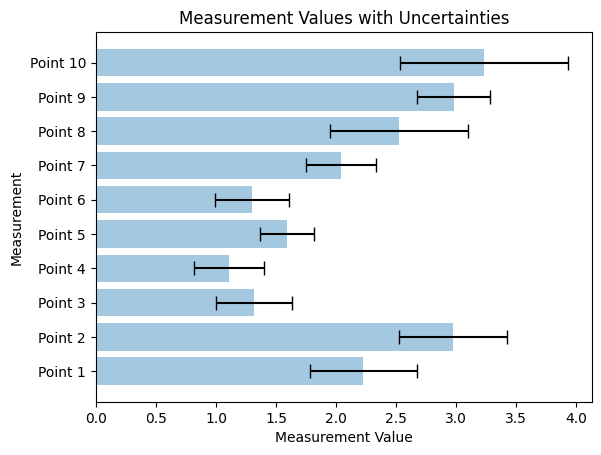

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.11101957104796742, 0.1010652683324179]
KS - WM mean estimate:  0.021369119100073095
KS - Sigma_syst estimate:  0.1010652683324179
KS - Sigma_stat estimate:  0.1510881945416397
KS - Sigma_wm estimate:  0.02466440186770332
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.09029816519813624, 0.04199165945158806]
SWD - WM mean estimate:  0.05924232520795157
SWD - Sigma_syst estimate:  0.04199165945158806
SWD - Sigma_stat estimate:  0.05721309825065492
SWD - Sigma_wm estimate:  0.013566038245810626
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [2.0347119126172344, 0.7226792355293835]
FN - Best MLE estimate:  1.8845020777674053
FN - Sigma_syst estimate:  0.5082489140560621
FN - Sigma_stat estimate:  0.400013616330

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


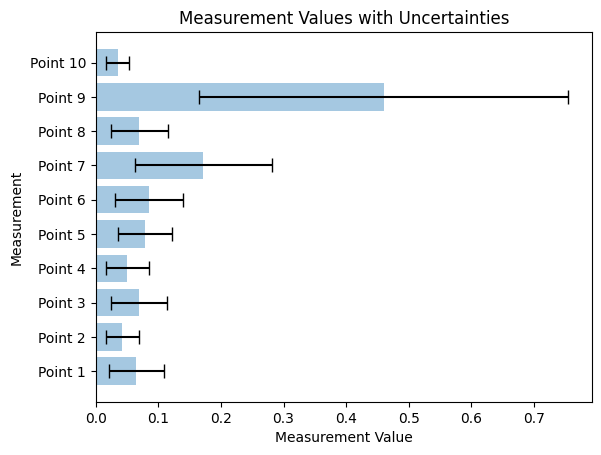

FN - Point 9 is likely an outlier. Deleting it before estimating parameters.
FN - [mean,std] excluding point 9 are [1.8674436292616146, 0.6660408811449797] .
FN - Value of pount 9 is [6.358633618958586, 0.3442868345629619]
[2.01071076 1.16278709 2.08281725 1.07298485 2.29545665 2.19884157
 2.70369447 2.20172121 6.35863362 1.07797881]
[0.43643881 0.31494737 0.44158625 0.1644861  0.31001059 0.40296004
 0.38973428 0.45383038 0.34428683 0.1900217 ]


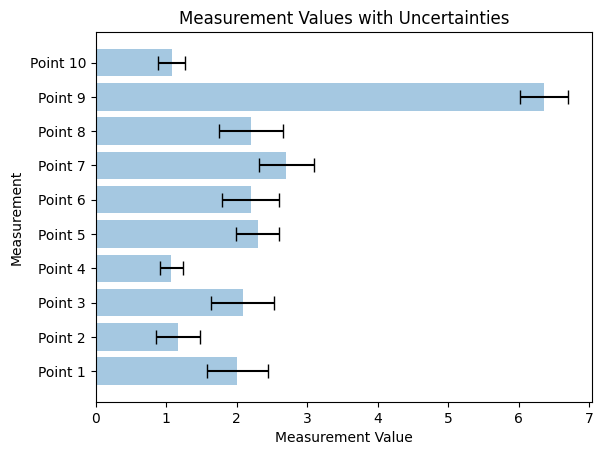

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.11936728302458881, 0.08655387252111715]
KS - WM mean estimate:  0.030835882570617673
KS - Sigma_syst estimate:  0.08655387252111715
KS - Sigma_stat estimate:  0.17531076721897698
KS - Sigma_wm estimate:  0.03172922858337546
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.07396342734250858, 0.0378784999505604]
SWD - WM mean estimate:  0.05133930363947254
SWD - Sigma_syst estimate:  0.0378784999505604
SWD - Sigma_stat estimate:  0.046752024603530666
SWD - Sigma_wm estimate:  0.011505795289587959
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [1.8674436292616146, 0.5697902417579873]
FN - Best MLE estimate:  1.790610444201325
FN - Sigma_syst estimate:  0.5171465408203045
FN - Sigma_stat estimate:  0.34489061418

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


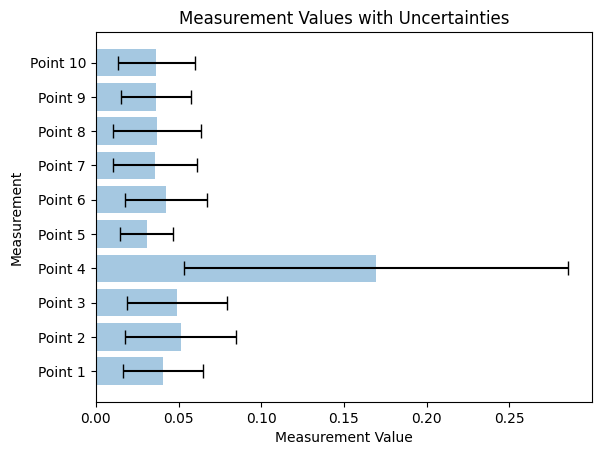

FN - Point 4 is likely an outlier. Deleting it before estimating parameters.
FN - [mean,std] excluding point 4 are [1.0623935818193937, 0.35819341527983917] .
FN - Value of pount 4 is [2.4378506041835943, 0.2489993571108877]
[1.25922018 1.43201635 1.47360341 2.4378506  0.793972   1.20694252
 0.78337843 0.81044484 0.92235961 0.87960491]
[0.36908958 0.42157306 0.34581734 0.24899936 0.14330528 0.27694407
 0.13507139 0.19856903 0.11291184 0.16622685]


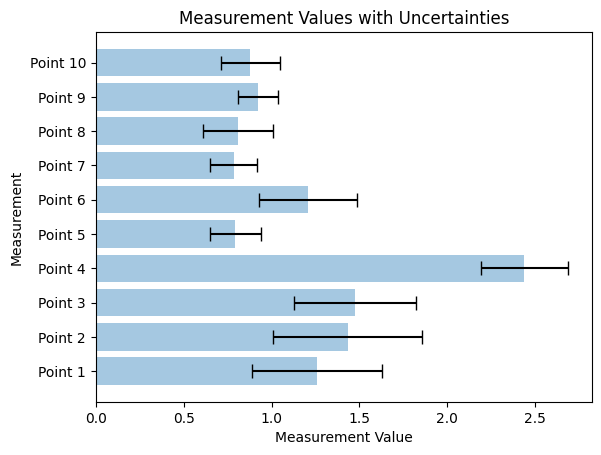

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.3336766851426667, 0.06176847540743108]
KS - WM mean estimate:  0.3270566903745362
KS - Sigma_syst estimate:  0.06176847540743108
KS - Sigma_stat estimate:  0.27439945595537946
KS - Sigma_wm estimate:  0.09095307834912207
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.040007229146544115, 0.006251753170466497]
SWD - WM mean estimate:  0.037779704682404894
SWD - Sigma_syst estimate:  0.006251753170466497
SWD - Sigma_stat estimate:  0.02501102128810022
SWD - Sigma_wm estimate:  0.007837269200784962
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
FN - initial guess:  [1.0623935818193937, 0.26494204924224884]
FN - WM mean estimate:  0.9058233883105353
FN - Sigma_syst estimate:  0.26494204924224884
FN - Sigma_stat estimate:  0.24105649398668583
FN - Sigma_wm esti

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


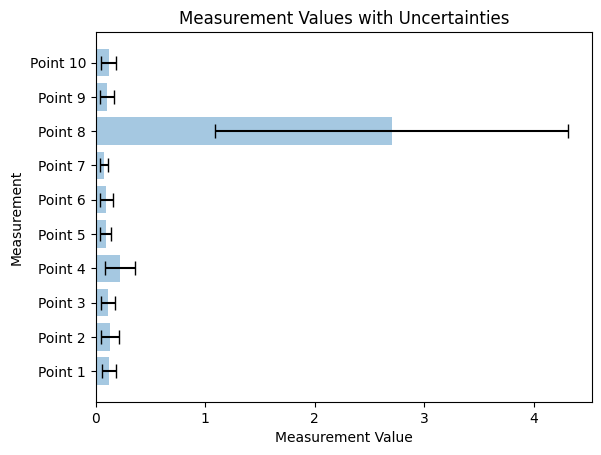

FN - Point 8 is likely an outlier. Deleting it before estimating parameters.
FN - [mean,std] excluding point 8 are [2.929189033139579, 0.6905935928974848] .
FN - Value of pount 8 is [60.19848201990244, 0.2004566949985247]
[ 3.6177912   2.91910267  3.64655588  3.08639435  2.33717565  2.90541779
  2.10968715 60.19848202  2.14033934  3.60023727]
[0.46941172 0.29256796 0.48668806 0.23493972 0.2221166  0.43992106
 0.2990295  0.20045669 0.15976361 0.65916243]


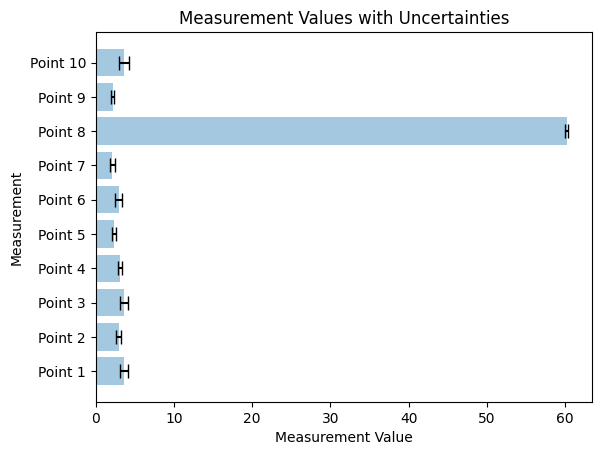

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.0146868885629205, 0.009955484504631013]
KS - WM mean estimate:  0.00686132986426756
KS - Sigma_syst estimate:  0.009955484504631013
KS - Sigma_stat estimate:  0.055384377287738186
KS - Sigma_wm estimate:  0.012637420952118046
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.11847988195503673, 0.03844886170524288]
SWD - WM mean estimate:  0.1001098105742256
SWD - Sigma_syst estimate:  0.03844886170524288
SWD - Sigma_stat estimate:  0.06973004937151255
SWD - Sigma_wm estimate:  0.01976923425387647
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [2.929189033139579, 0.5877283228073377]
FN - Best MLE estimate:  2.7925964267483647
FN - Sigma_syst estimate:  0.44793265533848725
FN - Sigma_stat estimate:  0.362622295

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


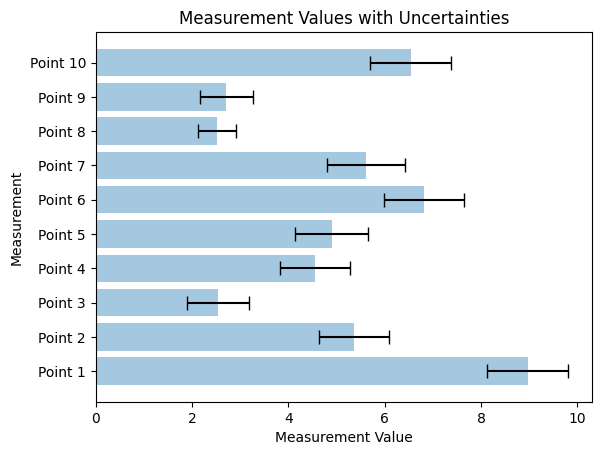

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.0671720773324316, 0.06843513651180426]
KS - WM mean estimate:  0.03326369037732142
KS - Sigma_syst estimate:  0.06843513651180426
KS - Sigma_stat estimate:  0.1346333758724384
KS - Sigma_wm estimate:  0.034340647716053045
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.0922152303256446, 0.022558879713914456]
SWD - WM mean estimate:  0.07334786480370122
SWD - Sigma_syst estimate:  0.022558879713914456
SWD - Sigma_stat estimate:  0.05926621034482747
SWD - Sigma_wm estimate:  0.016735875178097017
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [4.6169706566151865, 1.5853277530929268]
FN - Best MLE estimate:  4.515939364050351
FN - Sigma_syst estimate:  1.4494377380073515
FN - Sigma_stat estimate:  0.69659236684

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


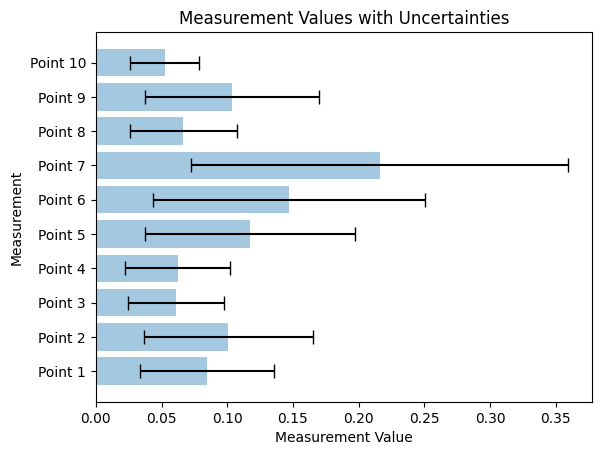

FN - Point 7 is likely an outlier. Deleting it before estimating parameters.
FN - [mean,std] excluding point 7 are [4.312911433812559, 1.5959423647980693] .
FN - Value of pount 7 is [18.52519214061784, 0.8398252899802074]
[ 4.10022639  3.59843714  3.62122028  2.45272853  7.50792006  4.03611585
 18.52519214  3.34202378  6.39324112  3.76428976]
[0.5003621  0.35842718 0.66937029 0.45943502 0.81162951 0.32107784
 0.83982529 0.65433253 0.78385734 0.25348078]


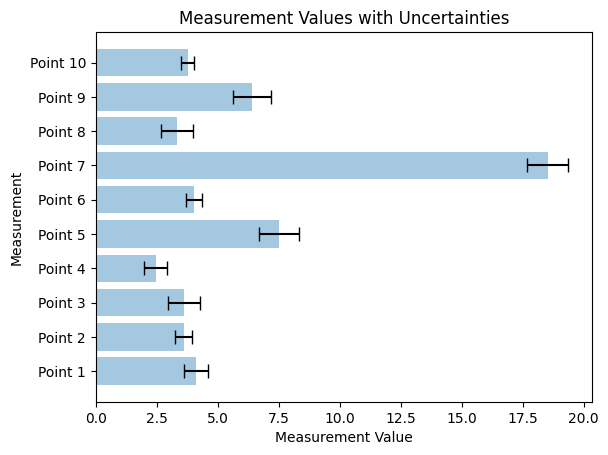

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.06001900703380763, 0.036322520080717464]
KS - WM mean estimate:  0.04200484361317226
KS - Sigma_syst estimate:  0.036322520080717464
KS - Sigma_stat estimate:  0.1337039110356823
KS - Sigma_wm estimate:  0.039629605154886956
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.0884566329775848, 0.029600437029223877]
SWD - WM mean estimate:  0.06916802529491033
SWD - Sigma_syst estimate:  0.029600437029223877
SWD - Sigma_stat estimate:  0.05641311121984586
SWD - Sigma_wm estimate:  0.014822534805293566
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [4.312911433812559, 1.5037176749721994]
FN - Best MLE estimate:  4.199310536815987
FN - Sigma_syst estimate:  1.2209023362189473
FN - Sigma_stat estimate:  0.534663619

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


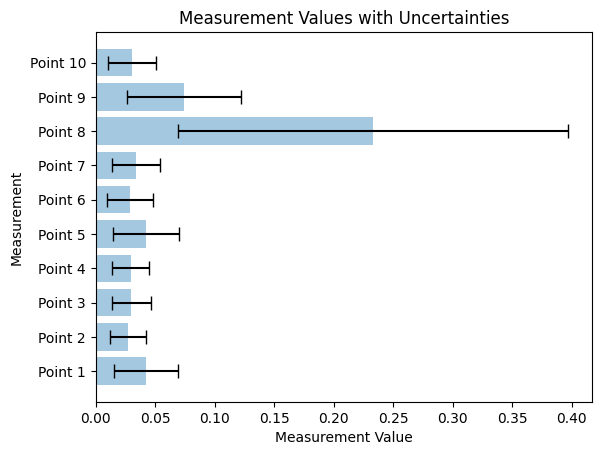

FN - Point 8 is likely an outlier. Deleting it before estimating parameters.
FN - [mean,std] excluding point 8 are [2.224950153524531, 0.9178593427942209] .
FN - Value of pount 8 is [6.411930142206792, 0.4264159540263177]
[1.87991001 1.65974745 1.56960864 1.78471655 3.30173011 1.88997511
 2.37985148 6.41193014 3.38830671 2.17070532]
[0.46486687 0.45269663 0.42208534 0.5715673  0.96082662 0.66597191
 0.79041668 0.42641595 0.82769387 0.74435566]


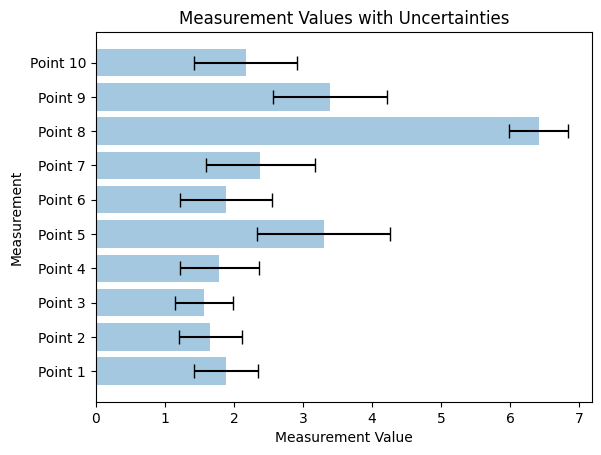

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.40770949916159344, 0.13617898986875354]
KS - WM mean estimate:  0.3413661205091595
KS - Sigma_syst estimate:  0.13617898986875354
KS - Sigma_stat estimate:  0.2690430809101
KS - Sigma_wm estimate:  0.0842817682021764
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.03746764452980385, 0.01402241377682074]
SWD - WM mean estimate:  0.031815807347340776
SWD - Sigma_syst estimate:  0.01402241377682074
SWD - Sigma_stat estimate:  0.023363114253624962
SWD - Sigma_wm estimate:  0.006624419323303574
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
FN - initial guess:  [2.224950153524531, 0.6423726575445206]
FN - WM mean estimate:  1.9550392132145642
FN - Sigma_syst estimate:  0.6423726575445206
FN - Sigma_stat estimate:  0.6556089855957048
FN - Sigma_wm estimate:  0.1

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsa

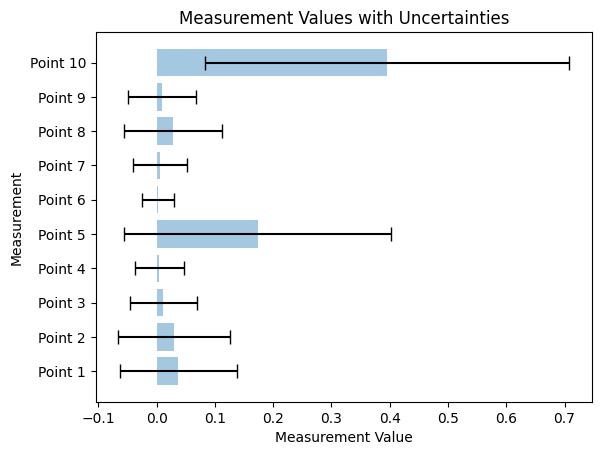

[0.08302342 0.09813457 0.13032919 0.22250496 0.04875051 0.2107764
 0.21636634 0.0918303  0.14480582 0.02622498]
[0.04395457 0.06066869 0.07995627 0.16080058 0.02573177 0.133216
 0.14048425 0.05029216 0.08788556 0.01473775]


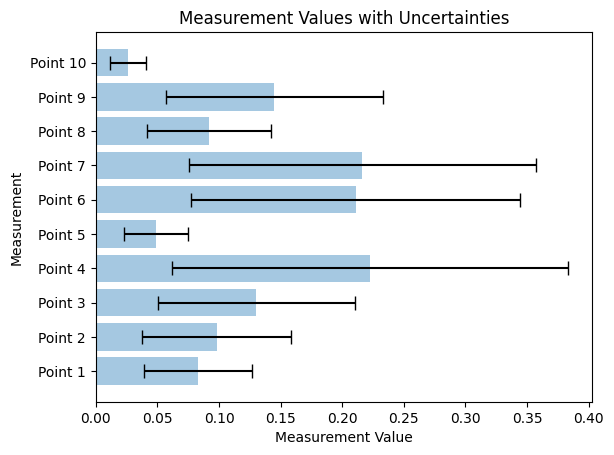

[58.31999934 31.23071785 55.52367376 11.54004905 20.35517011 49.68925489
 54.47120555 35.63296452 52.5658231  10.40033714]
[3.17377981 3.24068524 3.23792367 1.91645317 3.20716518 3.23243005
 3.18699686 3.2284535  3.1630378  0.56540003]


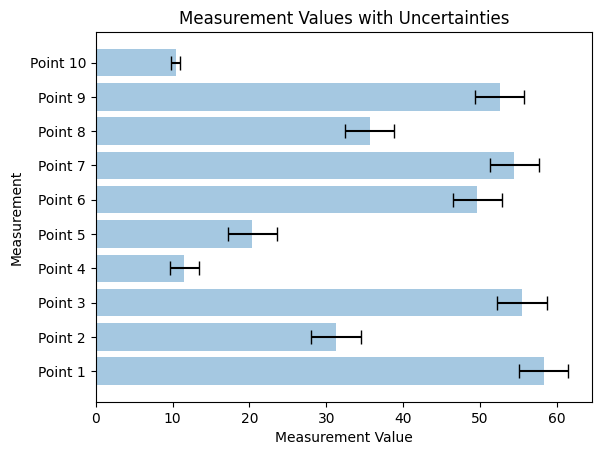

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.03354742052416585, 0.0507731439913863]
KS - WM mean estimate:  0.008708865587443703
KS - Sigma_syst estimate:  0.0507731439913863
KS - Sigma_stat estimate:  0.08228790327856754
KS - Sigma_wm estimate:  0.017358629113609445
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.13850238766944079, 0.06091018441869523]
SWD - WM mean estimate:  0.08000838635847918
SWD - Sigma_syst estimate:  0.06091018441869523
SWD - Sigma_stat estimate:  0.08699887212563422
SWD - Sigma_wm estimate:  0.017884179641134455
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [41.03653979542078, 16.055438361490086]
FN - Best MLE estimate:  40.955015560453226
FN - Sigma_syst estimate:  15.869307028273456
FN - Sigma_stat estimate:  3.06521392113

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype

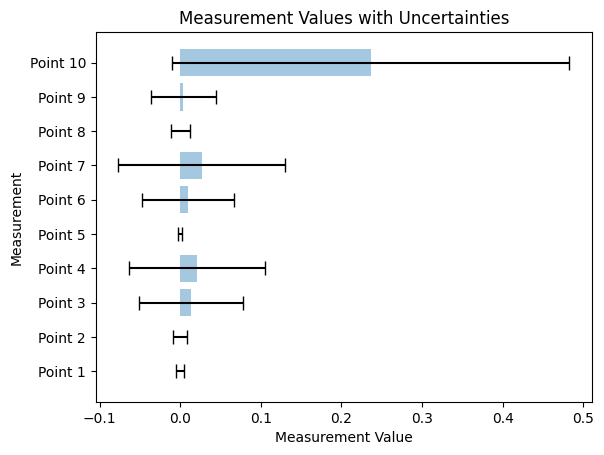

[0.41550221 0.5648001  0.11073752 0.12276484 0.57224781 0.12821176
 0.11773985 0.61314733 0.19853024 0.0449749 ]
[0.21545849 0.34521119 0.06344605 0.08130112 0.34155547 0.0677655
 0.08274337 0.35742901 0.11564182 0.02749993]


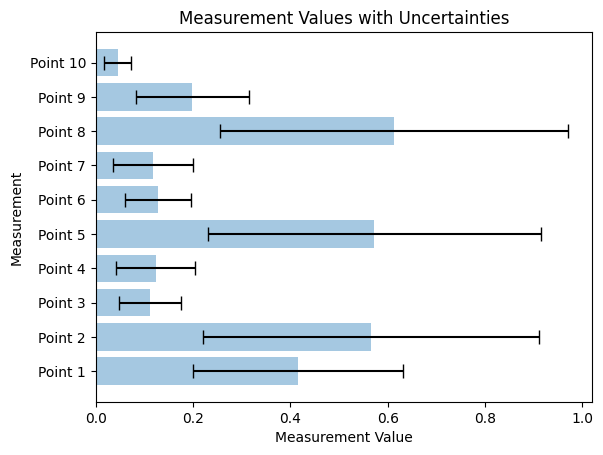

FN - Point 2 is likely an outlier. Deleting it before estimating parameters.
FN - [mean,std] excluding point 2 are [53.61466713867881, 29.782510912471796] .
FN - Value of pount 2 is [119.26004283954757, 4.820146078413915]
[ 87.92610025 119.26004284  25.19315668  37.67086211  98.56098357
  43.65681625  34.04741582  94.87492012  43.99341973  16.60832972]
[2.59361401 4.82014608 3.48238104 4.56178318 3.88131062 1.54946181
 4.71543027 1.22112231 2.19370825 2.13746767]


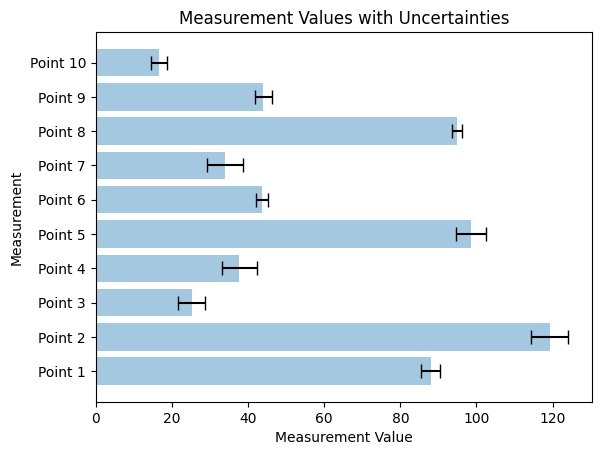

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.009371150127942382, 0.009615608888167709]
KS - WM mean estimate:  0.00012619724753948225
KS - Sigma_syst estimate:  0.009615608888167709
KS - Sigma_stat estimate:  0.04609503628852653
KS - Sigma_wm estimate:  0.001979340730158383
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.2848601943490499, 0.20122929380912982]
SWD - WM mean estimate:  0.1423107962219418
SWD - Sigma_syst estimate:  0.20122929380912982
SWD - Sigma_stat estimate:  0.16566760462377284
SWD - Sigma_wm estimate:  0.03378200289023952
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [58.240459316188215, 28.207406714957987]
FN - Best MLE estimate:  58.33560200083955
FN - Sigma_syst estimate:  28.01384859064962
FN - Sigma_stat estimate:  3.02485143

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


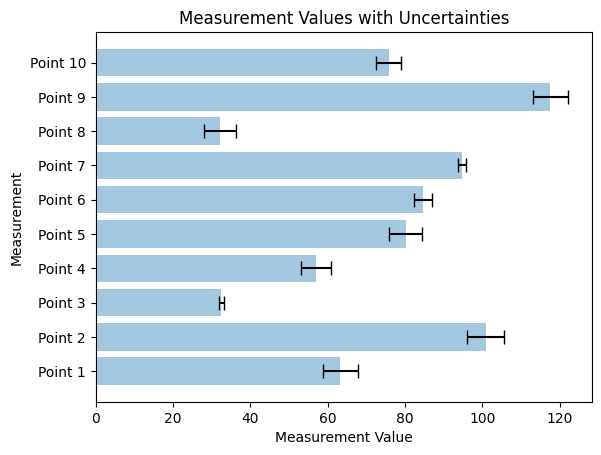

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.0026250470421468777, 0.0033212798724867993]
KS - WM mean estimate:  0.0005286983409926747
KS - Sigma_syst estimate:  0.0033212798724867993
KS - Sigma_stat estimate:  0.0238391988322685
KS - Sigma_wm estimate:  0.003785787001935111
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.265343004107572, 0.08763371120151861]
SWD - WM mean estimate:  0.18074041908145
SWD - Sigma_syst estimate:  0.08763371120151861
SWD - Sigma_stat estimate:  0.16628453604450147
SWD - Sigma_wm estimate:  0.04062221077888496
-.-.-.-.-.-.-.-.

!!!!!!!!!!!!!!!!!!!!!!!!!!
MLE estimates non-negligible systematic uncertainty. Combining uncertainties.
FN - Best initial guess:  [69.02927658471474, 23.482576675083077]
FN - Best MLE estimate:  68.99740150434236
FN - Sigma_syst estimate:  23.283842929334522
FN - Sigma_stat estimate:  3.1822507911

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])


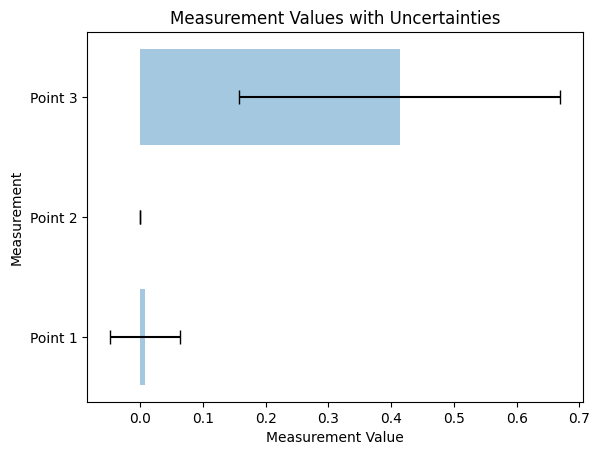

SWD - Point 2 is likely an outlier. Deleting it before estimating parameters.
SWD - [mean,std] excluding point 2 are [0.14172672412519924, 0.14493928652531368] .
SWD - Value of pount 2 is [0.5734698070933711, 0.3462809512451256]
[0.24612311 0.57346981 0.03733034]
[0.17990611 0.34628095 0.02117887]


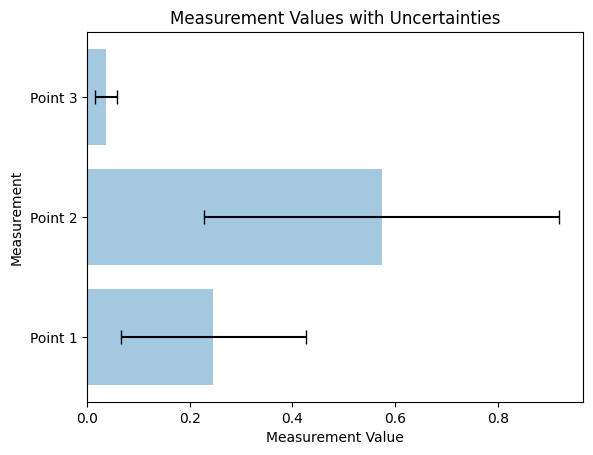

FN - Point 2 is likely an outlier. Deleting it before estimating parameters.
FN - [mean,std] excluding point 2 are [37.50661822411756, 28.391458277565874] .
FN - Value of pount 2 is [146.4766067153517, 3.1153937277947046]
FN - Point 3 is likely an outlier. Deleting it before estimating parameters.
FN - [mean,std] excluding point 3 are [106.14330290629252, 40.4463637990734] .
FN - Value of pount 3 is [9.203237351001754, 1.5404835131982682]
[ 65.8099991  146.47660672   9.20323735]
[2.92875995 3.11539373 1.54048351]


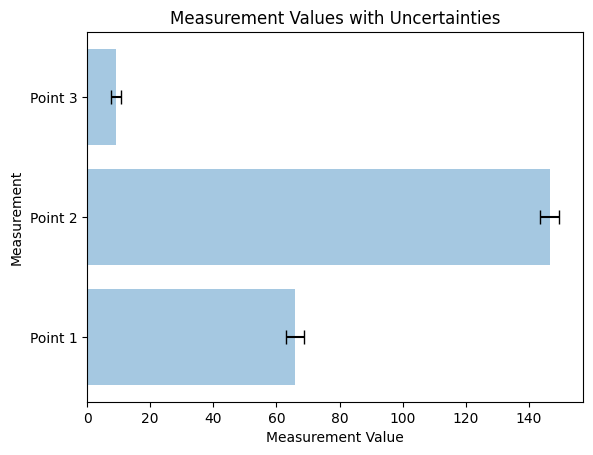

MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
KS - initial guess:  [0.0076200020892635, 0.0]
KS - WM mean estimate:  0.007620002089263501
KS - Sigma_syst estimate:  0.0
KS - Sigma_stat estimate:  0.0561502969160367
KS - Sigma_wm estimate:  0.0561502969160367
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
SWD - initial guess:  [0.2461231051407361, 0.0]
SWD - WM mean estimate:  0.2461231051407361
SWD - Sigma_syst estimate:  0.0
SWD - Sigma_stat estimate:  0.1799061068647828
SWD - Sigma_wm estimate:  0.1799061068647828
-.-.-.-.-.-.-.-.
MLE estimates negligible systematic uncertainty. Computing weighted mean and std.
FN - initial guess:  [65.80999909723336, 0.0]
FN - WM mean estimate:  65.80999909723336
FN - Sigma_syst estimate:  0.0
FN - Sigma_stat estimate:  2.928759947660111
FN - Sigma_wm estimate:  2.928759947660111
-.-.-.-.-.-.-.-.
Time - Best initial guess:  [16526.053427842293, 2611.3901383907255

/tmp/ipykernel_50/3470822963.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rtorre/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsa

In [494]:
outlier_threshold = 2
for ndims in [4,8,16,32,64,100,200,400,1000]:
    print("\n=======================================================================")
    print("Getting best estimates in",ndims,"dimensions through maximum likelihood")
    for bijector in ["MAFN","RealNVPN","MsplineN","CsplineN"]:
        print("\n-----------------------------------------------------------------------")
        print(bijector,"bijector")
        df_reduced = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims][df_correlated_unc["bijector"]==bijector])
        ### Check for outliers
        to_delete=[]
        ks = df_reduced[["ks_mean","ks_std"]].to_numpy()
        measurements = ks[:,0]
        uncertainties = ks[:,1]
        for i in range(len(measurements)):
            m = np.delete(measurements,i)
            u = np.delete(uncertainties,i)
            mean_not_i = np.mean(m)
            std_not_i = np.sqrt(np.std(m)**2+np.mean(u)**2)
            if measurements[i]>mean_not_i+outlier_threshold*std_not_i or measurements[i]<mean_not_i-outlier_threshold*std_not_i:
                print("KS - Point",i+1,"is likely an outlier. Deleting it before estimating parameters.")
                print("KS - [mean,std] excluding point",i+1,"are",[mean_not_i,std_not_i],".")
                print("KS - Value of pount",i+1,"is",[measurements[i],uncertainties[i]])
                to_delete.append(i)
        if to_delete != []:
            print(measurements)
            print(uncertainties)
            plot_measurements(measurements,uncertainties)
        to_delete = np.unique(to_delete).tolist()
        swd = df_reduced[["swd_mean","swd_std"]].to_numpy()
        measurements = swd[:,0]
        uncertainties = swd[:,1]
        for i in range(len(measurements)):
            m = np.delete(measurements,i)
            u = np.delete(uncertainties,i)
            mean_not_i = np.mean(m)
            std_not_i = np.sqrt(np.std(m)**2+np.mean(u)**2)
            if measurements[i]>mean_not_i+outlier_threshold*std_not_i or measurements[i]<mean_not_i-outlier_threshold*std_not_i:
                print("SWD - Point",i+1,"is likely an outlier. Deleting it before estimating parameters.")
                print("SWD - [mean,std] excluding point",i+1,"are",[mean_not_i,std_not_i],".")
                print("SWD - Value of pount",i+1,"is",[measurements[i],uncertainties[i]])
                to_delete.append(i)
        if to_delete != []:
            print(measurements)
            print(uncertainties)
            plot_measurements(measurements,uncertainties)
        to_delete = np.unique(to_delete).tolist()
        fn = df_reduced[["fn_mean","fn_std"]].to_numpy()
        measurements = fn[:,0]
        uncertainties = fn[:,1]
        for i in range(len(measurements)):
            m = np.delete(measurements,i)
            u = np.delete(uncertainties,i)
            mean_not_i = np.mean(m)
            std_not_i = np.sqrt(np.std(m)**2+np.mean(u)**2)
            if measurements[i]>mean_not_i+outlier_threshold*std_not_i or measurements[i]<mean_not_i-outlier_threshold*std_not_i:
                print("FN - Point",i+1,"is likely an outlier. Deleting it before estimating parameters.")
                print("FN - [mean,std] excluding point",i+1,"are",[mean_not_i,std_not_i],".")
                print("FN - Value of pount",i+1,"is",[measurements[i],uncertainties[i]])
                to_delete.append(i)
        if to_delete != []:
            print(measurements)
            print(uncertainties)
            plot_measurements(measurements,uncertainties)
        to_delete = np.unique(to_delete).tolist()
        ### KS
        ks = df_reduced[["ks_mean","ks_std"]].to_numpy()
        measurements = ks[:,0]
        uncertainties = ks[:,1]
        measurements=np.delete(measurements,to_delete)
        uncertainties=np.delete(uncertainties,to_delete)
        mean = np.mean(measurements)
        sigma_stat = np.mean(uncertainties)
        sigma_0 = np.std(measurements)
        initial_guess = [mean, sigma_0]
        result = minimize(neg_log_likelihood, initial_guess, args=(measurements, uncertainties), method='Powell',options={"maxiter": 100000,"xtol":1e-12,"ftol":1e-12})
        mu_mle, sigma_syst = result.x
        if sigma_syst<0.1*sigma_stat:
            print("MLE estimates negligible systematic uncertainty. Computing weighted mean and std.")
            weights = 1/(uncertainties**2)
            mu_wm = np.dot(measurements,weights)/np.sum(weights)
            sigms_wm = 1/np.sqrt(np.sum(weights))
            print('KS - initial guess: ', initial_guess)
            print('KS - WM mean estimate: ', mu_wm)
            print('KS - Sigma_syst estimate: ', sigma_0)
            print('KS - Sigma_stat estimate: ', sigma_stat)
            print('KS - Sigma_wm estimate: ', sigms_wm)
            print('-.-.-.-.-.-.-.-.')
        else:
            print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("MLE estimates non-negligible systematic uncertainty. Combining uncertainties.")
            sigma_tot_mle = np.sqrt(sigma_syst**2+sigma_stat**2)
            print('KS - Best initial guess: ', initial_guess)
            print('KS - Best MLE estimate: ', mu_mle)
            print('KS - Sigma_syst estimate: ', sigma_syst)
            print('KS - Sigma_stat estimate: ', sigma_stat)
            print('KS - Sigma_tot estimate: ', sigma_tot_mle)
            print('-.-.-.-.-.-.-.-.\n')
        ## SWD
        swd = df_reduced[["swd_mean","swd_std"]].to_numpy()
        measurements = swd[:,0]
        uncertainties = swd[:,1]
        measurements=np.delete(measurements,to_delete)
        uncertainties=np.delete(uncertainties,to_delete)
        mean = np.mean(measurements)
        sigma_stat = np.mean(uncertainties)
        sigma_0 = np.std(measurements)
        initial_guess = [mean, sigma_0]
        result = minimize(neg_log_likelihood, initial_guess, args=(measurements, uncertainties), method='Powell',options={"maxiter": 100000,"xtol":1e-12,"ftol":1e-12})
        mu_mle, sigma_syst = result.x
        if sigma_syst<0.1*sigma_stat:
            print("MLE estimates negligible systematic uncertainty. Computing weighted mean and std.")
            weights = 1/(uncertainties**2)
            mu_wm = np.dot(measurements,weights)/np.sum(weights)
            sigms_wm = 1/np.sqrt(np.sum(weights))
            print('SWD - initial guess: ', initial_guess)
            print('SWD - WM mean estimate: ', mu_wm)
            print('SWD - Sigma_syst estimate: ', sigma_0)
            print('SWD - Sigma_stat estimate: ', sigma_stat)
            print('SWD - Sigma_wm estimate: ', sigms_wm)
            print('-.-.-.-.-.-.-.-.')
        else:
            print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("MLE estimates non-negligible systematic uncertainty. Combining uncertainties.")
            sigma_tot_mle = np.sqrt(sigma_syst**2+sigma_stat**2)
            print('SWD - Best initial guess: ', initial_guess)
            print('SWD - Best MLE estimate: ', mu_mle)
            print('SWD - Sigma_syst estimate: ', sigma_syst)
            print('SWD - Sigma_stat estimate: ', sigma_stat)
            print('SWD - Sigma_tot estimate: ', sigma_tot_mle)
            print('-.-.-.-.-.-.-.-.\n')
        ### FN
        fn = df_reduced[["fn_mean","fn_std"]].to_numpy()
        measurements = fn[:,0]
        uncertainties = fn[:,1]
        measurements=np.delete(measurements,to_delete)
        uncertainties=np.delete(uncertainties,to_delete)
        mean = np.mean(measurements)
        sigma_stat = np.mean(uncertainties)
        sigma_0 = np.std(measurements)
        initial_guess = [mean, sigma_0]
        result = minimize(neg_log_likelihood, initial_guess, args=(measurements, uncertainties), method='Powell',options={"maxiter": 100000,"xtol":1e-12,"ftol":1e-12})
        mu_mle, sigma_syst = result.x
        if sigma_syst<0.1*sigma_stat:
            print("MLE estimates negligible systematic uncertainty. Computing weighted mean and std.")
            weights = 1/(uncertainties**2)
            mu_wm = np.dot(measurements,weights)/np.sum(weights)
            sigms_wm = 1/np.sqrt(np.sum(weights))
            print('FN - initial guess: ', initial_guess)
            print('FN - WM mean estimate: ', mu_wm)
            print('FN - Sigma_syst estimate: ', sigma_0)
            print('FN - Sigma_stat estimate: ', sigma_stat)
            print('FN - Sigma_wm estimate: ', sigms_wm)
            print('-.-.-.-.-.-.-.-.')
        else:
            print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("MLE estimates non-negligible systematic uncertainty. Combining uncertainties.")
            sigma_tot_mle = np.sqrt(sigma_syst**2+sigma_stat**2)
            print('FN - Best initial guess: ', initial_guess)
            print('FN - Best MLE estimate: ', mu_mle)
            print('FN - Sigma_syst estimate: ', sigma_syst)
            print('FN - Sigma_stat estimate: ', sigma_stat)
            print('FN - Sigma_tot estimate: ', sigma_tot_mle)
            print('-.-.-.-.-.-.-.-.\n')
        ### TIME
        time = df_reduced["time"].to_numpy()
        measurements = time
        uncertainties = None
        mean = np.mean(measurements)
        sigma_0 = np.std(measurements)
        initial_guess = [mean, sigma_0]
        result = minimize(neg_log_likelihood, initial_guess, args=(measurements, None),method='Powell')
        mu_mle = result.x[0]
        sigma_tot_mle = result.x[1]
        print('Time - Best initial guess: ', initial_guess)
        print('Time - Best MLE estimate: ', mu_mle)
        print('Time - Sigma_tot estimate: ', sigma_tot_mle)

SWD - Maximum Likelihood Estimation (MLE):  0.0301333226607809
SWD - 1sigma uncertainty:  0.006429830020876331


FN - Maximum Likelihood Estimation (MLE):  0.03460598506848076
FN - 1sigma uncertainty:  0.011350725370580572


## Global metrics

In [495]:
def recompute_metrics(run):
    print("Recomputing metrics for run",run.replace("results.txt",""),".")
    start_all=timer()
    tmp = pd.read_csv(run)
    X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
    np.shape(X_data_nf)
    run_n=int(tmp["run_n"])
    run_seed=int(tmp["run_seed"])
    ndims=int(tmp["ndims"])
    nsamples=int(tmp["nsamples"])
    correlation=str(tmp["correlation"][0])
    nbijectors=int(tmp["nbijectors"])
    bijector=str(tmp["bijector"][0])
    activation=str(tmp["activation"][0])
    spline_knots=int(tmp["spline_knots"])
    range_min=int(tmp["range_min"])
    eps_regulariser=tmp["eps_regulariser"][0]
    regulariser=tmp["regulariser"][0]
    hidden_layers=str(tmp["hidden_layers"][0])
    batch_size=int(tmp["batch_size"])
    epochs_input=int(tmp["epochs_input"])
    epochs_output=int(tmp["epochs_output"])
    time=tmp["time"][0]
    ncomp=3
    ntest_samples=nsamples
    seed_dist = 0
    seed_test = 0
    targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    start=timer()
    ks_mean,ks_std,ks_list,ad_mean,ad_std,ad_list,wd_mean,wd_std,wd_list,swd_mean,swd_std,swd_list,fn_mean,fn_std,fn_list=Metrics.ComputeMetrics(X_data_test,X_data_nf)
    results_dict = {'run_n': [run_n],
                    'run_seed': [run_seed],
                    'ndims':[ndims],
                    'nsamples':[nsamples],
                    'correlation':[correlation],
                    'nbijectors':[nbijectors],
                    'bijector':[bijector],
                    'activation':[activation],
                    'spline_knots':[spline_knots],
                    'range_min':[range_min],
                    'eps_regulariser':[eps_regulariser],
                    'regulariser':[regulariser],
                    'ks_mean':[ks_mean],
                    'ks_std':[ks_std],
                    'ad_mean':[ad_mean],
                    'ad_std':[ad_std],
                    'wd_mean':[wd_mean],
                    'wd_std':[wd_std],
                    'swd_mean':[swd_mean],
                    'swd_std':[swd_std],
                    'fn_mean':[fn_mean],
                    'fn_std':[fn_std],
                    'hidden_layers':[hidden_layers],
                    'batch_size':[batch_size],
                    'epochs_input':[epochs_input],
                    'epochs_output':[epochs_output],
                    'time':[time]}
    #os.rename(run, run.replace(".txt","_old.txt"))
    Utils.results_current(run.replace("results.txt",""),results_dict)
    tmp_new = pd.read_csv(run)
    end=timer()
    print("Metrics for run",run.replace("results.txt",""),"computed and saved in",end-start,"s.")
    return tmp_new

## Correlation of metrics

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


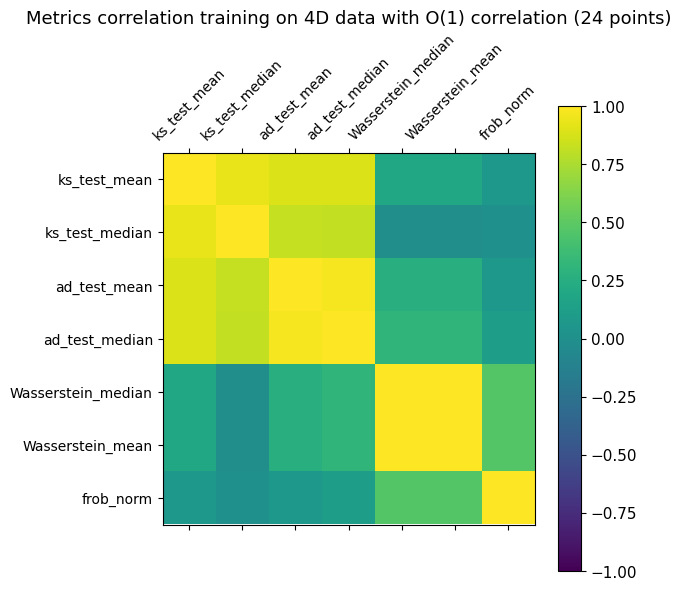

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


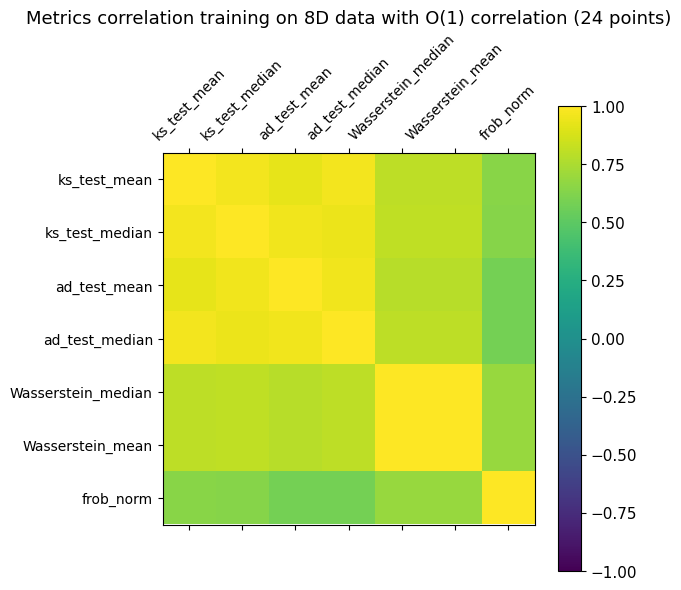

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


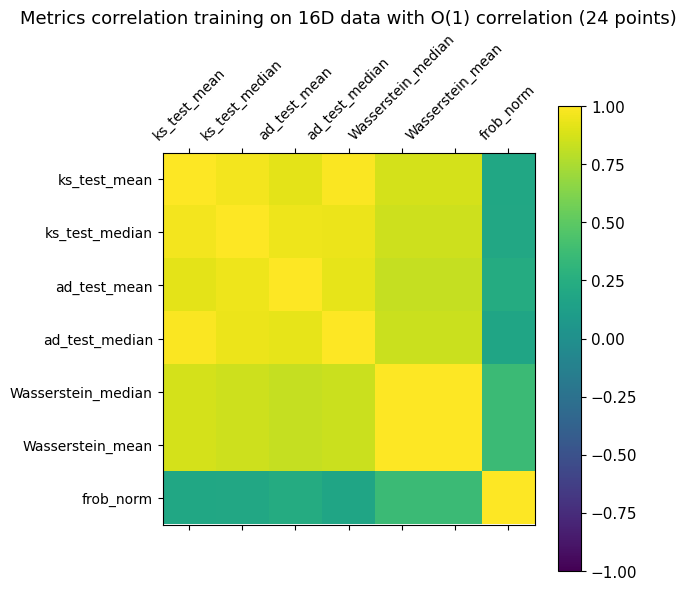

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


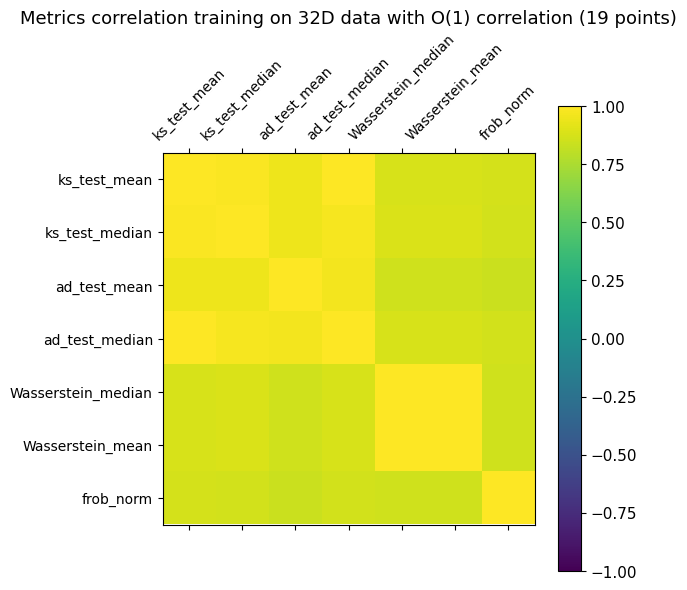

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


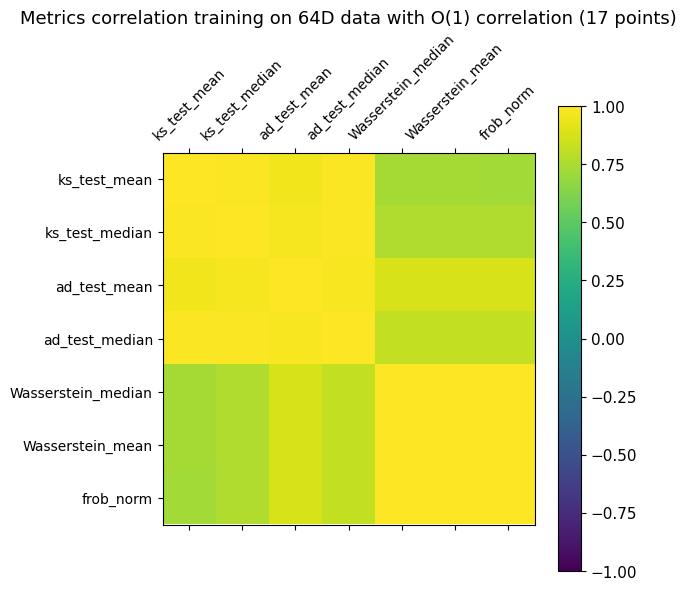

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


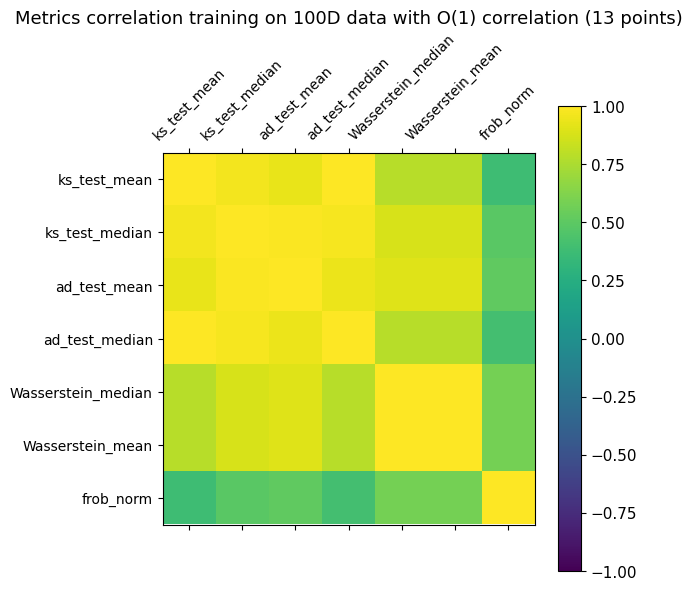

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


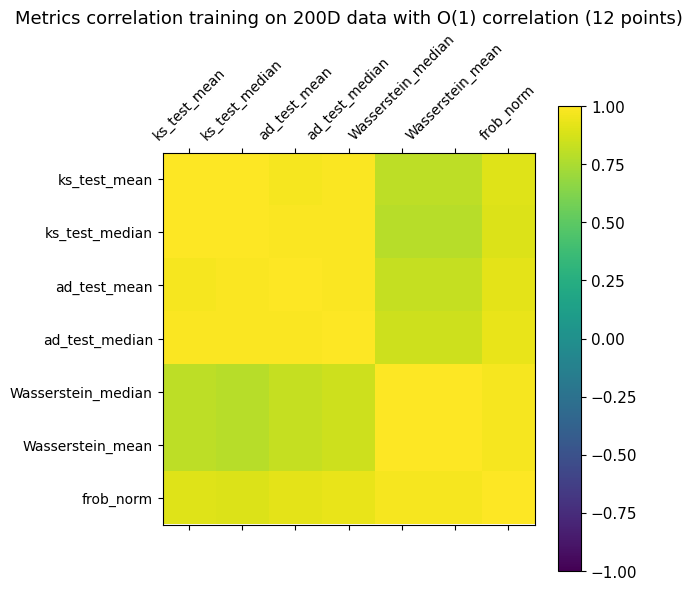

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


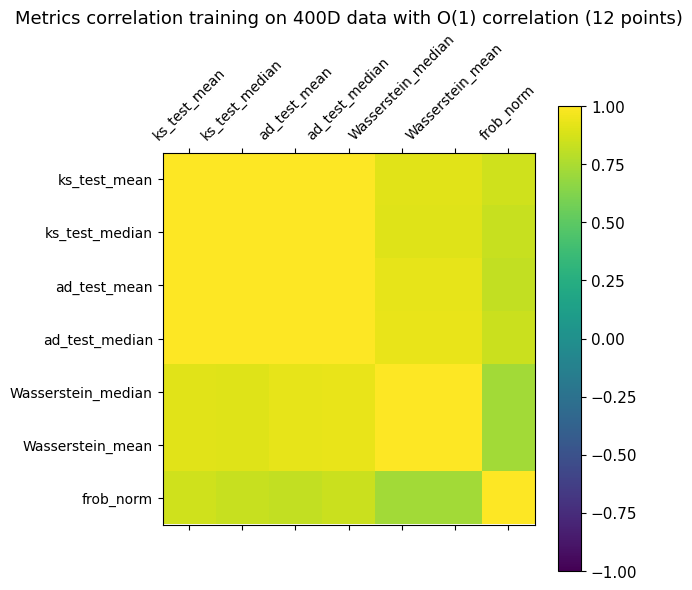

/tmp/ipykernel_6400/3652645851.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]


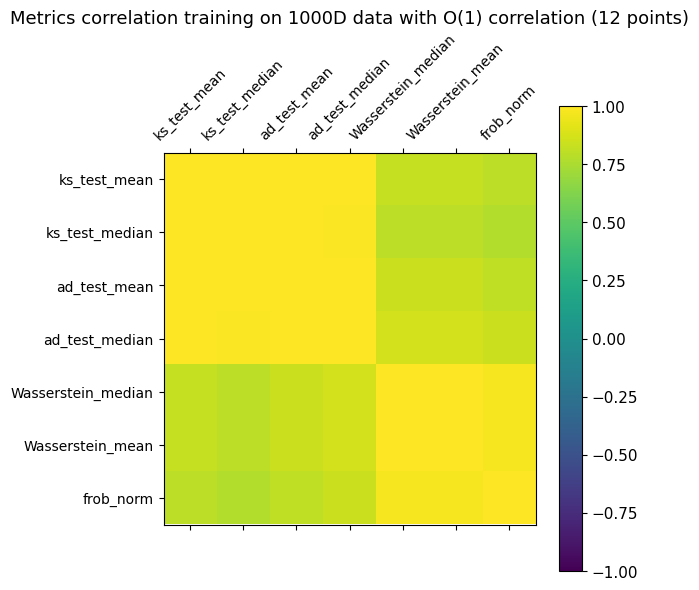

In [19]:
styles = [dict(selector="caption",
            props=[("text-align", "center"),
                   ("font-size", "150%"),
                   ("color", 'lime')])]
metrics = ["ks_test_mean", "ks_test_median","ad_test_mean", "ad_test_median","Wasserstein_median", "Wasserstein_mean","frob_norm"]
for d in [4,8,16,32,64,100,200,400,1000]:
    df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="corr"][metrics]
    df=df.astype(float)
    n_points=len(df)
    df['Wasserstein_median'] = df['Wasserstein_median'].apply(lambda x: -x)
    df['Wasserstein_mean'] = df['Wasserstein_mean'].apply(lambda x: -x)
    df['frob_norm'] = df['frob_norm'].apply(lambda x: -x)
    #display(df)
    title = "Metrics correlation training on "+str(d)+"D data with O(1) correlation ("+str(n_points)+" points)"
    corr=df.corr()
    display(corr.style.set_caption(title).set_table_styles(styles))
    jtplot.reset()
    f = plt.figure(figsize=(6, 6))
    plt.matshow(corr, fignum=f.number)
    plt.xticks(range(df.select_dtypes(['number']).shape[1]), metrics, fontsize=10, rotation=45)
    plt.yticks(range(df.select_dtypes(['number']).shape[1]), metrics, fontsize=10)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=11)
    plt.clim(-1, 1) 
    plt.title(title, fontsize=13)
    plt.show()
    plt.close()
    del(df)

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


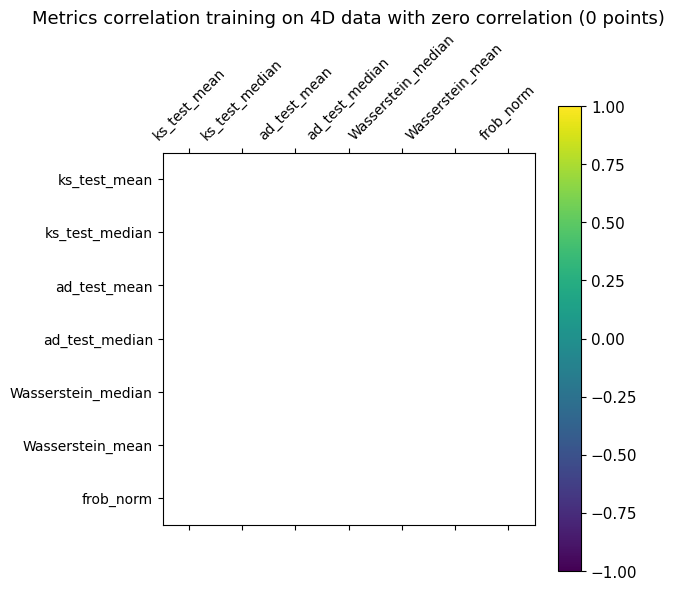

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


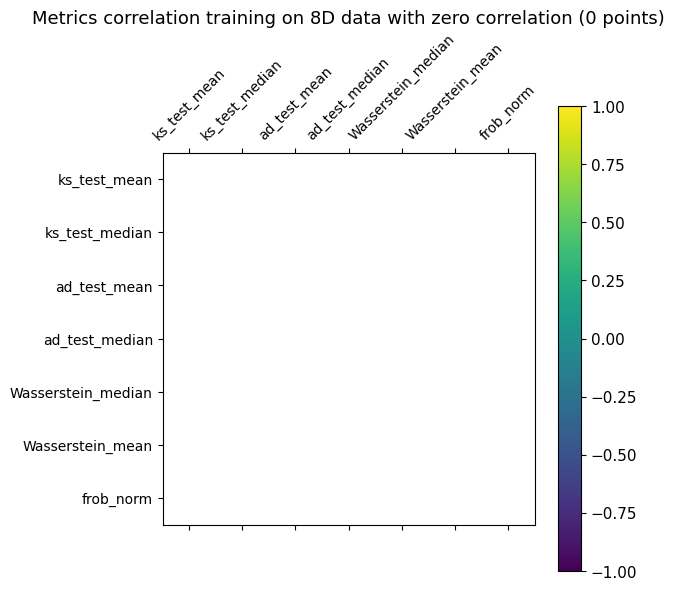

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


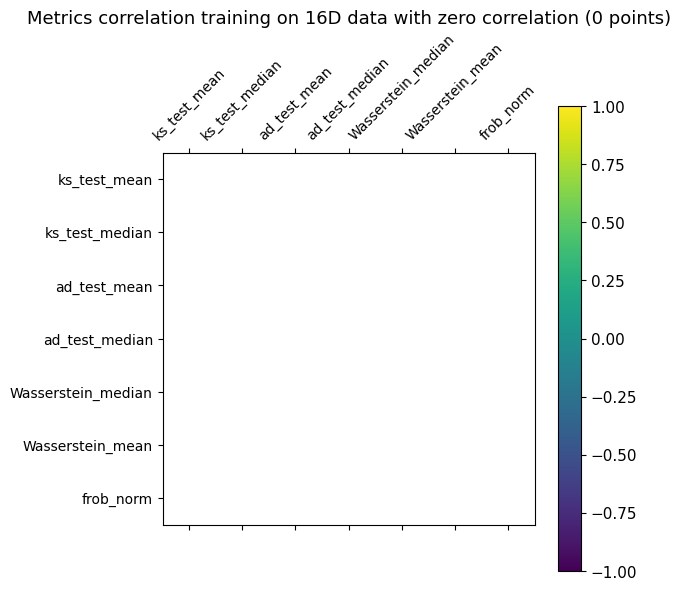

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


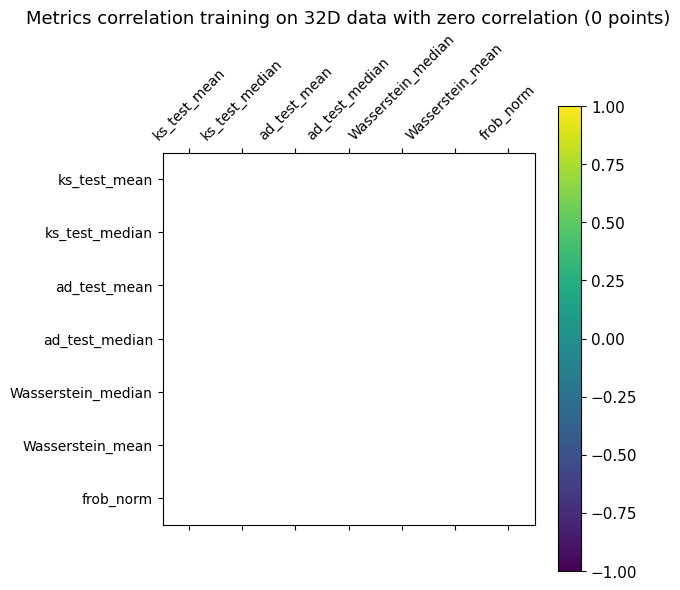

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


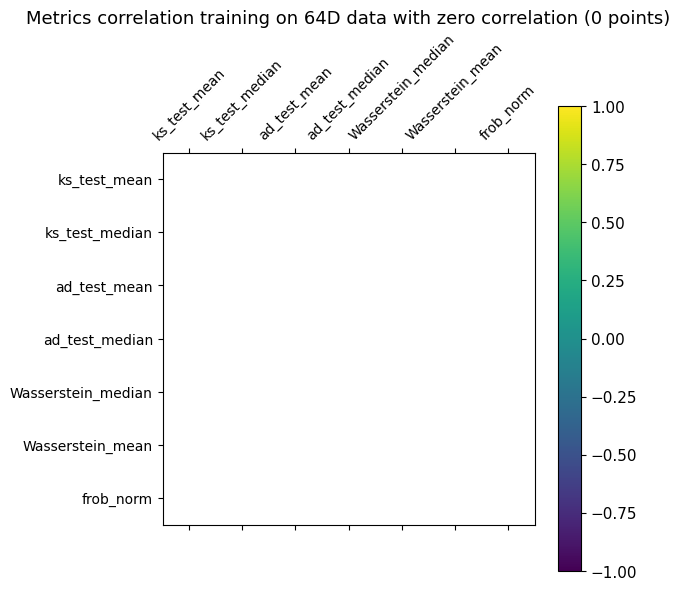

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


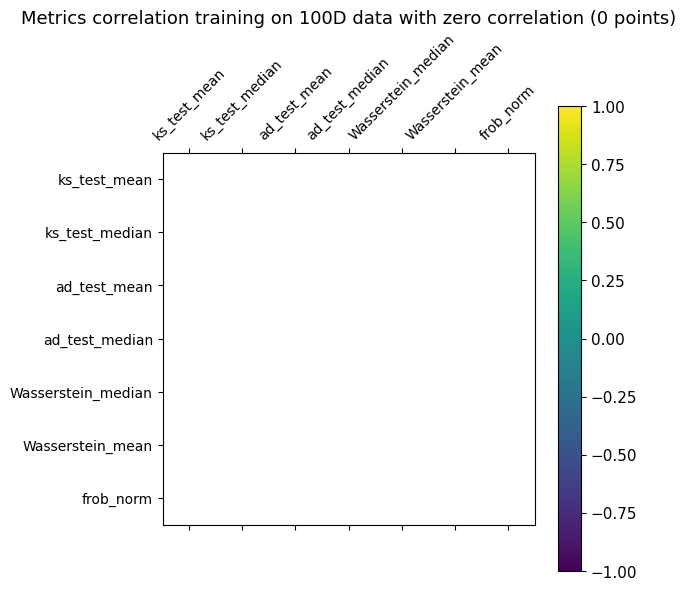

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


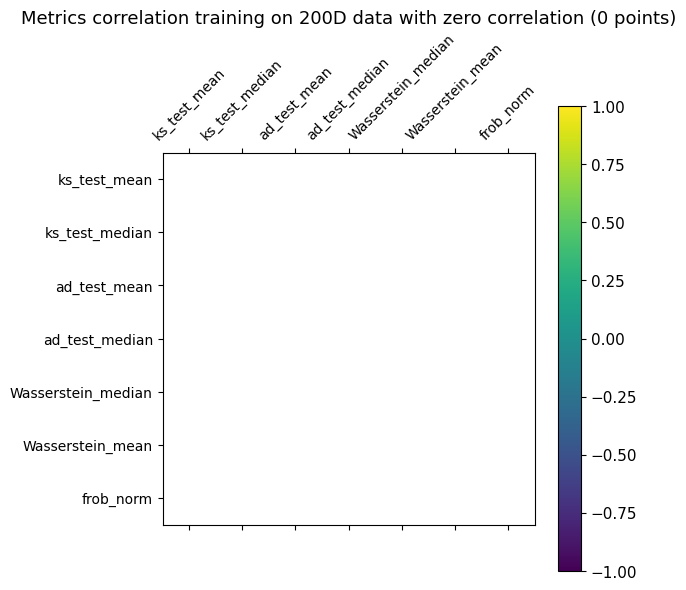

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


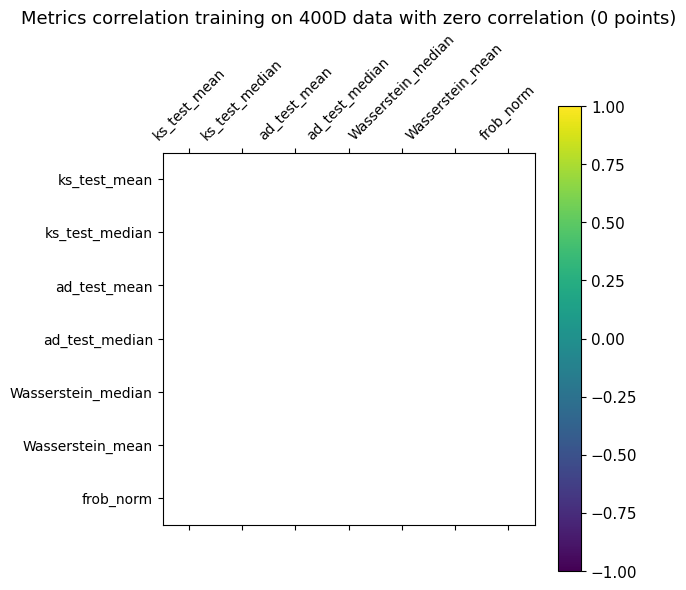

/tmp/ipykernel_6400/886712643.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]


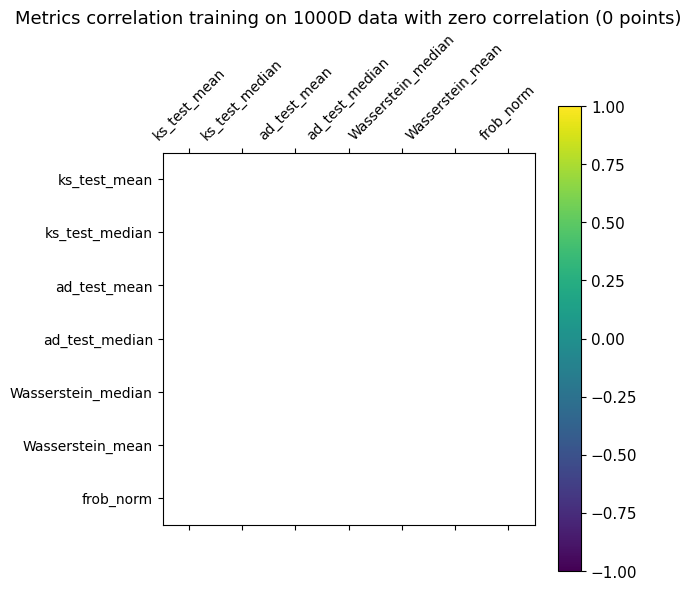

In [20]:
styles = [dict(selector="caption",
            props=[("text-align", "center"),
                   ("font-size", "150%"),
                   ("color", 'lime')])]
metrics = ["ks_test_mean", "ks_test_median","ad_test_mean", "ad_test_median","Wasserstein_median", "Wasserstein_mean","frob_norm"]
for d in [4,8,16,32,64,100,200,400,1000]:
    df=df_correlated[df_correlated["ndims"]==d][df_correlated["correlation"]=="uncorr"][metrics]
    df=df.astype(float)
    n_points=len(df)
    df['Wasserstein_median'] = df['Wasserstein_median'].apply(lambda x: -x)
    df['Wasserstein_mean'] = df['Wasserstein_mean'].apply(lambda x: -x)
    df['frob_norm'] = df['frob_norm'].apply(lambda x: -x)
    #display(df)
    title = "Metrics correlation training on "+str(d)+"D data with zero correlation ("+str(n_points)+" points)"
    corr=df.corr()
    display(corr.style.set_caption(title).set_table_styles(styles))
    jtplot.reset()
    f = plt.figure(figsize=(6, 6))
    plt.matshow(corr, fignum=f.number)
    plt.xticks(range(df.select_dtypes(['number']).shape[1]), metrics, fontsize=10, rotation=45)
    plt.yticks(range(df.select_dtypes(['number']).shape[1]), metrics, fontsize=10)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=11)
    plt.clim(-1, 1) 
    plt.title(title, fontsize=13)
    plt.show()
    plt.close()
    del(df)

## Results for different dimensions and metrics

In [25]:
#ascending=True
#pd.set_option('display.max_colwidth', 100)
#pd.set_option('display.max_rows', None)
#df_reduced_sorted = {}
#df_reduced_unc = {}
#df_best_corr = {}
#ndims_list = [4,8,16,32,64,100,200,400,1000]
#sort_metrics_list = ["swd_mean","ks_mean"]
#for sort_metric in sort_metrics_list:
#    print("Processing",sort_metric,"metric")
#    df_reduced_sorted[sort_metric] = {}
#    df_reduced_unc[sort_metric] = {}
#    df_best_corr[sort_metric] = {}
#    for ndims in ndims_list:
#        print("... in",ndims,"D")
#        df_reduced = df_correlated[df_correlated["ndims"]==ndims]
#        #df_reduced.pop("Wasserstein_median")
#        #df_reduced.pop("Wasserstein_mean")
#        df_reduced_unc[sort_metric][ndims] = df_correlated_unc[df_correlated_unc["ndims"]==ndims]
#        #df_reduced_unc[sort_metric][ndims].pop("Wasserstein_median")
#        #df_reduced_unc[sort_metric][ndims].pop("Wasserstein_mean")
#        df_reduced[sort_metric] = df_reduced[sort_metric].astype(float)
#        df_reduced_sorted[sort_metric][ndims] = df_reduced.sort_values(by=sort_metric,axis=0,ascending=ascending).reset_index(drop=True)
#        #left_aligned_df = df_reduced_sorted.style.set_properties(**{'text-align': 'left'}).set_properties(**{'background-color': 'green'}, subset=[sort_metric])
#        #display(left_aligned_df)
#        bests = []
#        df = df_reduced_sorted[sort_metric][ndims]
#        df_unc = df_reduced_unc[sort_metric][ndims]
#        for bijector in ["MAFN","RealNVPN","MsplineN","CsplineN"]:
#            tmp_best=df[df["bijector"]==bijector].drop_duplicates('bijector')
#            tmp_best["nruns"] = int(len(df_unc[df_unc["bijector"]==bijector][sort_metric]))
#            tmp_best[sort_metric+"_mean"] = np.mean(df_unc[df_unc["bijector"]==bijector][sort_metric])
#            tmp_best[sort_metric+"_std"] = np.std(df_unc[df_unc["bijector"]==bijector][sort_metric])
#            bests.append(tmp_best)
#        df_best=pd.concat(bests).sort_values(by=sort_metric,axis=0,ascending=ascending)
#        column_to_move = df_best.pop(sort_metric+"_mean")
#        pos_to_move = df_best.columns.get_loc(sort_metric)+2
#        df_best.insert(pos_to_move, sort_metric+"_mean", column_to_move)
#        column_to_move = df_best.pop(sort_metric+"_std")
#        pos_to_move = pos_to_move+1
#        df_best.insert(pos_to_move, sort_metric+"_std", column_to_move)
#        column_to_move = df_best.pop("nruns")
#        pos_to_move = pos_to_move+1
#        df_best.insert(pos_to_move, "nruns", column_to_move)
#        #df_best.pop("Wasserstein_median")
#        #df_best.pop("Wasserstein_mean")
#        df_best_corr[sort_metric][ndims] = df_best
#        #left_aligned_df = df_best.style.set_properties(**{'text-align': 'left'}).set_properties(**{'background-color': 'green'}, subset=[sort_metric])
#        ##display(left_aligned_df)
#df_best_corr["swd_mean"][4]

In [26]:
def choose_best_models(ndims, df_correlated,verbose=1):
    print("\n==============================================================")
    print(str(ndims)+"D")
    df_bests = pd.DataFrame()
    df = pd.DataFrame(df_correlated[df_correlated["ndims"]==ndims])
    if verbose>0:
        df.pop("run_seed")
        df.pop("correlation")
        df.pop("nsamples")
        df.pop("range_min")
        df.pop("eps_regulariser")
        df.pop("activation")
        df.pop("regulariser")
        df.pop("epochs_input")
        df = df.rename(columns={'spline_knots': 'knots'})
    df['ks'] = np.abs(df['ks_mean'] - 0.5)
    df['ks'] = (df['ks'] - df['ks'].mean()) / df['ks'].std()
    df['swd'] = (df['swd_mean'] - df['swd_mean'].mean()) / df['swd_mean'].std()
    df['fn'] = (df['fn_mean'] - df['fn_mean'].mean()) / df['fn_mean'].std()
    df['t'] = (df['time'] - df['time'].mean()) / df['time'].std()
    df['score'] = (df['ks']+df['swd']+df['fn']+df['t'])/4
    for bijector in ["MAFN","RealNVPN","MsplineN","CsplineN"]:
        print(bijector,"in",ndims,"dimensions.")
        try:
            df_tmp = df[df["bijector"]==bijector]
            df_tmp = df_tmp.sort_values(by="score",axis=0,ascending=True).reset_index(drop=True)
            best_swd = [list(df_tmp["swd_mean"])[0],list(df_tmp["swd_std"])[0]]
            df_tmp_bests_swd = df_tmp[df_tmp["swd_mean"]-df_tmp["swd_std"]<best_swd[0]+best_swd[1]]
            df_tmp_bests_swd = df_tmp_bests_swd.sort_values(by="fn_mean",axis=0,ascending=True).reset_index(drop=True)
            best_fn = [list(df_tmp_bests_swd["fn_mean"])[0],list(df_tmp_bests_swd["fn_std"])[0]]
            df_tmp_bests_swd_fn = df_tmp_bests_swd[df_tmp_bests_swd["fn_mean"]-df_tmp_bests_swd["fn_std"]<best_fn[0]+best_fn[1]]
            df_tmp_bests_swd_fn = df_tmp_bests_swd_fn.sort_values(by="ks_mean",axis=0,ascending=False).reset_index(drop=True)
            best_ks = [list(df_tmp_bests_swd_fn["ks_mean"])[0],list(df_tmp_bests_swd_fn["ks_std"])[0]]
            df_tmp_bests_swd_fn_ks = df_tmp_bests_swd_fn[df_tmp_bests_swd_fn["ks_mean"]+df_tmp_bests_swd_fn["ks_std"]>best_ks[0]-best_ks[1]]
            df_tmp_bests_swd_fn_ks = df_tmp_bests_swd_fn_ks.sort_values(by="score",axis=0,ascending=True).reset_index(drop=True)
            df_bests = pd.concat([df_bests,df_tmp_bests_swd_fn_ks.drop_duplicates('bijector')])
            if df_tmp["run_n"].iloc[0] == df_tmp_bests_swd_fn_ks["run_n"].iloc[0]:
                if verbose>1:
                    #print("==============================================================\n")
                    df_styled = df_tmp.style.apply(lambda x: ['background: green' if x.name == 0 else '' for _ in x], axis=1)
                    df_styled = df_styled.apply(dataframe_highlight_min, subset=['swd','fn','t','ks','swd_mean', 'fn_mean','time','score'])
                    df_styled = df_styled.apply(dataframe_highlight_max, subset=['ks_mean'])
                    display(df_styled)
                print("Best model run_n",df_tmp["run_n"].iloc[0],"satisfies the condition.\n")
                
            else:
                if verbose>1:
                    #print("==============================================================\n")
                    df_styled = df_tmp_bests_swd_fn_ks.style.apply(lambda x: ['background: green' if x.name == 0 else '' for _ in x], axis=1)
                    df_styled = df_styled.apply(dataframe_highlight_min, subset=['swd','fn','t','ks','swd_mean', 'fn_mean','time','score'])
                    df_styled = df_styled.apply(dataframe_highlight_max, subset=['ks_mean'])
                    display(df_styled)
                    df_styled = df_tmp.style.apply(lambda x: ['background: green' if x.name == 0 else '' for _ in x], axis=1)
                    df_styled = df_styled.apply(dataframe_highlight_min, subset=['swd','fn','t','ks','swd_mean', 'fn_mean','time','score'])
                    df_styled = df_styled.apply(dataframe_highlight_max, subset=['ks_mean'])
                    display(df_styled)
                print("Best model run_n",df_tmp["run_n"].iloc[0],"does not satisfy the condition. The best model satisfying the condition is",df_tmp_bests_swd_fn_ks["run_n"].iloc[0],".\n")
        except:
            print("No models available for",bijector,"in",ndims,"dimensions.")
    df_bests = df_bests.sort_values(by="score",axis=0,ascending=True).reset_index(drop=True)
    if verbose>0:
        df_styled = df_bests.style.apply(lambda x: ['background: green' if x.name == 0 else '' for _ in x], axis=1)
        df_styled = df_styled.apply(dataframe_highlight_min, subset=['swd','fn','t','ks','swd_mean', 'fn_mean','time','score'])
        df_styled = df_styled.apply(dataframe_highlight_max, subset=['ks_mean'])
        display(df_styled)
    df_bests.pop('ks')
    df_bests.pop('swd')
    df_bests.pop('fn')
    df_bests.pop('t')
    df_bests.pop('score')
    return df_bests

In [27]:
tmp = df_correlated[df_correlated["ndims"]==16]
tmp = tmp[tmp["bijector"]=="MAFN"]
tmp = tmp.sort_values(by="swd_mean",axis=0,ascending=True).reset_index(drop=True)
df_styled = tmp.style.apply(lambda x: ['background: green' if x.name == 0 else '' for _ in x], axis=1)
df_styled = df_styled.apply(dataframe_highlight_min, subset=['swd_mean', 'fn_mean','time'])
df_styled = df_styled.apply(dataframe_highlight_max, subset=['ks_mean'])
display(df_styled)

In [28]:
choose_best_models(16, df_correlated,verbose=1)


16D
MAFN in 16 dimensions.
Best model run_n 10 does not satisfy the condition. The best model satisfying the condition is 11 .

RealNVPN in 16 dimensions.
Best model run_n 11 satisfies the condition.

MsplineN in 16 dimensions.
Best model run_n 9 satisfies the condition.

CsplineN in 16 dimensions.
Best model run_n 29 satisfies the condition.



run_n  ndims  nbijectors  bijector  knots   ks_mean    ks_std   ad_mean  \
0      9     16           2  MsplineN      8  0.389807  0.300205  0.181968   
1     11     16          10      MAFN      8  0.156714  0.218286  0.084549   
2     11     16          10  RealNVPN      8  0.121486  0.223104  0.063109   
3     29     16           5  CsplineN     12  0.082406  0.152051  0.056380   

     ad_std   wd_mean    wd_std  swd_mean   swd_std   fn_mean    fn_std  \
0  0.092887  0.021258  0.015035  0.021876  0.012232  0.214692  0.074798   
1  0.100365  0.031671  0.021635  0.033720  0.017049  0.337253  0.146824   
2  0.094089  0.034802  0.019101  0.035722  0.017050  0.701918  0.173977   
3  0.082143  0.039781  0.024296  0.043779  0.023433  0.414928  0.085586   

  hidden_layers  batch_size  epochs_output         time  
0   128-128-128         512            184   980.492019  
1   128-128-128         512            153  1203.660969  
2   128-128-128         256            147  1403.085339  
3   256-256-256         512             94  2109.738483

In [84]:
def compute_uncertainties(ndims, df_correlated_unc,verbose=1):
    print("\n==============================================================")
    print(str(ndims)+"D")
    df_unc = pd.DataFrame()
    df = pd.DataFrame(df_correlated_unc[df_correlated_unc["ndims"]==ndims])
    if verbose>0:
        df.pop("run_seed")
        df.pop("correlation")
        df.pop("nsamples")
        df.pop("range_min")
        df.pop("eps_regulariser")
        df.pop("activation")
        df.pop("regulariser")
        df.pop("epochs_input")
        df = df.rename(columns={'spline_knots': 'knots'})
    df['ks'] = np.abs(df['ks_mean'] - 0.5)
    df['ks'] = (df['ks'] - df['ks'].mean()) / df['ks'].std()
    df['swd'] = (df['swd_mean'] - df['swd_mean'].mean()) / df['swd_mean'].std()
    df['fn'] = (df['fn_mean'] - df['fn_mean'].mean()) / df['fn_mean'].std()
    df['t'] = (df['time'] - df['time'].mean()) / df['time'].std()
    df['score'] = (df['ks']+df['swd']+df['fn']+df['t'])/4
    for bijector in ["MAFN","RealNVPN","MsplineN","CsplineN"]:
        print(bijector,"in",ndims,"dimensions.")
        try:
            df_tmp = pd.DataFrame(df[df["bijector"]==bijector])
            ks = df_tmp[["ks_mean","ks_std"]].to_numpy()
            measurements = ks[:,0]
            uncertainties = ks[:,1]
            initial_guess = [np.mean(measurements), np.std(measurements)]
            result = minimize(neg_log_likelihood_gaussian, initial_guess, args=(measurements,))
            mu_mle, sigma_mle = result.x
            df_tmp["ks_best_fit_mean"] = mu_mle
            df_tmp["ks_best_fit_std"] = sigma_mle
            swd = df_tmp[["swd_mean","swd_std"]].to_numpy()
            measurements = swd[:,0]
            uncertainties = swd[:,1]
            initial_guess = [np.mean(measurements), np.std(measurements)]
            result = minimize(neg_log_likelihood_gaussian, initial_guess, args=(measurements,))
            mu_mle, sigma_mle = result.x
            df_tmp["swd_best_fit_mean"] = mu_mle
            df_tmp["swd_best_fit_std"] = sigma_mle
            fn = df_tmp[["fn_mean","fn_std"]].to_numpy()
            measurements = fn[:,0]
            uncertainties = fn[:,1]
            initial_guess = [np.mean(measurements), np.std(measurements)]
            result = minimize(neg_log_likelihood_gaussian, initial_guess, args=(measurements,))
            mu_mle, sigma_mle = result.x
            df_tmp["fn_best_fit_mean"] = mu_mle
            df_tmp["fn_best_fit_std"] = sigma_mle
            
            sum_values = np.sum(values)

# Total uncertainty
total_uncertainty = np.sqrt(np.sum(uncertainties**2))
            
            
            df_tmp["score_mean"] = df_tmp['score'].mean()
            df_tmp["score_std"] = df_tmp['score'].std()
            df_tmp["epochs_output_mean"] = df_tmp["epochs_output"].mean()
            df_tmp["epochs_output_std"] = df_tmp["epochs_output"].std()
            df_tmp["time_mean"] = df_tmp["time"].mean()
            df_tmp["time_std"] = df_tmp["time"].std()
            df_tmp.pop("ks_mean")
            df_tmp.pop("ks_std")
            df_tmp.pop("ad_mean")
            df_tmp.pop("ad_std")
            df_tmp.pop("wd_mean")
            df_tmp.pop("wd_std")
            df_tmp.pop("swd_mean")
            df_tmp.pop("swd_std")
            df_tmp.pop("fn_mean")
            df_tmp.pop("fn_std")
            df_tmp.pop('ks')
            df_tmp.pop('swd')
            df_tmp.pop('fn')
            df_tmp.pop('t')
            df_tmp.pop('score')
            df_tmp = df_tmp.drop_duplicates('bijector')
            df_unc = pd.concat([df_unc,df_tmp])
            print("Uncertainties computed for",bijector,"in",ndims,"dimensions.\n")
            if verbose>0:
                df_styled = df_tmp.style.apply(lambda x: ['background: green' if x.name == 0 else '' for _ in x], axis=1)
                #df_styled = df_styled.apply(dataframe_highlight_min, subset=['swd','fn','t','ks','swd_mean', 'fn_mean','time','score'])
                #df_styled = df_styled.apply(dataframe_highlight_max, subset=['ks_mean'])
                display(df_styled)
                #print("Best model run_n",df_tmp["run_n"].iloc[0],"satisfies the condition.\n")
        except:
            print("No models available for",bijector,"in",ndims,"dimensions.\n")
    df_unc = df_unc.sort_values(by="score_mean",axis=0,ascending=True).reset_index(drop=True)
    if verbose>0:
        df_styled = df_unc.style.apply(lambda x: ['background: green' if x.name == 0 else '' for _ in x], axis=1)
        df_styled = df_styled.apply(dataframe_highlight_min, subset=['swd_best_fit_mean','fn_best_fit_mean','time','score_mean'])
        df_styled = df_styled.apply(dataframe_highlight_max, subset=['ks_best_fit_mean'])
        display(df_styled)
    return df_unc

In [85]:
compute_uncertainties(4, df_correlated_unc,verbose=1)


4D
MAFN in 4 dimensions.
Uncertainties computed for MAFN in 4 dimensions.



RealNVPN in 4 dimensions.
Uncertainties computed for RealNVPN in 4 dimensions.



MsplineN in 4 dimensions.
Uncertainties computed for MsplineN in 4 dimensions.



CsplineN in 4 dimensions.
Uncertainties computed for CsplineN in 4 dimensions.



run_n  ndims  nbijectors  bijector  knots hidden_layers  batch_size  \
0      1      4           2  MsplineN      8   128-128-128         512   
1      1      4           5      MAFN      8   256-256-256         512   
2      1      4          10  RealNVPN      8   256-256-256         256   
3      1      4           5  CsplineN      8   128-128-128         512   

   epochs_output         time  ks_mean_mean  ks_mean_std  swd_mean_mean  \
0          383.0  2062.193303      0.423353     0.184002       0.027611   
1          473.0  1210.024567      0.386989     0.155768       0.030133   
2          454.0  5469.327193      0.386781     0.147424       0.027392   
3          285.0  6556.887120      0.413427     0.090990       0.027260   

   swd_mean_std  fn_mean_mean  fn_mean_std  score_mean  score_std  \
0      0.006305      0.032667     0.014173   -0.080465   0.581795   
1      0.006778      0.034606     0.011965   -0.053852   0.524727   
2      0.005097      0.033454     0.010641    0.019403   0.447101   
3      0.004900      0.027390     0.006901    0.114914   0.474547   

   epochs_output_mean  epochs_output_std    time_mean     time_std  
0               406.0          56.860453  2465.832704   444.246270  
1               392.1          44.992469  1011.720137   112.519225  
2               321.8          96.330219  3615.379731  1150.153114  
3               329.1          74.740217  7700.309371  2335.072633

In [ ]:
-----------------------------------------------------------------------
MAFN bijector
KS - Maximum Likelihood Estimation (MLE):  0.3869888971722256
KS - 1sigma uncertainty:  0.14777412878832172
SWD - Maximum Likelihood Estimation (MLE):  0.0301333226607809
SWD - 1sigma uncertainty:  0.006429830020876331
FN - Maximum Likelihood Estimation (MLE):  0.03460598506848076
FN - 1sigma uncertainty:  0.011350725370580572

-----------------------------------------------------------------------
RealNVPN bijector
KS - Maximum Likelihood Estimation (MLE):  0.38678148361728787
KS - 1sigma uncertainty:  0.13985826768195983
SWD - Maximum Likelihood Estimation (MLE):  -3.2348151918336665
SWD - 1sigma uncertainty:  -6.519578161090872
FN - Maximum Likelihood Estimation (MLE):  0.03345387165837552
FN - 1sigma uncertainty:  0.010095315918766733

-----------------------------------------------------------------------
MsplineN bijector
KS - Maximum Likelihood Estimation (MLE):  0.42335310985454716
KS - 1sigma uncertainty:  0.17455963543372077
SWD - Maximum Likelihood Estimation (MLE):  0.02761129203419389
SWD - 1sigma uncertainty:  0.005981059079227712
FN - Maximum Likelihood Estimation (MLE):  0.03266689411497207
FN - 1sigma uncertainty:  0.013445736575279636

-----------------------------------------------------------------------
CsplineN bijector
KS - Maximum Likelihood Estimation (MLE):  0.41342746660637264
KS - 1sigma uncertainty:  0.08632062353262387
SWD - Maximum Likelihood Estimation (MLE):  -3.5035013826249832
SWD - 1sigma uncertainty:  -7.056874974110261
FN - Maximum Likelihood Estimation (MLE):  0.027390428402832706
FN - 1sigma uncertainty:  0.00654698757591012

In [30]:
tmp = df_correlated[df_correlated["ndims"]==1000]
tmp2 = tmp[tmp["bijector"]=="MAFN"]
len(tmp2)

4

In [31]:
def final_model_list(ndims, df_correlated,df_correlated_unc,verbose=0):
    print("\nxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
    print("\nCombining results in",ndims,"dimensions.")
    df_final = pd.DataFrame()
    tmp_val = choose_best_models(ndims, df_correlated,verbose=0)
    tmp_unc = compute_uncertainties(ndims, df_correlated_unc,verbose=0)
    tmp_all = pd.DataFrame(tmp_val)
    for bijector in ["MAFN","RealNVPN","MsplineN","CsplineN"]:
        print("\nCombining results for",bijector,"in",ndims,"dimensions.")
        tmp1 = pd.DataFrame(tmp_val[tmp_val["bijector"]==bijector].drop(["ks_mean","ks_std","ad_mean","ad_std","wd_mean","wd_std","swd_mean","swd_std","fn_mean","fn_std","epochs_output","time","run_n","run_seed"], axis=1)).reset_index(drop=True)
        tmp2 = pd.DataFrame(tmp_unc[tmp_unc["bijector"]==bijector].drop(["ks_mean_mean","ks_mean_std","swd_mean_mean","swd_mean_std","fn_mean_mean","fn_mean_std","score_mean","epochs_output_mean","epochs_output_std","time_mean","time_std","score_std","epochs_output","time","run_n","run_seed"], axis=1)).reset_index(drop=True)
        #display(tmp1)
        #display(tmp2)
        if tmp1.equals(tmp2) and len(tmp1)>0:
            try:
                tmp_new = pd.DataFrame(tmp_val[tmp_val["bijector"]==bijector])
                tmp_new["ks_mean_mean"] = tmp_unc["ks_mean_mean"]
                tmp_new["ks_mean_std"] = tmp_unc["ks_mean_std"]
                tmp_new["swd_mean_mean"] = tmp_unc['swd_mean_mean']
                tmp_new["swd_mean_std"] = tmp_unc['swd_mean_std']
                tmp_new["fn_mean_mean"] = tmp_unc['fn_mean_mean']
                tmp_new["fn_mean_std"] = tmp_unc['fn_mean_std']
                tmp_new["score_mean"] = tmp_unc['score_mean']
                tmp_new["score_std"] = tmp_unc['score_std']
                tmp_new["epochs_output_mean"] = tmp_unc["epochs_output_mean"]
                tmp_new["epochs_output_std"] = tmp_unc["epochs_output_std"]
                tmp_new["time_mean"] = tmp_unc["time_mean"]
                tmp_new["time_std"] = tmp_unc["time_std"]
                tmp_new = tmp_new.drop(["epochs_output","run_seed"], axis=1)
                tmp_new = move_columns(tmp_new, ["ks_mean_mean","ks_mean_std","swd_mean_mean","swd_mean_std","fn_mean_mean","fn_mean_std","score_mean","score_std","epochs_output_mean","epochs_output_std","time_mean","time_std"], "fn_std")
                df_final = pd.concat([df_final,tmp_new])
                #display(df_final)
            except:
                print("There was a problem. Data not added to final dataframe.")
        else:
            print("The hyperparameters of best model and replicas are different. Please check it.")
    df_final = df_final.sort_values(by="score_mean",axis=0,ascending=True).reset_index(drop=True)
    if verbose>0:
        df_styled = df_final.style.apply(lambda x: ['background: green' if x.name == 0 else '' for _ in x], axis=1)
        df_styled = df_styled.apply(dataframe_highlight_min, subset=['swd_mean','fn_mean','swd_mean_mean','fn_mean_mean','time','score_mean'])
        df_styled = df_styled.apply(dataframe_highlight_max, subset=['ks_mean','ks_mean_mean'])
        display(df_styled)
    return df_final

In [32]:
df_best_corr = {}
ndims_list = [4,8,16,32,64,100,200,400,1000]
for ndims in ndims_list:
    df_best_corr[ndims] = final_model_list(ndims, df_correlated,df_correlated_unc,verbose=0)


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Combining results in 4 dimensions.

4D
MAFN in 4 dimensions.
Best model run_n 2 satisfies the condition.

RealNVPN in 4 dimensions.
Best model run_n 4 satisfies the condition.

MsplineN in 4 dimensions.
Best model run_n 1 satisfies the condition.

CsplineN in 4 dimensions.
Best model run_n 1 satisfies the condition.


4D
MAFN in 4 dimensions.
Uncertainties computed for MAFN in 4 dimensions.

RealNVPN in 4 dimensions.
Uncertainties computed for RealNVPN in 4 dimensions.

MsplineN in 4 dimensions.
Uncertainties computed for MsplineN in 4 dimensions.

CsplineN in 4 dimensions.
Uncertainties computed for CsplineN in 4 dimensions.


Combining results for MAFN in 4 dimensions.

Combining results for RealNVPN in 4 dimensions.

Combining results for MsplineN in 4 dimensions.

Combining results for CsplineN in 4 dimensions.

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Combining resul

In [33]:
final_model_list(1000, df_correlated,df_correlated_unc,verbose=0)


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

Combining results in 1000 dimensions.

1000D
MAFN in 1000 dimensions.
Best model run_n 33 satisfies the condition.

RealNVPN in 1000 dimensions.
Best model run_n 35 satisfies the condition.

MsplineN in 1000 dimensions.
Best model run_n 36 satisfies the condition.

CsplineN in 1000 dimensions.
No models available for CsplineN in 1000 dimensions.

1000D
MAFN in 1000 dimensions.
Uncertainties computed for MAFN in 1000 dimensions.

RealNVPN in 1000 dimensions.
Uncertainties computed for RealNVPN in 1000 dimensions.

MsplineN in 1000 dimensions.
Uncertainties computed for MsplineN in 1000 dimensions.

CsplineN in 1000 dimensions.
Uncertainties computed for CsplineN in 1000 dimensions.


Combining results for MAFN in 1000 dimensions.

Combining results for RealNVPN in 1000 dimensions.

Combining results for MsplineN in 1000 dimensions.

Combining results for CsplineN in 1000 dimensions.
The hyperparameters of bes

run_n  ndims  nsamples correlation  nbijectors  bijector activation  \
0     36   1000    100000        corr           2  MsplineN       relu   
1     35   1000    100000        corr          10  RealNVPN       relu   
2     33   1000    100000        corr           5      MAFN       relu   

   spline_knots  range_min  eps_regulariser regulariser   ks_mean    ks_std  \
0            12        -16                0        None  0.316068  0.269729   
1             8         -5                0        None  0.045537  0.130544   
2             8         -5                0        None  0.000368  0.008530   

    ad_mean    ad_std   wd_mean    wd_std  swd_mean   swd_std    fn_mean  \
0  0.172225  0.092750  0.048057  0.031424  0.047343  0.033612  10.149433   
1  0.036360  0.069552  0.091714  0.057040  0.088442  0.060393  19.364134   
2  0.001294  0.007305  0.411548  0.222126  0.397733  0.241755  79.985115   

     fn_std  ks_mean_mean  ks_mean_std  swd_mean_mean  swd_mean_std  \
0  3.458301      0.031168     0.072765       0.288866      0.226003   
1  3.524483      0.002413     0.003388       0.275436      0.093264   
2  1.506296      0.140417     0.236641       0.285641      0.270246   

   fn_mean_mean  fn_mean_std  score_mean  score_std  epochs_output_mean  \
0     60.179205    36.185170   -0.164893   0.658531               440.7   
1     73.888099    28.062661    0.054391   0.291996               236.0   
2     73.829948    68.987203    0.368341   1.493171              1000.0   

   epochs_output_std     time_mean     time_std hidden_layers  batch_size  \
0         255.059492   1121.304011   616.268548   256-256-256         512   
1         135.132034   2600.702232  1462.865147   128-128-128         256   
2           0.000000  16526.053428  3198.286679   128-128-128         512   

   epochs_input         time  
0          1000  7521.283210  
1          1000  8504.733501  
2          1000   502.933207

## Best models

In [34]:
df_bests_corr = list(df_best_corr.values())

In [39]:
df_bests_corr[0]

run_n  ndims  nsamples correlation  nbijectors  bijector activation  \
0      1      4    100000        corr           2  MsplineN       relu   
1      1      4    100000        corr           5  CsplineN       relu   
2      4      4    100000        corr          10  RealNVPN       relu   
3      2      4    100000        corr           5      MAFN       relu   

   spline_knots  range_min  eps_regulariser regulariser   ks_mean    ks_std  \
0             8        -16                0        None  0.495217  0.251435   
1             8        -16                0        None  0.548395  0.297681   
2             8         -5                0        None  0.307817  0.255519   
3             8         -5                0        None  0.319240  0.235655   

    ad_mean    ad_std   wd_mean    wd_std  swd_mean   swd_std   fn_mean  \
0  0.216209  0.066911  0.026842  0.012460  0.027267  0.011680  0.017926   
1  0.218421  0.064449  0.023984  0.010414  0.025026  0.010843  0.022538   
2  0.188032  0.080101  0.026637  0.008139  0.026858  0.011076  0.018490   
3  0.196969  0.076791  0.027648  0.011148  0.027307  0.011358  0.034974   

     fn_std  ks_mean_mean  ks_mean_std  swd_mean_mean  swd_mean_std  \
0  0.010255      0.423353     0.184002       0.027611      0.006305   
1  0.006425      0.386989     0.155768       0.030133      0.006778   
2  0.008663      0.386781     0.147424       0.027392      0.005097   
3  0.014084      0.413427     0.090990       0.027260      0.004900   

   fn_mean_mean  fn_mean_std  score_mean  score_std  epochs_output_mean  \
0      0.032667     0.014173   -0.080465   0.581795               406.0   
1      0.034606     0.011965   -0.053852   0.524727               392.1   
2      0.033454     0.010641    0.019403   0.447101               321.8   
3      0.027390     0.006901    0.114914   0.474547               329.1   

   epochs_output_std    time_mean     time_std hidden_layers  batch_size  \
0          56.860453  2465.832704   444.246270   128-128-128         512   
1          44.992469  1011.720137   112.519225   128-128-128         512   
2          96.330219  3615.379731  1150.153114   256-256-256         256   
3          74.740217  7700.309371  2335.072633   256-256-256         512   

   epochs_input         time  
0          1000  1878.589050  
1          1000  8690.510488  
2          1000  3307.465860  
3          1000   833.398603

In [310]:
tmp=pd.concat(df_bests_corr)
tmp2=tmp[tmp["ndims"]==4]
tmp2

run_n  ndims  nsamples correlation  nbijectors  bijector activation  \
0      1      4    100000        corr           2  MsplineN       relu   
1      1      4    100000        corr           5  CsplineN       relu   
2      4      4    100000        corr          10  RealNVPN       relu   
3      2      4    100000        corr           5      MAFN       relu   

   spline_knots  range_min  eps_regulariser regulariser   ks_mean    ks_std  \
0             8        -16                0        None  0.495217  0.251435   
1             8        -16                0        None  0.548395  0.297681   
2             8         -5                0        None  0.307817  0.255519   
3             8         -5                0        None  0.319240  0.235655   

    ad_mean    ad_std   wd_mean    wd_std  swd_mean   swd_std   fn_mean  \
0  0.216209  0.066911  0.026842  0.012460  0.027267  0.011680  0.017926   
1  0.218421  0.064449  0.023984  0.010414  0.025026  0.010843  0.022538   
2  0.188032  0.080101  0.026637  0.008139  0.026858  0.011076  0.018490   
3  0.196969  0.076791  0.027648  0.011148  0.027307  0.011358  0.034974   

     fn_std  ks_mean_mean  ks_mean_std  swd_mean_mean  swd_mean_std  \
0  0.010255      0.423353     0.184002       0.027611      0.006305   
1  0.006425      0.386989     0.155768       0.030133      0.006778   
2  0.008663      0.386781     0.147424       0.027392      0.005097   
3  0.014084      0.413427     0.090990       0.027260      0.004900   

   fn_mean_mean  fn_mean_std  score_mean  score_std  epochs_output_mean  \
0      0.032667     0.014173   -0.080465   0.581795               406.0   
1      0.034606     0.011965   -0.053852   0.524727               392.1   
2      0.033454     0.010641    0.019403   0.447101               321.8   
3      0.027390     0.006901    0.114914   0.474547               329.1   

   epochs_output_std    time_mean     time_std hidden_layers  batch_size  \
0          56.860453  2465.832704   444.246270   128-128-128         512   
1          44.992469  1011.720137   112.519225   128-128-128         512   
2          96.330219  3615.379731  1150.153114   256-256-256         256   
3          74.740217  7700.309371  2335.072633   256-256-256         512   

   epochs_input         time  
0          1000  1878.589050  
1          1000  8690.510488  
2          1000  3307.465860  
3          1000   833.398603

In [311]:
tmp=pd.concat(df_bests_corr)
tmp2=tmp[tmp["bijector"]=="CsplineN"]
tmp2[tmp2["correlation"]=="corr"]

run_n  ndims  nsamples correlation  nbijectors  bijector activation  \
1      1      4    100000        corr           5  CsplineN       relu   
3     16      8    100000        corr           5  CsplineN       relu   
3     29     16    100000        corr           5  CsplineN       relu   
3     37     32    100000        corr           5  CsplineN       relu   
3     52     64    100000        corr           5  CsplineN       relu   
3     63    100    100000        corr           5  CsplineN       relu   

   spline_knots  range_min  eps_regulariser regulariser   ks_mean    ks_std  \
1             8        -16                0        None  0.548395  0.297681   
3            12        -16                0        None  0.212602  0.251691   
3            12        -16                0        None  0.082406  0.152051   
3             8        -16                0        None  0.185068  0.214728   
3            12        -16                0        None  0.160002  0.212593   
3             8        -16                0        None  0.013936  0.047890   

    ad_mean    ad_std   wd_mean    wd_std  swd_mean   swd_std   fn_mean  \
1  0.218421  0.064449  0.023984  0.010414  0.025026  0.010843  0.022538   
3  0.123571  0.105643  0.037808  0.021300  0.039667  0.020258  0.079876   
3  0.056380  0.082143  0.039781  0.024296  0.043779  0.023433  0.414928   
3  0.100431  0.098139  0.048057  0.023594  0.045478  0.025130  0.738436   
3  0.100571  0.098490  0.051769  0.028621  0.050309  0.032722  0.858337   
3  0.014690  0.040824  0.107336  0.060951  0.105275  0.063527  2.368010   

     fn_std  ks_mean_mean  ks_mean_std  swd_mean_mean  swd_mean_std  \
1  0.006425      0.386989     0.155768       0.030133      0.006778   
3  0.023003      0.215925     0.095112       0.046627      0.016293   
3  0.085586      0.058596     0.043722       0.060141      0.018670   
3  0.190337      0.115893     0.097397       0.055485      0.023517   
3  0.171722      0.137981     0.099618       0.101267      0.115461   
3  0.281556      0.013218     0.010986       0.376755      0.817642   

   fn_mean_mean  fn_mean_std  score_mean  score_std  epochs_output_mean  \
1      0.034606     0.011965   -0.053852   0.524727             392.100   
3      0.099452     0.040886    0.532202   0.850277             190.500   
3      0.744105     0.220147    0.552216   0.402049              92.900   
3      0.743504     0.250802    0.767242   0.593301             172.200   
3      2.084132     3.230421    0.968765   0.903304             296.125   
3      8.656118    18.119675    0.536796   0.938627             131.300   

   epochs_output_std    time_mean     time_std hidden_layers  batch_size  \
1          44.992469  1011.720137   112.519225   128-128-128         512   
3          12.340088  5151.871541  1027.418764   128-128-128         512   
3           6.951419  3161.342665   234.419362   256-256-256         512   
3          35.000952  4369.885563  1167.739386   128-128-128         512   
3         126.941423  8433.995961  3736.829738   128-128-128         512   
3          16.472536  3522.613470   447.409311   512-512-512         512   

   epochs_input         time  
1          1000  8690.510488  
3          1000  5022.062892  
3          1000  2109.738483  
3          1000  4539.380781  
3          1000  6506.313299  
3          1000  3317.098976

## Plots

### Wasserstein distance

In [338]:
MsplineN_corr_WD = extract_lines(df_bests_corr,"MsplineN","corr","swd_mean",replicas=False)
CsplineN_corr_WD = extract_lines(df_bests_corr,"CsplineN","corr","swd_mean",replicas=False)
MAFN_corr_WD = extract_lines(df_bests_corr,"MAFN","corr","swd_mean",replicas=False)
RealNVPN_corr_WD = extract_lines(df_bests_corr,"RealNVPN","corr","swd_mean",replicas=False)

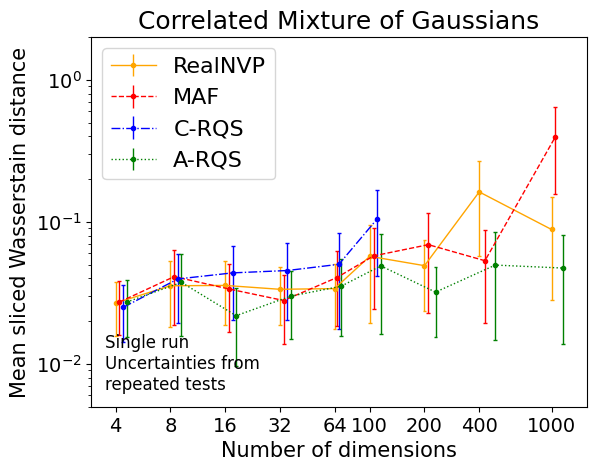

In [339]:
labels=False
jtplot.reset()
linewidth = 1
point_label_size = 8
point_marker = '.'#'go--'#'.'
fontsize_x=15
fontsize_y=15
fontsize_title=18
fontsize_legend=16
fontsize_ticks=14
spacing=20
[x,y,delta_y]=[RealNVPN_corr_WD[:,i] for i in [0,1,2]]
#plt.plot(x0,RealNVPN_corr_WD[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
plt.errorbar(x,y,delta_y, fmt=point_marker, label='RealNVP', color='orange', linestyle="-", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
[x,y,delta_y]=[MAFN_corr_WD[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*1/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='MAF', color='red', linestyle="--", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
[x,y,delta_y]=[CsplineN_corr_WD[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*2/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='C-RQS', color='blue', linestyle="-.", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
[x,y,delta_y]=[MsplineN_corr_WD[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*3/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='A-RQS', color='green', linestyle=":", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
if labels:
    for i in MsplineN_corr_WD:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='green')
    for i in CsplineN_corr_WD:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='blue')
    for i in MAFN_corr_WD:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='red')
    for i in RealNVPN_corr_WD:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of dimensions', fontsize=fontsize_x)
plt.ylabel('Mean sliced Wasserstain distance', fontsize=fontsize_y)
plt.ylim(0.005,2)
plt.title("Correlated Mixture of Gaussians", fontsize=fontsize_title)
plt.legend(fontsize=fontsize_legend)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    labelsize=fontsize_ticks) # labels along the bottom edge are off
plt.text(3.5, 0.01, 'Single run\nUncertainties from\nrepeated tests', fontsize=12, ha='left', va='center')
plt.xticks([4,8,16,32,64,100,200,400,1000], ['4','8','16','32','64','100','200','400','1000'],fontsize=fontsize_ticks)
plt.savefig(paper_fig_dir + 'Best_WD_median_corr_1.pdf')
plt.show()
plt.close()

In [340]:
MsplineN_corr_WD = extract_lines(df_bests_corr,"MsplineN","corr","swd_mean",replicas=True)
CsplineN_corr_WD = extract_lines(df_bests_corr,"CsplineN","corr","swd_mean",replicas=True)
MAFN_corr_WD = extract_lines(df_bests_corr,"MAFN","corr","swd_mean",replicas=True)
RealNVPN_corr_WD = extract_lines(df_bests_corr,"RealNVPN","corr","swd_mean",replicas=True)

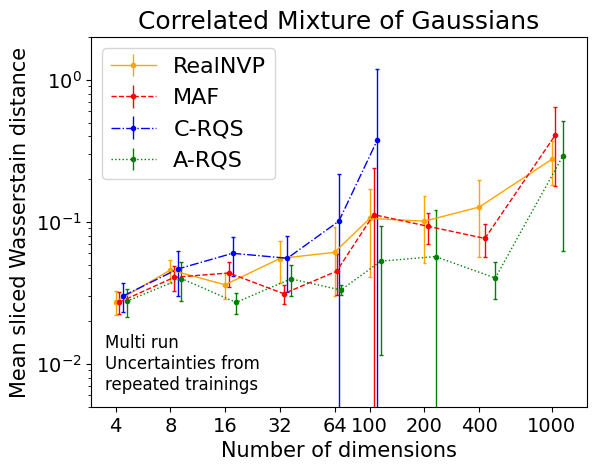

In [341]:
labels=False
jtplot.reset()
linewidth = 1
point_label_size = 8
point_marker = '.'#'go--'#'.'
fontsize_x=15
fontsize_y=15
fontsize_title=18
fontsize_legend=16
fontsize_ticks=14
spacing=20
[x,y,delta_y]=[RealNVPN_corr_WD[:,i] for i in [0,1,2]]
#plt.plot(x0,RealNVPN_corr_WD[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
plt.errorbar(x,y,delta_y, fmt=point_marker, label='RealNVP', color='orange', linestyle="-", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
[x,y,delta_y]=[MAFN_corr_WD[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*1/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='MAF', color='red', linestyle="--", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
[x,y,delta_y]=[CsplineN_corr_WD[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*2/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='C-RQS', color='blue', linestyle="-.", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
[x,y,delta_y]=[MsplineN_corr_WD[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*3/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='A-RQS', color='green', linestyle=":", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
if labels:
    for i in MsplineN_corr_WD:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='green')
    for i in CsplineN_corr_WD:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='blue')
    for i in MAFN_corr_WD:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='red')
    for i in RealNVPN_corr_WD:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of dimensions', fontsize=fontsize_x)
plt.ylabel('Mean sliced Wasserstain distance', fontsize=fontsize_y)
plt.ylim(0.005,2)
plt.title("Correlated Mixture of Gaussians", fontsize=fontsize_title)
plt.legend(fontsize=fontsize_legend)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    labelsize=fontsize_ticks) # labels along the bottom edge are off
plt.text(3.5, 0.01, 'Multi run\nUncertainties from\nrepeated trainings', fontsize=12, ha='left', va='center')
plt.xticks([4,8,16,32,64,100,200,400,1000], ['4','8','16','32','64','100','200','400','1000'],fontsize=fontsize_ticks)
plt.savefig(paper_fig_dir + 'Best_WD_median_corr_2.pdf')
plt.show()
plt.close()

### KS

In [342]:
MsplineN_corr_KS = extract_lines(df_bests_corr,"MsplineN","corr","ks_mean",replicas=False)
CsplineN_corr_KS = extract_lines(df_bests_corr,"CsplineN","corr","ks_mean",replicas=False)
MAFN_corr_KS = extract_lines(df_bests_corr,"MAFN","corr","ks_mean",replicas=False)
RealNVPN_corr_KS = extract_lines(df_bests_corr,"RealNVPN","corr","ks_mean",replicas=False)

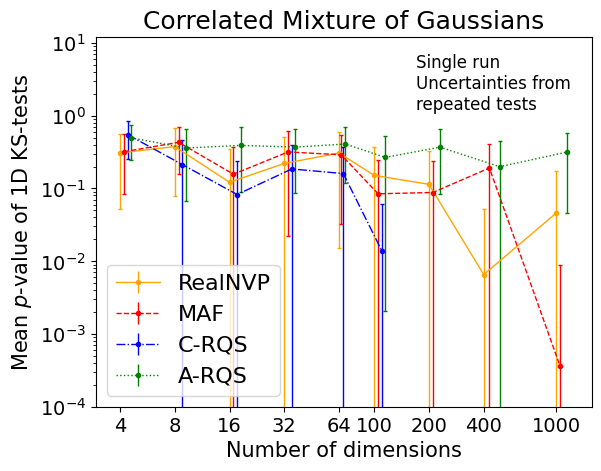

In [343]:
labels=False
jtplot.reset()
linewidth = 1
point_label_size = 8
point_marker = '.'#'go--'#'.'
fontsize_x=15
fontsize_y=15
fontsize_title=18
fontsize_legend=16
fontsize_ticks=14
spacing=20
[x,y,delta_y]=[RealNVPN_corr_KS[:,i] for i in [0,1,2]]
#plt.plot(x0,RealNVPN_corr_WD[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
plt.errorbar(x,y,delta_y, fmt=point_marker, label='RealNVP', color='orange', linestyle="-", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
[x,y,delta_y]=[MAFN_corr_KS[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*1/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='MAF', color='red', linestyle="--", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
[x,y,delta_y]=[CsplineN_corr_KS[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*2/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='C-RQS', color='blue', linestyle="-.", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
[x,y,delta_y]=[MsplineN_corr_KS[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*3/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='A-RQS', color='green', linestyle=":", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
if labels:
    for i in MsplineN_corr_KS:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='green')
    for i in CsplineN_corr_KS:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='blue')
    for i in MAFN_corr_KS:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='red')
    for i in RealNVPN_corr_KS:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of dimensions', fontsize=fontsize_x)
plt.ylabel('Mean $p$-value of 1D KS-tests', fontsize=fontsize_y)
plt.ylim(0.0001,12)
plt.title("Correlated Mixture of Gaussians", fontsize=fontsize_title)
plt.legend(fontsize=fontsize_legend,loc="lower left")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    labelsize=fontsize_ticks) # labels along the bottom edge are off
plt.text(170, 7, 'Single run\nUncertainties from\nrepeated tests', fontsize=12, ha='left', va='top')
plt.xticks([4,8,16,32,64,100,200,400,1000], ['4','8','16','32','64','100','200','400','1000'],fontsize=fontsize_ticks)
plt.savefig(paper_fig_dir + 'Best_KS_median_corr_1.pdf')
plt.show()
plt.close()

In [344]:
MsplineN_corr_KS = extract_lines(df_bests_corr,"MsplineN","corr","ks_mean",replicas=True)
CsplineN_corr_KS = extract_lines(df_bests_corr,"CsplineN","corr","ks_mean",replicas=True)
MAFN_corr_KS = extract_lines(df_bests_corr,"MAFN","corr","ks_mean",replicas=True)
RealNVPN_corr_KS = extract_lines(df_bests_corr,"RealNVPN","corr","ks_mean",replicas=True)

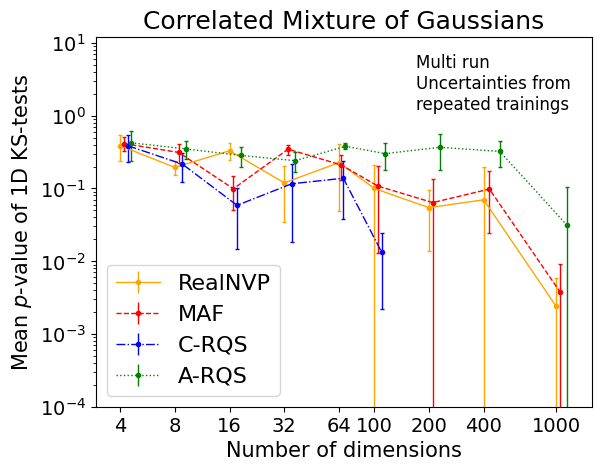

In [345]:
labels=False
jtplot.reset()
linewidth = 1
point_label_size = 8
point_marker = '.'#'go--'#'.'
fontsize_x=15
fontsize_y=15
fontsize_title=18
fontsize_legend=16
fontsize_ticks=14
spacing=20
[x,y,delta_y]=[RealNVPN_corr_KS[:,i] for i in [0,1,2]]
#plt.plot(x0,RealNVPN_corr_WD[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
plt.errorbar(x,y,delta_y, fmt=point_marker, label='RealNVP', color='orange', linestyle="-", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
[x,y,delta_y]=[MAFN_corr_KS[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*1/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='MAF', color='red', linestyle="--", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
[x,y,delta_y]=[CsplineN_corr_KS[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*2/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='C-RQS', color='blue', linestyle="-.", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
[x,y,delta_y]=[MsplineN_corr_KS[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*3/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='A-RQS', color='green', linestyle=":", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
if labels:
    for i in MsplineN_corr_KS:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='green')
    for i in CsplineN_corr_KS:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='blue')
    for i in MAFN_corr_KS:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='red')
    for i in RealNVPN_corr_KS:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of dimensions', fontsize=fontsize_x)
plt.ylabel('Mean $p$-value of 1D KS-tests', fontsize=fontsize_y)
plt.ylim(0.0001,12)
plt.title("Correlated Mixture of Gaussians", fontsize=fontsize_title)
plt.legend(fontsize=fontsize_legend,loc="lower left")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    labelsize=fontsize_ticks) # labels along the bottom edge are off
plt.text(170, 7, 'Multi run\nUncertainties from\nrepeated trainings', fontsize=12, ha='left', va='top')
plt.xticks([4,8,16,32,64,100,200,400,1000], ['4','8','16','32','64','100','200','400','1000'],fontsize=fontsize_ticks)
plt.savefig(paper_fig_dir + 'Best_KS_median_corr_2.pdf')
plt.show()
plt.close()

### Frobenius-norm

In [346]:
MsplineN_corr_FN = extract_lines(df_bests_corr,"MsplineN","corr","fn_mean",replicas=False)
CsplineN_corr_FN = extract_lines(df_bests_corr,"CsplineN","corr","fn_mean",replicas=False)
MAFN_corr_FN = extract_lines(df_bests_corr,"MAFN","corr","fn_mean",replicas=False)
RealNVPN_corr_FN = extract_lines(df_bests_corr,"RealNVPN","corr","fn_mean",replicas=False)

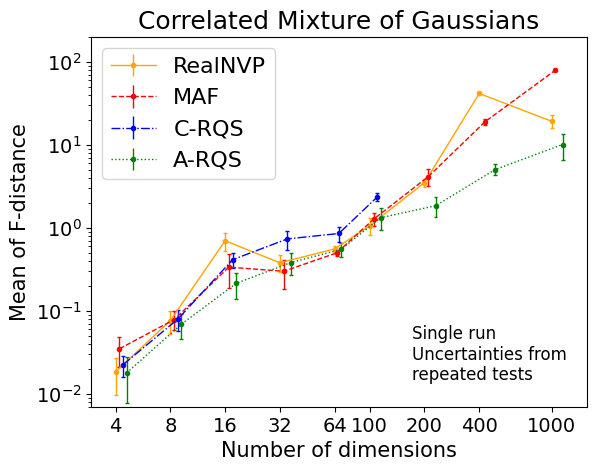

In [347]:
labels=False
jtplot.reset()
linewidth = 1
point_label_size = 8
point_marker = '.'#'go--'#'.'
fontsize_x=15
fontsize_y=15
fontsize_title=18
fontsize_legend=16
fontsize_ticks=14
spacing=20
[x,y,delta_y]=[RealNVPN_corr_FN[:,i] for i in [0,1,2]]
#plt.plot(x0,RealNVPN_corr_WD[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
plt.errorbar(x,y,delta_y, fmt=point_marker, label='RealNVP', color='orange', linestyle="-", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
[x,y,delta_y]=[MAFN_corr_FN[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*1/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='MAF', color='red', linestyle="--", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
[x,y,delta_y]=[CsplineN_corr_FN[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*2/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='C-RQS', color='blue', linestyle="-.", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
[x,y,delta_y]=[MsplineN_corr_FN[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*3/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='A-RQS', color='green', linestyle=":", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
if labels:
    for i in MsplineN_corr_FN:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='green')
    for i in CsplineN_corr_FN:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='blue')
    for i in MAFN_corr_FN:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='red')
    for i in RealNVPN_corr_FN:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of dimensions', fontsize=fontsize_x)
plt.ylabel('Mean of F-distance', fontsize=fontsize_y)
plt.ylim(0.007,200)
plt.title("Correlated Mixture of Gaussians", fontsize=fontsize_title)
plt.legend(fontsize=fontsize_legend,loc="upper left")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    labelsize=fontsize_ticks) # labels along the bottom edge are off
plt.text(170, 0.03, 'Single run\nUncertainties from\nrepeated tests', fontsize=12, ha='left', va='center')
plt.xticks([4,8,16,32,64,100,200,400,1000], ['4','8','16','32','64','100','200','400','1000'],fontsize=fontsize_ticks)
plt.savefig(paper_fig_dir + 'Best_FN_corr_1.pdf')
plt.show()
plt.close()

In [348]:
MsplineN_corr_FN = extract_lines(df_bests_corr,"MsplineN","corr","fn_mean",replicas=True)
CsplineN_corr_FN = extract_lines(df_bests_corr,"CsplineN","corr","fn_mean",replicas=True)
MAFN_corr_FN = extract_lines(df_bests_corr,"MAFN","corr","fn_mean",replicas=True)
RealNVPN_corr_FN = extract_lines(df_bests_corr,"RealNVPN","corr","fn_mean",replicas=True)

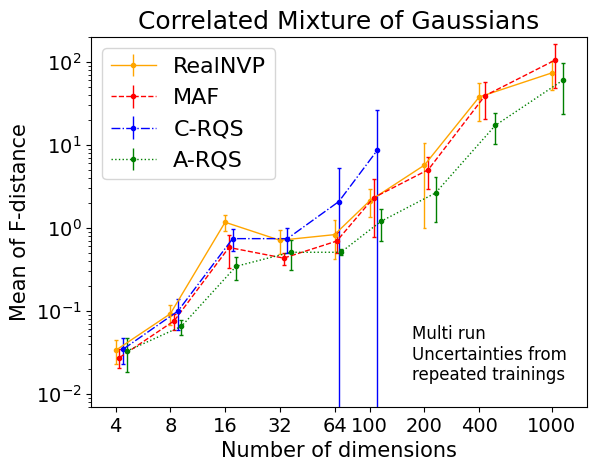

In [349]:
labels=False
jtplot.reset()
linewidth = 1
point_label_size = 8
point_marker = '.'#'go--'#'.'
fontsize_x=15
fontsize_y=15
fontsize_title=18
fontsize_legend=16
fontsize_ticks=14
spacing=20
[x,y,delta_y]=[RealNVPN_corr_FN[:,i] for i in [0,1,2]]
#plt.plot(x0,RealNVPN_corr_WD[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
plt.errorbar(x,y,delta_y, fmt=point_marker, label='RealNVP', color='orange', linestyle="-", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
[x,y,delta_y]=[MAFN_corr_FN[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*1/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='MAF', color='red', linestyle="--", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
[x,y,delta_y]=[CsplineN_corr_FN[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*2/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='C-RQS', color='blue', linestyle="-.", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
[x,y,delta_y]=[MsplineN_corr_FN[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*3/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='A-RQS', color='green', linestyle=":", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
if labels:
    for i in MsplineN_corr_FN:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='green')
    for i in CsplineN_corr_FN:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='blue')
    for i in MAFN_corr_FN:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='red')
    for i in RealNVPN_corr_FN:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of dimensions', fontsize=fontsize_x)
plt.ylabel('Mean of F-distance', fontsize=fontsize_y)
plt.ylim(0.007,200)
plt.title("Correlated Mixture of Gaussians", fontsize=fontsize_title)
plt.legend(fontsize=fontsize_legend,loc="upper left")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    labelsize=fontsize_ticks) # labels along the bottom edge are off
plt.text(170, 0.03, 'Multi run\nUncertainties from\nrepeated trainings', fontsize=12, ha='left', va='center')
plt.xticks([4,8,16,32,64,100,200,400,1000], ['4','8','16','32','64','100','200','400','1000'],fontsize=fontsize_ticks)
plt.savefig(paper_fig_dir + 'Best_FN_corr_2.pdf')
plt.show()
plt.close()

### Training time

In [350]:
MsplineN_corr_time = extract_lines(df_bests_corr,"MsplineN","corr","time",replicas=False).astype(np.float)
CsplineN_corr_time = extract_lines(df_bests_corr,"CsplineN","corr","time",replicas=False).astype(np.float)
MAFN_corr_time = extract_lines(df_bests_corr,"MAFN","corr","time",replicas=False).astype(np.float)
RealNVPN_corr_time = extract_lines(df_bests_corr,"RealNVPN","corr","time",replicas=False).astype(np.float)

/tmp/ipykernel_5630/1048348773.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  MsplineN_corr_time = extract_lines(df_bests_corr,"MsplineN","corr","time",replicas=False).astype(np.float)
/tmp/ipykernel_5630/1048348773.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  CsplineN_corr_time = extract_lines(df_bests_corr,"CsplineN","corr",

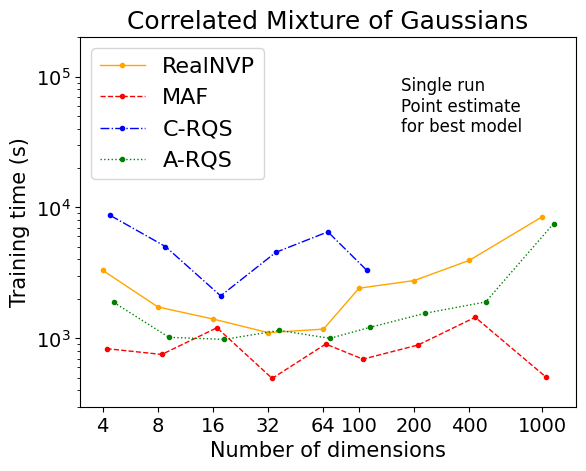

In [351]:
labels=False
jtplot.reset()
linewidth = 1
point_label_size = 8
point_marker = '.'#'go--'#'.'
fontsize_x=15
fontsize_y=15
fontsize_title=18
fontsize_legend=16
fontsize_ticks=14
spacing=20
[x,y]=[RealNVPN_corr_time[:,i] for i in [0,1]]
#plt.plot(x0,RealNVPN_corr_WD[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
plt.plot(x,y,point_marker, label='RealNVP', color='orange', linestyle="-", linewidth=linewidth)
#for i in range(len(x)):
#    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
#    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
[x,y]=[MAFN_corr_time[:,i] for i in [0,1]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*1/spacing
plt.plot(x,y,point_marker, label='MAF', color='red', linestyle="--", linewidth=linewidth)
#for i in range(len(x)):
#    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
#    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
[x,y]=[CsplineN_corr_time[:,i] for i in [0,1]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*2/spacing
plt.plot(x,y,point_marker, label='C-RQS', color='blue', linestyle="-.", linewidth=linewidth)
#for i in range(len(x)):
#    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
#    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
[x,y]=[MsplineN_corr_time[:,i] for i in [0,1]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*3/spacing
plt.plot(x,y,point_marker, label='A-RQS', color='green', linestyle=":", linewidth=linewidth)
#for i in range(len(x)):
#    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
#    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
if labels:
    for i in MsplineN_corr_time:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='green')
    for i in CsplineN_corr_time:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='blue')
    for i in MAFN_corr_time:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='red')
    for i in RealNVPN_corr_time:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of dimensions', fontsize=fontsize_x)
plt.ylabel('Training time (s)', fontsize=fontsize_y)
plt.ylim(300,200000)
plt.title("Correlated Mixture of Gaussians", fontsize=fontsize_title)
plt.legend(fontsize=fontsize_legend,loc="upper left")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    labelsize=fontsize_ticks) # labels along the bottom edge are off
plt.text(170, 100000, 'Single run\nPoint estimate\nfor best model', fontsize=12, ha='left', va='top')
plt.xticks([4,8,16,32,64,100,200,400,1000], ['4','8','16','32','64','100','200','400','1000'],fontsize=fontsize_ticks)
plt.savefig(paper_fig_dir + 'Best_training_time_corr_1.pdf')
plt.show()
plt.close()

In [352]:
MsplineN_corr_time = extract_lines(df_bests_corr,"MsplineN","corr","time",replicas=True).astype(np.float)
CsplineN_corr_time = extract_lines(df_bests_corr,"CsplineN","corr","time",replicas=True).astype(np.float)
MAFN_corr_time = extract_lines(df_bests_corr,"MAFN","corr","time",replicas=True).astype(np.float)
RealNVPN_corr_time = extract_lines(df_bests_corr,"RealNVPN","corr","time",replicas=True).astype(np.float)

/tmp/ipykernel_5630/2339656433.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  MsplineN_corr_time = extract_lines(df_bests_corr,"MsplineN","corr","time",replicas=True).astype(np.float)
/tmp/ipykernel_5630/2339656433.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  CsplineN_corr_time = extract_lines(df_bests_corr,"CsplineN","corr","

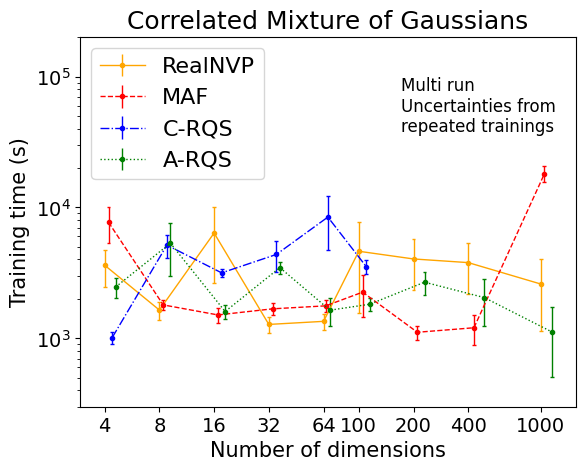

In [353]:
labels=False
jtplot.reset()
linewidth = 1
point_label_size = 8
point_marker = '.'#'go--'#'.'
fontsize_x=15
fontsize_y=15
fontsize_title=18
fontsize_legend=16
fontsize_ticks=14
spacing=20
[x,y,delta_y]=[RealNVPN_corr_time[:,i] for i in [0,1,2]]
#plt.plot(x0,RealNVPN_corr_WD[:,1],point_marker, color='orange', label='RealNVP', linestyle="-", linewidth=linewidth)
plt.errorbar(x,y,delta_y, fmt=point_marker, label='RealNVP', color='orange', linestyle="-", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='orange')
[x,y,delta_y]=[MAFN_corr_time[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*1/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='MAF', color='red', linestyle="--", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='red')
[x,y,delta_y]=[CsplineN_corr_time[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*2/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='C-RQS', color='blue', linestyle="-.", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='blue')
[x,y,delta_y]=[MsplineN_corr_time[:,i] for i in [0,1,2]]
x=x+np.append((x[1:]-x[:-1]),x[-1])*3/spacing
plt.errorbar(x,y,delta_y, fmt=point_marker, label='A-RQS', color='green', linestyle=":", linewidth=linewidth)
for i in range(len(x)):
    plt.hlines(y[i] + delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
    plt.hlines(y[i] - delta_y[i], x[i]-x[i]/spacing/2, x[i]+x[i]/spacing/2, linewidth=linewidth, color='green')
if labels:
    for i in MsplineN_corr_time:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='green')
    for i in CsplineN_corr_time:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='blue')
    for i in MAFN_corr_time:
        plt.text(i[0]*1.05,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='red')
    for i in RealNVPN_corr_time:
        plt.text(i[0]*0.85,i[1]*0.96, str(int(i[2])), fontsize=point_label_size, color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of dimensions', fontsize=fontsize_x)
plt.ylabel('Training time (s)', fontsize=fontsize_y)
plt.ylim(300,200000)
plt.title("Correlated Mixture of Gaussians", fontsize=fontsize_title)
plt.legend(fontsize=fontsize_legend,loc="upper left")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    labelsize=fontsize_ticks) # labels along the bottom edge are off
plt.text(170, 100000, 'Multi run\nUncertainties from\nrepeated trainings', fontsize=12, ha='left', va='top')
plt.xticks([4,8,16,32,64,100,200,400,1000], ['4','8','16','32','64','100','200','400','1000'],fontsize=fontsize_ticks)
plt.savefig(paper_fig_dir + 'Best_training_time_corr_2.pdf')
plt.show()
plt.close()

## Tables

In [561]:
df_bests_corr[0]

run_n  run_seed  ndims  nsamples correlation  nbijectors  bijector  \
0      1         0      4    100000        corr           2  MsplineN   
1      1         0      4    100000        corr           5  CsplineN   
2      4         0      4    100000        corr          10  RealNVPN   
3      2         0      4    100000        corr           5      MAFN   

  activation  knots  range_min  eps_regulariser regulariser   ks_mean  \
0       relu      8        -16                0        None  0.495217   
1       relu      8        -16                0        None  0.548395   
2       relu      8         -5                0        None  0.307817   
3       relu      8         -5                0        None  0.319240   

     ks_std   ad_mean    ad_std   wd_mean    wd_std  swd_mean   swd_std  \
0  0.251435  0.216209  0.066911  0.026842  0.012460  0.027267  0.011680   
1  0.297681  0.218421  0.064449  0.023984  0.010414  0.025026  0.010843   
2  0.255519  0.188032  0.080101  0.026637  0.008139  0.026858  0.011076   
3  0.235655  0.196969  0.076791  0.027648  0.011148  0.027307  0.011358   

    fn_mean    fn_std hidden_layers  batch_size  epochs_input  epochs_output  \
0  0.017926  0.010255   128-128-128         512          1000            360   
1  0.022538  0.006425   128-128-128         512          1000            310   
2  0.018490  0.008663   256-256-256         256          1000            337   
3  0.034974  0.014084   256-256-256         512          1000            361   

          time  
0  1878.589050  
1  8690.510488  
2  3307.465860  
3   833.398603

In [731]:
final_string=""
header = r"""\begin{tabular}{lrlrlllrr}
\toprule
\multicolumn{9}{c}{\bf Best Models for Correlated Mixture of Gaussians} \\
\midrule
hidden& \# of	&  algorithm 	&  spline 	& Sliced 		& KS-test	& Frobenius 	& \# of  	& training 	\\
layers & bijec. 	&  		&  knots 	& WD		 	& $p$-value	& Norm 	&	epochs	& time (s)  	\\
\midrule"""
for i in range(9):
    tmp=df_bests_corr[i]
    ndims=tmp["ndims"][0]
    #print("Dimensions:", ndims)
    tmp=tmp[tmp["correlation"]=="corr"]
    tmp=tmp[["hidden_layers","nbijectors","bijector","spline_knots","swd_mean","swd_std", "ks_mean","ks_std","fn_mean","fn_std","epochs_output","time"]]
    for k in ["swd_mean","ks_mean","fn_mean"]:
        #tmp[k]="$"+tmp[k].apply(lambda x: "{:.2e}".format(float(x)))+"\pm "+tmp[k.replace("mean","std")].apply(lambda x: "{:.2e}".format(float(x)))+"$"
        tmp[k]="$"+tmp[k].apply(lambda x: str(format_number(float(x))))+"\pm "+tmp[k.replace("mean","std")].apply(lambda x: str(format_number(float(x))))+"$"
        tmp.pop(k.replace("mean","std"))
    tmp["time"]=tmp["time"].apply(lambda x: int(float(x)))
    tmp.loc[tmp["bijector"]=="RealNVPN","spline_knots"]="--"
    tmp.loc[tmp["bijector"]=="MAFN","spline_knots"]="--"
    tmp.loc[tmp["bijector"]=="MAFN","bijector"]="MAF"
    tmp.loc[tmp["bijector"]=="RealNVPN","bijector"]="RealNVP"
    tmp.loc[tmp["bijector"]=="MsplineN","bijector"]="A-RQS "
    tmp.loc[tmp["bijector"]=="CsplineN","bijector"]="C-RQS"
    tmp['hidden_layers'] = tmp['hidden_layers'].str.replace(r'(\d+)-(\d+)-(\d+)', r'$3\times \1$', regex=True)
    string=tmp.to_latex(index=False).replace(r"\textbackslash ","\\").replace(r"\$","$")
    string=transform_string_1(string)
    string='\n'.join(string.splitlines()[3:-2])
    string=string.strip()
    string="\n"+r"\midrule"+"\n"+r"\multicolumn{9}{l}{\bf "+str(ndims)+r"D} \\"+"\n"+string
    final_string = final_string+string
final_string = final_string+"\n" +r"""\bottomrule
\end{tabular}"""
final_string = align_table_latex(final_string)
final_string = final_string.replace('\n\\midrule\n\\multicolumn{9}{l}{\\bf 4D}','\\multicolumn{9}{l}{\\bf 4D}')
final_string = header+"\n"+final_string
print(final_string)

\begin{tabular}{lrlrlllrr}
\toprule
\multicolumn{9}{c}{\bf Best models for CMoG} \\
\midrule
hidden& \# of	&  algorithm 	&  spline 	& Sliced 		& KS-test	& Frobenius 	& \# of  	& training 	\\
layers & bijec. 	&  		&  knots 	& WD		 	& $p$-value	& Norm 	&	epochs	& time (s)  	\\
\midrule
\multicolumn{9}{l}{\bf 4D} \\
\midrule
$3\times 128$ &           2 &   A-RQS  &            8 & $0.027\pm 0.012$ & $0.495\pm 0.251$    &  $0.018\pm 0.01$ &            360 &  1878 \\
$3\times 128$ &           5 &    C-RQS &            8 & $0.025\pm 0.011$ & $0.548\pm 0.298$    & $0.023\pm 0.006$ &            310 &  8690 \\
$3\times 256$ &          10 &  RealNVP &           -- & $0.027\pm 0.011$ & $0.308\pm 0.256$    & $0.018\pm 0.009$ &            337 &  3307 \\
$3\times 256$ &           5 &      MAF &           -- & $0.027\pm 0.011$ & $0.319\pm 0.236$    & $0.035\pm 0.014$ &            361 &   833 \\
\midrule
\multicolumn{9}{l}{\bf 8D} \\
\midrule
$3\times 128$ &           5 &      MAF &           -- & $0.0

/tmp/ipykernel_416/4097321329.py:27: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  string=tmp.to_latex(index=False).replace(r"\textbackslash ","\\").replace(r"\$","$")
/tmp/ipykernel_416/4097321329.py:27: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  string=tmp.to_latex(index=False).replace(r"\textbackslash ","\\").replace(r"\$","$")
/tmp/ipykernel_416/4097321329.py:27: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of 

In [659]:
final_string.replace("\n\\midrule\n\\multicolumn{9}{l}{\\bf 4D}",r"\multicolumn{9}{l}{\\bf 4D}")

'\\multicolumn{9}{l}{\\\\bf 4D} \\\\\n\\midrule\n$3\\times 128$ &           2 &   A-RQS  &            8 &  $(2.73\\pm 1.17)$e-02  &  $(4.95\\pm 2.51)$e-01  &  $(1.79\\pm 1.03)$e-02   &            360   &  1878 \\\\\n$3\\times 128$ &           5 &    C-RQS &            8 &  $(2.50\\pm 1.08)$e-02  &  $(5.48\\pm 2.98)$e-01  & $2.25e-02\\pm 6.42e-03$  &            310  &  8690 \\\\\n$3\\times 256$ &          10 &  RealNVP &           -- &  $(2.69\\pm 1.11)$e-02  &  $(3.08\\pm 2.56)$e-01  & $1.85e-02\\pm 8.66e-03$  &            337  &  3307 \\\\\n$3\\times 256$ &           5 &      MAF &           -- &  $(2.73\\pm 1.14)$e-02  &  $(3.19\\pm 2.36)$e-01  &  $(3.50\\pm 1.41)$e-02   &            361   &   833 \\\\\n\\bottomrule\n\\midrule\n\\multicolumn{9}{l}{\\bf 8D} \\\\\n\\midrule\n$3\\times 128$ &           5 &      MAF &           -- &  $(4.12\\pm 2.23)$e-02  &  $(4.30\\pm 2.74)$e-01  &  $(7.88\\pm 2.02)$e-02   &            327   &   752 \\\\\n$3\\times 128$ &           2 &   A-RQS  &      

In [12]:
import re

def transform_string(input_string):
    # Regular expression to find parts like '& $2.42e-02\pm 1.00e-02$'
    matches = re.findall(r"(& \$(\d+\.\d+)(e-\d+)\\pm (\d+\.\d+)(e-\d+)\$)", input_string)

    # If we found matches
    if matches:
        for match in matches:
            # Check if exponents are the same
            if match[2] == match[4]:
                # Now move e-XX at end after $
                new_format = "{} ${}\\pm {}${}".format(match[0].split('$')[0], match[1], match[3], match[2])
                # Replace the original match with the new format
                input_string = input_string.replace(match[0], new_format)
            
    return input_string

input_string = "& $2.42e-02\\pm 1.00e-02$"
print(transform_string(input_string))

&  $2.42\pm 1.00$e-02


In [9]:
import re

def transform_string(input_string):
    # Regular expression to find parts like '& $2.42e-02\pm 1.00e-02$'
    matches = re.findall(r"(& \$(\d+\.\d+)(e-\d+)\\pm (\d+\.\d+)(e-\d+)\$)", input_string)

    # If we found matches
    if matches:
        for match in matches:
            # Now move e-XX at end after $
            new_format = "{} ${}\\pm {}${}".format(match[0].split('$')[0], match[1], match[3], match[2])
            # Replace the original match with the new format
            input_string = input_string.replace(match[0], new_format)
            
    return input_string

input_string = "& $2.42e-02\\pm 1.00e-02$"
print(transform_string(input_string))

&  $2.42\pm 1.00$e-02


In [168]:
tmp.loc[df["bijector"]=="RealNVPN","spline_knots"]

1    --
8    --
Name: spline_knots, dtype: object

# Re-evaluate models

In [47]:
def recompute_metrics(run):
    print("Recomputing metrics for run",run.replace("results.txt",""),".")
    start_all=timer()
    tmp = pd.read_csv(run)
    X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
    np.shape(X_data_nf)
    run_n=int(tmp["run_n"])
    run_seed=int(tmp["run_seed"])
    ndims=int(tmp["ndims"])
    nsamples=int(tmp["nsamples"])
    correlation=str(tmp["correlation"][0])
    nbijectors=int(tmp["nbijectors"])
    bijector=str(tmp["bijector"][0])
    activation=str(tmp["activation"][0])
    spline_knots=int(tmp["spline_knots"])
    range_min=int(tmp["range_min"])
    eps_regulariser=tmp["eps_regulariser"][0]
    regulariser=tmp["regulariser"][0]
    hidden_layers=str(tmp["hidden_layers"][0])
    batch_size=int(tmp["batch_size"])
    epochs_input=int(tmp["epochs_input"])
    epochs_output=int(tmp["epochs_output"])
    time=tmp["time"][0]
    reset_random_seeds(0)
    ncomp=3
    ntest_samples=100000
    seed_dist = 0
    seed_test = 0
    targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy()
    start=timer()
    ks_mean,ks_std,ad_mean,ad_std,,wd_mean,wd_std,swd_mean,swd_std,fn_mean,fn_std=Metrics.ComputeMetrics(X_data_test,X_data_nf)
    results_dict = {'run_n': [run_n],
                    'run_seed': [run_seed],
                    'ndims':[ndims],
                    'nsamples':[nsamples],
                    'correlation':[correlation],
                    'nbijectors':[nbijectors],
                    'bijector':[bijector],
                    'activation':[activation],
                    'spline_knots':[spline_knots],
                    'range_min':[range_min],
                    'eps_regulariser':[eps_regulariser],
                    'regulariser':[regulariser],
                    'kl_divergence':[kl_divergence],
                    'ks_test_mean':[ks_mean],
                    'ks_test_median':[ks_median],
                    'ad_test_mean':[ad_mean],
                    'ad_test_median':[ad_median],
                    'Wasserstein_median':[w_distance_median],
                    'Wasserstein_mean':[w_distance_mean],
                    'sliced_Wasserstein_mean':[swd_mean],
                    'sliced_Wasserstein_std':[swd_std],
                    'frob_norm':[frob_norm],
                    'hidden_layers':[hidden_layers],
                    'batch_size':[batch_size],
                    'epochs_input':[epochs_input],
                    'epochs_output':[epochs_output],
                    'time':[time]}
    os.rename(run, run.replace(".txt","_old.txt"))
    Utils.results_current(run.replace("results.txt",""),results_dict)
    tmp_new = pd.read_csv(run)
    end=timer()
    print("Metrics for run",run.replace("results.txt",""),"computed and saved in",end-start,"s.")
    return tmp

In [48]:
run=list(correlated_unc_results_paths.values())[0]+"4D/run_5/results.txt"
pd.read_csv(run)
recompute_metrics(run)

Recomputing metrics for run ../CMoG/results/MAFN_best/4D/run_5/ .


/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:187: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([x_estimated[:,dim], batch_test[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:187: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([x_estimated[:,dim], batch_test[:,dim]])[2]


Metrics for run ../CMoG/results/MAFN_best/4D/run_5/ computed and saved in 1.2691607510000722 s.


run_n  run_seed  ndims  nsamples correlation  nbijectors bijector  \
0      5       520      4    100000        corr           5     MAFN   

  activation  spline_knots  range_min  ...  Wasserstein_median  \
0       relu             8         -5  ...            0.025781   

  Wasserstein_mean  sliced_Wasserstein_mean  sliced_Wasserstein_std  \
0         0.025781                 0.017306                0.001822   

   frob_norm  hidden_layers  batch_size  epochs_input  epochs_output  \
0   0.010386    128-128-128         512          1000            652   

          time  
0  7184.605105  

[1 rows x 27 columns]

In [105]:
tmp=
X_data_nf = np.load(list(correlated_unc_results_paths.values())[0]+"4D/run_5/nf_sample.npy")
np.shape(X_data_nf)
#arg_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
#X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy()

(100000, 4)

In [106]:
ndims=4
reset_random_seeds(0)

### Initialize number of components ###
def MixtureGaussian(ncomp,ndims,seed=0):
    targ_dist = MixtureDistributions.MixMultiNormal1(ncomp,ndims,seed=seed)
    return targ_dist
ntest_samples=100000
seed_dist = 0
seed_test = 0
targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy()
np.shape(X_data_test)
X_data_test[0]

array([4.2423981 , 7.12590057, 6.06101175, 9.83516205])

In [107]:
ks_mean,ks_std,ad_mean,ad_std,,wd_mean,wd_std,swd_mean,swd_std,fn_mean,fn_std=Metrics.ComputeMetrics(X_data_test,X_data_nf)
{'kl_divergence': kl_divergence,'ks_test_mean': ks_mean,'ks_test_median':ks_median,'ad_test_mean':ad_mean,'ad_test_median':ad_median,'Wasserstein_median':w_distance_median,'Wasserstein_mean':w_distance_mean,'frob_norm':frob_norm}

/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:187: UserWarning: p-value capped: true value larger than 0.25
  p_val=anderson_ksamp([x_estimated[:,dim], batch_test[:,dim]])[2]
/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/post-processing/../code/Metrics.py:187: UserWarning: p-value floored: true value smaller than 0.001
  p_val=anderson_ksamp([x_estimated[:,dim], batch_test[:,dim]])[2]


{'kl_divergence': -1,
 'ks_test_mean': 0.5001360132927927,
 'ks_test_median': 0.5071681592536929,
 'ad_test_mean': 0.20878356996181632,
 'ad_test_median': 0.21184494329967268,
 'Wasserstein_median': 0.02578086762691431,
 'Wasserstein_mean': 0.02578086762691431,
 'frob_norm': 0.010386194116092153}

# Bkp

## Re-evaluate metrics

In [101]:
from scipy.stats import wasserstein_distance
def Wasserstein_distance_old(target_test_data,nf_dist,norm=True):
    print("\nWasserstein_distance_old function")
    ##create data sample from trained normising flow
    #z=base_dist.sample((target_test_data.shape[0]))
    #x_estimated=nf_dist.bijector.forward(z).numpy()
    if norm==False:
        x_estimated=nf_dist.sample(target_test_data.shape[0])
        x_estimated=np.reshape(x_estimated,newshape=target_test_data.shape)
    else:
        x_estimated=nf_dist
    wasserstein_distances=[]
    for dim in range(target_test_data.shape[1]):
        #print(wasserstein_distance(x_target[:,dim], x_estimated[:,dim]))
        ws_distance=wasserstein_distance(target_test_data[:,dim], x_estimated[:,dim])
        wasserstein_distances.append(ws_distance)
    wd_mean = np.mean(wasserstein_distances)
    wd_std = np.std(wasserstein_distances)
    print(len(wasserstein_distances),"WD tests performed with",[len(target_test_data),len(x_estimated)],"dimensional samples.")
    print("WD Mean =",wd_mean)
    print("WD Std =",wd_std)
    #print("Samples =\n",wasserstein_distances)
    return [wd_mean,wd_std]

def sliced_Wasserstein_distance_old(target_test_data, nf_dist, norm=True, n_slices=None, seed=None):
    """
    Compute the sliced Wasserstein distance between two sets of points
    using n_slices random directions and the p-th Wasserstein distance.
    """
    print("\nsliced_Wasserstein_distance_old function")
    if seed is None:
        np.random.seed(np.random.randint(10e6))
    else:
        np.random.seed(int(seed))
    if n_slices is None:
        n_slices = target_test_data.shape[1]
    else:
        n_slices = int(n_slices)
    if norm==False:
        x_estimated=nf_dist.sample(target_test_data.shape[0])
        x_estimated=np.reshape(x_estimated,newshape=target_test_data.shape)
    else:
        x_estimated=nf_dist
    # Generate random directions
    directions = np.random.randn(n_slices, target_test_data.shape[1])
    directions /= np.linalg.norm(directions, axis=1)[:, None]
    # Compute sliced Wasserstein distance
    ws_distances = []
    for direction in directions:
        target_proj = target_test_data @ direction
        estimated_proj = x_estimated @ direction
        ws_distances.append(wasserstein_distance(target_proj, estimated_proj))
    swd_mean = np.mean(ws_distances)
    swd_std = np.std(ws_distances)
    print(len(ws_distances),"SWD tests performed with",[len(target_test_data),len(x_estimated)],"dimensional samples.")
    print("SWD Mean =",swd_mean)
    print("SWD Std =",swd_std)
    #print("Samples =\n",wasserstein_distances)
    return [swd_mean,swd_std]

def WD(dist_1,dist_2,n_iter=100,batch_size=100000):
    """
    The Wasserstein distance between the target distribution and the distribution of the test data.
    The test is performed for each dimension of the distributions and the mean and std of the p-values are returned. 
    _summary_

    Args:
        dist_1 (numpy array or distribution): The first distribution to be compared
        dist_2 (numpy array or distribution): The second distribution to be compared
        n_iter (int, optional): Number of iterations to be performed. Defaults to 100.
        batch_size (int, optional): Number of samples to be used in each iteration. Only used if num is true. Defaults to 100000.

    Returns:
        [float,float]: Mean and std of the p-values obtained from the KS tests
    """
    print("\nWD function")
    # If an array of the input is an array, then the input batch_size is ignored and batch_size is set to nsamples/n_iter
    if isinstance(dist_1, np.ndarray):
        ndims=dist_1.shape[1]
        nsamples=dist_1.shape[0]
        batch_size=int(nsamples/n_iter)
    elif isinstance(dist_2, np.ndarray):
        ndims=dist_2.shape[1]
        nsamples=dist_2.shape[0]
        batch_size=int(nsamples/n_iter)
    else:
        ndims=dist_1.sample(2).numpy().shape[1]
    # Define ad_list that will contain the list of wd for all dimensions and all iterations
    wd_list=[]
    # Loop over all iterations
    for k in range(n_iter):
        # If num is true, then the samples are split in n_iter batches of size nsamples/n_iter, otherwise we just sample batch_size points from the distributions
        if isinstance(dist_1, np.ndarray):
            dist_1_k=dist_1[k*batch_size:(k+1)*batch_size,:]
        elif isinstance(dist_1, tfd.distribution.Distribution):
            dist_1_k=dist_1.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        if isinstance(dist_2, np.ndarray):
            dist_2_k=dist_2[k*batch_size:(k+1)*batch_size,:]
        elif isinstance(dist_2, tfd.distribution.Distribution):
            dist_2_k=dist_2.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        # The WD test is computed and saved for each dimension
        for dim in range(ndims):
            wd=wasserstein_distance(dist_1_k[:,dim], dist_2_k[:,dim])
            wd_list.append(wd)
    #print(wd_list)
    # Compute the mean and std of the p-values
    wd_mean = np.mean(wd_list)
    wd_std = np.std(wd_list)
    print(len(wd_list),"WD tests performed with",[len(dist_1_k),len(dist_2_k)],"dimensional samples.")
    print("WD Mean =",wd_mean)
    print("WD Std =",wd_std)
    #print("Samples =\n",wd_list)
    # Return the mean and std of the p-values
    #return wd_list
    return [wd_mean,wd_std]

def SWD(dist_1,dist_2,n_iter=100,batch_size=100000,n_slices=100,seed=None):
    """
    Compute the sliced Wasserstein distance between two sets of points
    using n_slices random directions and the p-th Wasserstein distance.
    The test is performed for each dimension of the distributions and the mean and std of the p-values are returned. 
    _summary_

    Args:
        dist_1 (numpy array or distribution): The first distribution to be compared
        dist_2 (numpy array or distribution): The second distribution to be compared
        n_iter (int, optional): Number of iterations to be performed. Defaults to 100.
        batch_size (int, optional): Number of samples to be used in each iteration. Only used if num is true. Defaults to 100000.

    Returns:
        [float,float]: Mean and std of the p-values obtained from the KS tests
    """
    print("\nSWD function")
    # If an array of the input is an array, then the input batch_size is ignored and batch_size is set to nsamples/n_iter
    if isinstance(dist_1, np.ndarray):
        ndims=dist_1.shape[1]
        nsamples=dist_1.shape[0]
        batch_size=int(nsamples/n_iter)
    elif isinstance(dist_2, np.ndarray):
        ndims=dist_2.shape[1]
        nsamples=dist_2.shape[0]
        batch_size=int(nsamples/n_iter)
    else:
        ndims=dist_1.sample(2).numpy().shape[1]
    if seed is None:
        np.random.seed(np.random.randint(1000000))
    else:
        np.random.seed(int(seed))
    if n_slices is None:
        n_slices = np.max([100,ndims])
    else:
        n_slices = int(n_slices)
    # Define ad_list that will contain the list of swd for all dimensions and all iterations
    swd_list=[]
    # Loop over all iterations
    for k in range(n_iter):
        # If num is true, then the samples are split in n_iter batches of size nsamples/n_iter, otherwise we just sample batch_size points from the distributions
        if isinstance(dist_1, np.ndarray):
            dist_1_k=dist_1[k*batch_size:(k+1)*batch_size,:]
        elif isinstance(dist_1, tfd.distribution.Distribution):
            dist_1_k=dist_1.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        if isinstance(dist_2, np.ndarray):
            dist_2_k=dist_2[k*batch_size:(k+1)*batch_size,:]
        elif isinstance(dist_2, tfd.distribution.Distribution):
            dist_2_k=dist_2.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        # Generate random directions
        directions = np.random.randn(n_slices, ndims)
        directions /= np.linalg.norm(directions, axis=1)[:, None]
        # Compute sliced Wasserstein distance
        for direction in directions:
            dist_1_proj = dist_1_k @ direction
            dist_2_proj = dist_2_k @ direction
            swd_list.append(wasserstein_distance(dist_1_proj, dist_2_proj))
    # Compute the mean and std of the p-values
    swd_mean = np.mean(swd_list)
    swd_std = np.std(swd_list)
    print(len(swd_list),"WD tests performed with",[len(dist_1_k),len(dist_2_k)],"dimensional samples.")
    print("WD Mean =",swd_mean)
    print("WD Std =",swd_std)
    return [swd_mean,swd_std]
    
def WD_new(dist_1,dist_2,n_iter=100,batch_size=100000):
    """
    The Wasserstein distance between the target distribution and the distribution of the test data.
    The test is performed for each dimension of the distributions and the mean and std of the p-values are returned. 
    _summary_

    Args:
        dist_1 (numpy array or distribution): The first distribution to be compared
        dist_2 (numpy array or distribution): The second distribution to be compared
        n_iter (int, optional): Number of iterations to be performed. Defaults to 100.
        batch_size (int, optional): Number of samples to be used in each iteration. Only used if num is true. Defaults to 100000.

    Returns:
        [float,float]: Mean and std of the p-values obtained from the KS tests
    """
    print("\nWD_new function")
    # If an array of the input is an array, then the input batch_size is ignored and batch_size is set to nsamples/n_iter
    n_iter=int(np.ceil(np.sqrt(n_iter)))
    if isinstance(dist_1, np.ndarray):
        ndims=dist_1.shape[1]
        nsamples=dist_1.shape[0]
        batch_size=int(nsamples/n_iter)
    elif isinstance(dist_2, np.ndarray):
        ndims=dist_2.shape[1]
        nsamples=dist_2.shape[0]
        batch_size=int(nsamples/n_iter)
    else:
        ndims=dist_1.sample(2).numpy().shape[1]
    # Define ad_list that will contain the list of wd for all dimensions and all iterations
    wd_list=[]
    # Loop over all iterations
    for j in range(n_iter):
        # If num is true, then the samples are split in n_iter batches of size nsamples/n_iter, otherwise we just sample batch_size points from the distributions
        if isinstance(dist_1, np.ndarray):
            dist_1_j=dist_1[j*batch_size:(j+1)*batch_size,:]
        elif isinstance(dist_1, tfd.distribution.Distribution):
            dist_1_j=dist_1.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        for k in range(n_iter):
            if isinstance(dist_2, np.ndarray):
                dist_2_k=dist_2[k*batch_size:(k+1)*batch_size,:]
            elif isinstance(dist_2, tfd.distribution.Distribution):
                dist_2_k=dist_2.sample(batch_size).numpy()
            else:   
                raise ValueError("dist_1 must be either a numpy array or a distribution")
            # The WD test is computed and saved for each dimension
            for dim in range(ndims):
                wd=wasserstein_distance(dist_1_j[:,dim], dist_2_k[:,dim])
                wd_list.append(wd)
    #print(wd_list)
    # Compute the mean and std of the p-values
    wd_mean = np.mean(wd_list)
    wd_std = np.std(wd_list)
    print(len(wd_list),"WD tests performed with",[len(dist_1_j),len(dist_2_k)],"dimensional samples.")
    print("WD Mean =",wd_mean)
    print("WD Std =",wd_std)
    #print("Samples =\n",wd_list)
    # Return the mean and std of the p-values
    #return wd_list
    return [wd_mean,wd_std]

def SWD_new(dist_1,dist_2,n_iter=100,batch_size=100000,n_slices=100,seed=None):
    """
    Compute the sliced Wasserstein distance between two sets of points
    using n_slices random directions and the p-th Wasserstein distance.
    The test is performed for each dimension of the distributions and the mean and std of the p-values are returned. 
    _summary_

    Args:
        dist_1 (numpy array or distribution): The first distribution to be compared
        dist_2 (numpy array or distribution): The second distribution to be compared
        n_iter (int, optional): Number of iterations to be performed. Defaults to 100.
        batch_size (int, optional): Number of samples to be used in each iteration. Only used if num is true. Defaults to 100000.

    Returns:
        [float,float]: Mean and std of the p-values obtained from the KS tests
    """
    print("\nSWD_new function")
    # If an array of the input is an array, then the input batch_size is ignored and batch_size is set to nsamples/n_iter
    n_iter=int(np.ceil(np.sqrt(n_iter)))
    if isinstance(dist_1, np.ndarray):
        ndims=dist_1.shape[1]
        nsamples=dist_1.shape[0]
        batch_size=int(nsamples/n_iter)
    elif isinstance(dist_2, np.ndarray):
        ndims=dist_2.shape[1]
        nsamples=dist_2.shape[0]
        batch_size=int(nsamples/n_iter)
    else:
        ndims=dist_1.sample(2).numpy().shape[1]
    if seed is None:
        np.random.seed(np.random.randint(1000000))
    else:
        np.random.seed(int(seed))
    if n_slices is None:
        n_slices = np.max([100,ndims])
    else:
        n_slices = int(n_slices)
    # Define ad_list that will contain the list of swd for all dimensions and all iterations
    swd_list=[]
    # Loop over all iterations
    for j in range(n_iter):
        # If num is true, then the samples are split in n_iter batches of size nsamples/n_iter, otherwise we just sample batch_size points from the distributions
        if isinstance(dist_1, np.ndarray):
            dist_1_j=dist_1[j*batch_size:(j+1)*batch_size,:]
        elif isinstance(dist_1, tfd.distribution.Distribution):
            dist_1_j=dist_1.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        for k in range(n_iter):
            if isinstance(dist_2, np.ndarray):
                dist_2_k=dist_2[k*batch_size:(k+1)*batch_size,:]
            elif isinstance(dist_2, tfd.distribution.Distribution):
                dist_2_k=dist_2.sample(batch_size).numpy()
            else:   
                raise ValueError("dist_1 must be either a numpy array or a distribution")
            # Generate random directions
            directions = np.random.randn(n_slices, ndims)
            directions /= np.linalg.norm(directions, axis=1)[:, None]
            # Compute sliced Wasserstein distance
            for direction in directions:
                dist_1_proj = dist_1_j @ direction
                dist_2_proj = dist_2_k @ direction
                swd_list.append(wasserstein_distance(dist_1_proj, dist_2_proj))
    # Compute the mean and std of the p-values
    swd_mean = np.mean(swd_list)
    swd_std = np.std(swd_list)
    print(len(swd_list),"WD tests performed with",[len(dist_1_j),len(dist_2_k)],"dimensional samples.")
    print("WD Mean =",swd_mean)
    print("WD Std =",swd_std)
    return [swd_mean,swd_std]

In [53]:
from scipy import stats
def KS_test_1(dist_1,dist_2,n_iter=10,batch_size=100000):
    """
    The Kolmogorov-Smirnov test is a non-parametric test that compares two distributions and returns a p-value that indicates whether the two distributions are the same or not. 
    The test is performed for each dimension of the distributions and for n_iter times and the mean and std of the p-values are returned.
    In the case of numerical distributions, data are split in n_iter batches dist_1_j, dist_2_j of size batch_size=int(nsamples/n_iter) and the mean and std are computed over all pairs of batches dist_1_j, dist_2_j.
    Args:
        dist_1 (numpy array or distribution): The first distribution to be compared
        dist_2 (numpy array or distribution): The second distribution to be compared
        n_iter (int, optional): Number of iterations to be performed. Defaults to 10.
        batch_size (int, optional): Number of samples to be used in each iteration. Only used if num is true. Defaults to 100000.
    Returns:
        [float,float]: Mean and std of the p-values obtained from the KS tests
    """
    print("\nKS_test_1 function")
    # If an array of the input is an array, then the input batch_size is ignored and batch_size is set to nsamples/n_iter
    if isinstance(dist_1, np.ndarray):
        ndims=dist_1.shape[1]
        nsamples=dist_1.shape[0]
        batch_size=int(nsamples/n_iter)
    elif isinstance(dist_2, np.ndarray):
        ndims=dist_2.shape[1]
        nsamples=dist_2.shape[0]
        batch_size=int(nsamples/n_iter)
    else:
        ndims=dist_1.sample(2).numpy().shape[1]
    # Define ks_list that will contain the list of ks for all dimensions and all iterations
    ks_list=[]
    # Loop over all iterations
    for k in range(n_iter):
        # If num is true, then the samples are split in n_iter batches of size nsamples/n_iter, otherwise we just sample batch_size points from the distributions
        if isinstance(dist_1, np.ndarray):
            dist_1_k=dist_1[k*batch_size:(k+1)*batch_size,:]
        elif isinstance(dist_1, tfd.distribution.Distribution):
            dist_1_k=dist_1.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        if isinstance(dist_2, np.ndarray):
            dist_2_k=dist_2[k*batch_size:(k+1)*batch_size,:]
        elif isinstance(dist_2, tfd.distribution.Distribution):
            dist_2_k=dist_2.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        # The ks test is computed and the p-value saved for each dimension
        for dim in range(ndims):
            p_val=stats.ks_2samp(dist_1_k[:,dim], dist_2_k[:,dim])[1]
            ks_list.append(p_val)
    # Compute the mean and std of the p-values
    ks_mean = np.mean(ks_list)
    ks_std = np.std(ks_list)
    print(len(ks_list),"KS tests performed with",[len(dist_1_k),len(dist_2_k)],"dimensional samples.")
    print("KS Mean =",ks_mean)
    print("KS Std =",ks_std)
    # Return the mean and std of the p-values
    return [ks_mean,ks_std]


def KS_test_2(dist_1,dist_2,n_iter=100,batch_size=100000):
    """
    The Kolmogorov-Smirnov test is a non-parametric test that compares two distributions and returns a p-value that indicates whether the two distributions are the same or not. 
    The test is performed for each dimension of the distributions and for n_iter times and the mean and std of the p-values are returned.
    In the case of numerical distributions, data are split in np.ceil(np.sqrt(n_iter)) batches dist_1_j, dist_2_k of size batch_size=int(nsamples/np.ceil(np.sqrt(n_iter))) and the mean and std are computed over all pairs of batches dist_1_j, dist_2_k.
    Args:
        dist_1 (numpy array or distribution): The first distribution to be compared
        dist_2 (numpy array or distribution): The second distribution to be compared
        n_iter (int, optional): Number of iterations to be performed. Defaults to 100.
        batch_size (int, optional): Number of samples to be used in each iteration. Only used if num is true. Defaults to 100000.
    Returns:
        [float,float]: Mean and std of the p-values obtained from the KS tests
    """
    print("\nKS_test_2 function")
    # If an array of the input is an array, then the input batch_size is ignored and batch_size is set to nsamples/n_iter
    n_iter=int(np.ceil(np.sqrt(n_iter)))
    if isinstance(dist_1, np.ndarray):
        ndims=dist_1.shape[1]
        nsamples=dist_1.shape[0]
        batch_size=int(nsamples/n_iter)
    elif isinstance(dist_2, np.ndarray):
        ndims=dist_2.shape[1]
        nsamples=dist_2.shape[0]
        batch_size=int(nsamples/n_iter)
    else:
        ndims=dist_1.sample(2).numpy().shape[1]
    # Define ks_list that will contain the list of ks for all dimensions and all iterations
    ks_list=[]
    # Loop over all iterations
    for j in range(n_iter):
        # If num is true, then the samples are split in n_iter batches of size nsamples/n_iter, otherwise we just sample batch_size points from the distributions
        if isinstance(dist_1, np.ndarray):
            dist_1_j=dist_1[j*batch_size:(j+1)*batch_size,:]
        elif isinstance(dist_1, tfd.distribution.Distribution):
            dist_1_j=dist_1.sample(batch_size).numpy()
        else:   
            raise ValueError("dist_1 must be either a numpy array or a distribution")
        for k in range(n_iter):
            if isinstance(dist_2, np.ndarray):
                dist_2_k=dist_2[k*batch_size:(k+1)*batch_size,:]
            elif isinstance(dist_2, tfd.distribution.Distribution):
                dist_2_k=dist_2.sample(batch_size).numpy()
            else:   
                raise ValueError("dist_1 must be either a numpy array or a distribution")
            # The ks test is computed and the p-value saved for each dimension
            for dim in range(ndims):
                p_val=stats.ks_2samp(dist_1_j[:,dim], dist_2_k[:,dim])[1]
                ks_list.append(p_val)
    # Compute the mean and std of the p-values
    ks_mean = np.mean(ks_list)
    ks_std = np.std(ks_list)
    print(len(ks_list),"KS tests performed with",[len(dist_1_j),len(dist_2_k)],"dimensional samples.")
    print("KS Mean =",ks_mean)
    print("KS Std =",ks_std)
    # Return the mean and std of the p-values
    return [ks_mean,ks_std]


def KS_test_old(target_test_data,nf_dist,n_iter=100,norm=True):
    """Kolmogorov-Smirnov test between target distribution and trained normalising flow 
    Args:
        target_test_data (_type_): _description_
        nf_dist (_type_): _description_
        n_iter (int, optional): _description_. Defaults to 100.
        norm (bool, optional): _description_. Defaults to True.
    Returns:
        _type_: _description_
    """
    print("\nKS_test_old function")
    ndims=target_test_data.shape[1]
    nsamples=target_test_data.shape[0]
    batch_size=int(nsamples/n_iter)
    ###### Now we compute ks test between two different dists and print out the norm
    big_list=[]
    for dim in range(ndims):
        dim_list=[]
        big_list.append(dim_list)
    for k in range(n_iter):
        ## create new sample from target distribution
        batch_test=target_test_data[k*batch_size:(k+1)*batch_size,:]
        ##create data sample from trained normising flow
        #z=base_dist.sample((nsamples))
        #x_estimated=nf_dist.bijector.forward(z).numpy()
        if norm==False:
            x_estimated=nf_dist.sample(batch_test.shape[0])
            x_estimated=np.reshape(x_estimated,newshape=batch_test.shape)
        else:
            x_estimated=nf_dist[k*batch_size:(k+1)*batch_size,:]
        for dim in range(ndims):
            p_val=stats.ks_2samp(x_estimated[:,dim], batch_test[:,dim])[1]
            big_list[dim].append(p_val)
    ks_test_all=[]
    for dim in range(ndims):
        print(big_list[dim])
        ks_test_dim=float(np.mean(big_list[dim]))
        ks_test_all.append(ks_test_dim)
    ks_mean = np.mean(ks_test_all)
    ks_std = np.std(ks_test_all)
    print(len(ks_test_all),"KS tests performed with",[len(x_estimated),len(batch_test)],"dimensional samples.")
    print("KS Mean =",ks_mean)
    print("KS Std =",ks_std)
    # Return the mean and std of the p-values
    return [ks_mean,ks_std]

In [60]:
start=timer()
run_number=1
run="/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_"+str(run_number)+"/results.txt"
tmp = pd.read_csv(run)
X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
np.shape(X_data_nf)
run_n=int(tmp["run_n"])
run_seed=int(tmp["run_seed"])
ndims=int(tmp["ndims"])
print("Ndims =",ndims)
nsamples=int(tmp["nsamples"])
correlation=str(tmp["correlation"][0])
nbijectors=int(tmp["nbijectors"])
bijector=str(tmp["bijector"][0])
activation=str(tmp["activation"][0])
spline_knots=int(tmp["spline_knots"])
range_min=int(tmp["range_min"])
eps_regulariser=tmp["eps_regulariser"][0]
regulariser=tmp["regulariser"][0]
hidden_layers=str(tmp["hidden_layers"][0])
batch_size=int(tmp["batch_size"])
epochs_input=int(tmp["epochs_input"])
epochs_output=int(tmp["epochs_output"])
time=tmp["time"][0]
ncomp=3
ntest_samples=100000
seed_dist = 0
seed_test = 0
targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
n_iter=10
X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
res_1_KS=KS_test_1(X_data_test,X_data_nf,n_iter=10)
print(res_1_KS)
#res_1_WD=Wasserstein_distance_old(X_data_test,X_data_nf)
#res_1_SWD=sliced_Wasserstein_distance_old(X_data_test,X_data_nf)
#print("\nMean =",np.mean(res_1))
#print("Std =",np.std(res_1))
#print("Samples =\n",res_1)
res_2_KS=KS_test_2(X_data_test,X_data_nf)
print(res_2_KS)
#res_2_WD=WD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
#res_2_SWD=SWD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
#print("\nMean =",np.mean(res_2))
#print("Std =",np.std(res_2))
#print("Samples =\n",res_2)
res_3_KS=KS_test_old(X_data_test,X_data_nf)
print(res_3_KS)
#res_3_WD=WD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
#res_3_SWD=SWD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
#print("\nMean =",np.mean(res_2))
#print("Std =",np.std(res_2))
#print("Samples =\n",res_2)
end=timer()
print("Done in",end-start,"s.")

Ndims = 4

KS_test_1 function
40 KS tests performed with [10000, 10000] dimensional samples.
KS Mean = 0.21122413585637786
KS Std = 0.2539179980226731
[0.21122413585637786, 0.2539179980226731]

KS_test_2 function
400 KS tests performed with [10000, 10000] dimensional samples.
KS Mean = 0.21122413585637786
KS Std = 0.2539179980226731
[0.21122413585637786, 0.2539179980226731]

KS_test_old function
[0.9802627322900355, 0.6101664688189142, 0.12051526066065596, 0.5005673707894058, 0.647814872077161, 0.5728904395829821, 0.09710349657052789, 0.4659595288557257, 0.19957365535779528, 0.6854967337920594, 0.12051526066065596, 0.37012017606173, 0.9690010280430694, 0.1082872208757189, 0.9883339509983219, 0.06153429181321559, 0.7228251828701066, 0.5362766985932181, 0.005306868855560685, 0.014870029418858987, 0.34112475112661245, 0.21939649929677082, 0.7946637387576738, 0.4006338815832625, 0.5728904395829821, 0.008353146175741297, 0.04839715079181246, 0.21939649929677082, 0.03776014017220749, 0.61016

In [104]:
start=timer()
run_number=9
run="/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_"+str(run_number)+"/results.txt"
tmp = pd.read_csv(run)
X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
np.shape(X_data_nf)
run_n=int(tmp["run_n"])
run_seed=int(tmp["run_seed"])
ndims=int(tmp["ndims"])
print("Ndims =",ndims)
nsamples=int(tmp["nsamples"])
correlation=str(tmp["correlation"][0])
nbijectors=int(tmp["nbijectors"])
bijector=str(tmp["bijector"][0])
activation=str(tmp["activation"][0])
spline_knots=int(tmp["spline_knots"])
range_min=int(tmp["range_min"])
eps_regulariser=tmp["eps_regulariser"][0]
regulariser=tmp["regulariser"][0]
hidden_layers=str(tmp["hidden_layers"][0])
batch_size=int(tmp["batch_size"])
epochs_input=int(tmp["epochs_input"])
epochs_output=int(tmp["epochs_output"])
time=tmp["time"][0]
ncomp=3
ntest_samples=100000
seed_dist = 0
seed_test = 0
targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
n_iter=100
X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy().astype("float32")

res_1_WD=Wasserstein_distance_old(X_data_test,X_data_nf)
res_1_SWD=sliced_Wasserstein_distance_old(X_data_test,X_data_nf)

res_2_WD=WD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
res_2_SWD=SWD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)

res_3_WD=WD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
res_3_SWD=SWD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)

end=timer()
print("Done in",end-start,"s.")

Ndims = 16

Wasserstein_distance_old function
16 WD tests performed with [100000, 100000] dimensional samples.
WD Mean = 0.03373500612157289
WD Std = 0.020203493432553742

sliced_Wasserstein_distance_old function
16 SWD tests performed with [100000, 100000] dimensional samples.
SWD Mean = 0.03807984620331259
SWD Std = 0.01555921475824211

WD function
1600 WD tests performed with [1000, 1000] dimensional samples.
WD Mean = 0.06871675304284244
WD Std = 0.05109879416747633

SWD function
10000 WD tests performed with [1000, 1000] dimensional samples.
WD Mean = 0.0755253201607247
WD Std = 0.04681886827398734

WD_new function
1600 WD tests performed with [10000, 10000] dimensional samples.
WD Mean = 0.03671606686621906
WD Std = 0.024448967631089943

SWD_new function
10000 WD tests performed with [10000, 10000] dimensional samples.
WD Mean = 0.03922254648166329
WD Std = 0.020919553847710236
Done in 124.16610923800908 s.


In [106]:
start=timer()
run_number=9
run="/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_"+str(run_number)+"/results.txt"
tmp = pd.read_csv(run)
X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
np.shape(X_data_nf)
run_n=int(tmp["run_n"])
run_seed=int(tmp["run_seed"])
ndims=int(tmp["ndims"])
print("Ndims =",ndims)
nsamples=int(tmp["nsamples"])
correlation=str(tmp["correlation"][0])
nbijectors=int(tmp["nbijectors"])
bijector=str(tmp["bijector"][0])
activation=str(tmp["activation"][0])
spline_knots=int(tmp["spline_knots"])
range_min=int(tmp["range_min"])
eps_regulariser=tmp["eps_regulariser"][0]
regulariser=tmp["regulariser"][0]
hidden_layers=str(tmp["hidden_layers"][0])
batch_size=int(tmp["batch_size"])
epochs_input=int(tmp["epochs_input"])
epochs_output=int(tmp["epochs_output"])
time=tmp["time"][0]
ncomp=3
ntest_samples=100000
seed_dist = 0
seed_test = 0
targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
n_iter=10
X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy().astype("float32")

res_1_WD=Wasserstein_distance_old(X_data_test,X_data_nf)
res_1_SWD=sliced_Wasserstein_distance_old(X_data_test,X_data_nf)

res_2_WD=WD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
res_2_SWD=SWD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)

res_3_WD=WD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
res_3_SWD=SWD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)

end=timer()
print("Done in",end-start,"s.")

Ndims = 16

Wasserstein_distance_old function
16 WD tests performed with [100000, 100000] dimensional samples.
WD Mean = 0.03373500612157289
WD Std = 0.020203493432553742

sliced_Wasserstein_distance_old function
16 SWD tests performed with [100000, 100000] dimensional samples.
SWD Mean = 0.03807984620331259
SWD Std = 0.01555921475824211

WD function
160 WD tests performed with [10000, 10000] dimensional samples.
WD Mean = 0.03671606686621905
WD Std = 0.024448967631089943

SWD function
1000 WD tests performed with [10000, 10000] dimensional samples.
WD Mean = 0.0390375798340183
WD Std = 0.020759058955144655

WD_new function
256 WD tests performed with [25000, 25000] dimensional samples.
WD Mean = 0.03510304074570403
WD Std = 0.024569943344250545

SWD_new function
1600 WD tests performed with [25000, 25000] dimensional samples.
WD Mean = 0.03734863271674013
WD Std = 0.020646115816772684
Done in 59.059644709006534 s.


In [105]:
start=timer()
run_number=21
run="/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_"+str(run_number)+"/results.txt"
tmp = pd.read_csv(run)
X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
np.shape(X_data_nf)
run_n=int(tmp["run_n"])
run_seed=int(tmp["run_seed"])
ndims=int(tmp["ndims"])
print("Ndims =",ndims)
nsamples=int(tmp["nsamples"])
correlation=str(tmp["correlation"][0])
nbijectors=int(tmp["nbijectors"])
bijector=str(tmp["bijector"][0])
activation=str(tmp["activation"][0])
spline_knots=int(tmp["spline_knots"])
range_min=int(tmp["range_min"])
eps_regulariser=tmp["eps_regulariser"][0]
regulariser=tmp["regulariser"][0]
hidden_layers=str(tmp["hidden_layers"][0])
batch_size=int(tmp["batch_size"])
epochs_input=int(tmp["epochs_input"])
epochs_output=int(tmp["epochs_output"])
time=tmp["time"][0]
ncomp=3
ntest_samples=100000
seed_dist = 0
seed_test = 0
targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
n_iter=100
X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy().astype("float32")

res_1_WD=Wasserstein_distance_old(X_data_test,X_data_nf)
res_1_SWD=sliced_Wasserstein_distance_old(X_data_test,X_data_nf)

res_2_WD=WD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
res_2_SWD=SWD(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)

res_3_WD=WD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)
res_3_SWD=SWD_new(X_data_test,X_data_nf,n_iter=n_iter,batch_size=batch_size)

end=timer()
print("Done in",end-start,"s.")

Ndims = 100

Wasserstein_distance_old function
100 WD tests performed with [100000, 100000] dimensional samples.
WD Mean = 0.12023903130116201
WD Std = 0.061544315592497505

sliced_Wasserstein_distance_old function
100 SWD tests performed with [100000, 100000] dimensional samples.
SWD Mean = 0.11960075962144863
SWD Std = 0.07316267405525886

WD function
10000 WD tests performed with [1000, 1000] dimensional samples.
WD Mean = 0.14771710188628637
WD Std = 0.10798763503639176

SWD function
10000 WD tests performed with [1000, 1000] dimensional samples.
WD Mean = 0.14280971260927397
WD Std = 0.11204016134380657

WD_new function
10000 WD tests performed with [10000, 10000] dimensional samples.
WD Mean = 0.12117306563900083
WD Std = 0.06593168162435659

SWD_new function
10000 WD tests performed with [10000, 10000] dimensional samples.
WD Mean = 0.11388370431228448
WD Std = 0.07391762004393752
Done in 210.4752859250002 s.


In [102]:
start=timer()
ndims=4
ncomp=3
ntest_samples=10000
seed_dist_1 = 0
seed_dist_2 = 1
seed_test_1 = 0
seed_test_2 = 1
n_iter=1000
batch_size=10000
targ_dist_1=MixtureGaussian1(ncomp,ndims,seed=seed_dist_1)
targ_dist_2=MixtureGaussian2(ncomp,ndims,seed=seed_dist_1)
X_data_test_1=targ_dist_1.sample(ntest_samples,seed=seed_test_1).numpy()
X_data_test_2=targ_dist_2.sample(ntest_samples,seed=seed_test_2).numpy()
print(KS_test(X_data_test_1,X_data_test_2,n_iter=n_iter,batch_size=batch_size))
#print(KS_test(targ_dist_1,X_data_test_2,n_iter=n_iter,batch_size=batch_size))
#print(KS_test(X_data_test_1,targ_dist_2,n_iter=n_iter,batch_size=batch_size))
print(KS_test(targ_dist_1,targ_dist_2,n_iter=n_iter,batch_size=batch_size))
end=timer()
print("Done in",end-start,"s.")

Computing KS for samples with lengths: 10
4000
[0.603388352746325, 0.31103815579226224]
Computing KS for samples with lengths: 10000
4000
[0.18471494566976424, 0.239360746698701]
Done in 105.119051691001 s.


In [18]:
res={}
for run_number in [1]:
#for run_number in [13,14,15,16]:
    run="/mnt/c/Users/rtorre/Dropbox/Work/04_Projects/Git/GitHub/NormalizingFlows/NF4HEP/NormalizingFlowsHD/CMoG/results/MAFN/run_"+str(run_number)+"/results.txt"
    tmp = pd.read_csv(run)
    X_data_nf = np.load(run.replace("results.txt","nf_sample.npy"))
    np.shape(X_data_nf)
    run_n=int(tmp["run_n"])
    run_seed=int(tmp["run_seed"])
    ndims=int(tmp["ndims"])
    nsamples=int(tmp["nsamples"])
    correlation=str(tmp["correlation"][0])
    nbijectors=int(tmp["nbijectors"])
    bijector=str(tmp["bijector"][0])
    activation=str(tmp["activation"][0])
    spline_knots=int(tmp["spline_knots"])
    range_min=int(tmp["range_min"])
    eps_regulariser=tmp["eps_regulariser"][0]
    regulariser=tmp["regulariser"][0]
    hidden_layers=str(tmp["hidden_layers"][0])
    batch_size=int(tmp["batch_size"])
    epochs_input=int(tmp["epochs_input"])
    epochs_output=int(tmp["epochs_output"])
    time=tmp["time"][0]
    ncomp=3
    ntest_samples=100000
    seed_dist = 0
    seed_test = 0
    targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    #targ_dist_1=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    #targ_dist_2=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    X_data_test=targ_dist.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    #X_data_test_1=targ_dist_1.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    #X_data_test_2=targ_dist_2.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    
    #for seed in np.random.randint(0,1000000,20):
    #    X_data_test_1=targ_dist_1.sample(ntest_samples,seed=int(seed)).numpy().astype("float32")
    #    FN_n,_,_=Metrics.FrobNorm(X_data_test_1,X_data_nf)
    #    FN.append(FN_n)
    FN_val = FN(X_data_test,X_data_nf)
    SWD_val = Metrics.SWD(X_data_test,X_data_nf,n_slices=10,seed=np.random.randint(1000000))
    #for n in [10]:
    #    for seed in np.random.randint(0,1000000,10):     
    #        res_n = Metrics.sliced_Wasserstein_distance(X_data_test,X_data_nf,n_slices=n,seed=seed)
    #        #res_n = Metrics.sliced_Wasserstein_distance(X_data_test_1,X_data_test_2,n_slices=n,seed=seed)
    #        res.append(res_n)
    #        print(res_n)
    res[run_number]={"SWD":SWD,"FN":FN}
    print(res[run_number])

ValueError: operands could not be broadcast together with shapes (1000,4) (4,4) 

In [290]:
SWD_list = []
for nsamples in [10000,100000,1000000]:
    ndims=4
    ncomp=3
    ntest_samples=nsamples
    seed_dist = 0
    seed_test = 0
    targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    targ_dist_1=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    targ_dist_2=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    X_data_test_1=targ_dist_1.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    X_data_test_2=targ_dist_2.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    SWD = Metrics.sliced_Wasserstein_distance(X_data_test_1,X_data_test_2,n_slices=100,seed=np.random.randint(1000000))
    SWD_list.append([nsamples,SWD])
    print([nsamples,SWD])

[10000, [0.03242777552842393, 0.01778819546447554]]
[100000, [0.011425536151111464, 0.004952796941549029]]
[1000000, [0.0022367948656308117, 0.0007193789769005433]]


In [291]:
SWD_list = []
for nsamples in [10000,100000,1000000]:
    ndims=4
    ncomp=3
    ntest_samples=nsamples
    seed_dist = 0
    seed_test = 0
    targ_dist=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    targ_dist_1=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    targ_dist_2=MixtureGaussian(ncomp,ndims,seed=seed_dist)
    X_data_test_1=targ_dist_1.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    X_data_test_2=targ_dist_2.sample(ntest_samples,seed=seed_test).numpy().astype("float32")
    SWD = Metrics.sliced_Wasserstein_distance(X_data_test_1,X_data_test_2,n_slices=1000,seed=np.random.randint(1000000))
    SWD_list.append([nsamples,SWD])
    print([nsamples,SWD])

[10000, [0.03468181361910674, 0.017766327001419276]]
[100000, [0.011701384946107625, 0.0052862062353391135]]
[1000000, [0.0022781766000493694, 0.0007203478363419516]]


ValueError: x and y must have same first dimension, but have shapes (3,) and (10,)

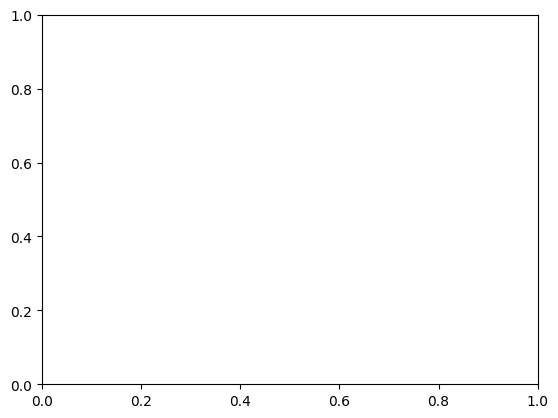

In [223]:
plt.figure(2)
plt.plot([10,100,1000], res[:,0], label="SWD")
plt.fill_between([10,100,1000], res[:,0] - 2 * res[:,1], res[:,0] + 2 * res[:,1], alpha=0.5)

plt.legend()
plt.xscale('log')

plt.xlabel("Number of projections")
plt.ylabel("Distance")
plt.title('Sliced Wasserstein Distance with 95% confidence inverval')

plt.show()

## Other

In [151]:
# Set random seed for reproducibility
np.random.seed(42)

# Define mean and covariance matrices
mean1 = np.random.randn(1000)
cov1 = np.random.randn(1000,1000)
mean2 = np.random.randn(1000)
cov2 = np.random.randn(1000,1000)

# Generate two MVN random samples with same mean and covariance
n_samples = 100000
sample1 = np.random.multivariate_normal(mean1, cov1, size=n_samples)
sample2 = np.random.multivariate_normal(mean2, cov2, size=n_samples)

/tmp/ipykernel_10662/2417459388.py:12: RuntimeWarning: covariance is not positive-semidefinite.
  sample1 = np.random.multivariate_normal(mean1, cov1, size=n_samples)
/tmp/ipykernel_10662/2417459388.py:13: RuntimeWarning: covariance is not positive-semidefinite.
  sample2 = np.random.multivariate_normal(mean2, cov2, size=n_samples)


In [152]:
from scipy.stats import wasserstein_distance
from timeit import default_timer as timer

In [155]:
start=timer()
res = np.mean([wasserstein_distance(sample1[:,0],sample2[:,0]),wasserstein_distance(sample1[:,1],sample2[:,1])])
end=timer()
print(res)
print("SWD computed in",end-start,"s.")

0.3611000457556382
SWD computed in 0.11974661500426009 s.


In [156]:
n_slices=[10,20,30,50,100]
means=[]
stds=[]
for i in n_slices:
    print("Computing SWD for",i,"slices")
    start=timer()
    swd=[sliced_Wasserstein_distance(sample1, sample2, norm=True, n_slices=i, p=1, seed=None) for k in range(10)]
    means.append(np.mean(swd))
    stds.append(np.std(swd))
    end=timer()
    print("SWD for",i,"slices computed in",end-start,"s.")

Computing SWD for 10 slices
SWD for 10 slices computed in 13.37087254099606 s.
Computing SWD for 20 slices
SWD for 20 slices computed in 28.011276363991783 s.
Computing SWD for 30 slices
SWD for 30 slices computed in 42.616360687999986 s.
Computing SWD for 50 slices
SWD for 50 slices computed in 69.60400968199247 s.
Computing SWD for 100 slices
SWD for 100 slices computed in 135.5928650309943 s.


In [157]:
means

[1.1240666444239884,
 1.178620028730426,
 1.0345398202687348,
 1.0856285500872462,
 1.1349826566549233]

In [158]:
stds

[0.2821306524675983,
 0.24819902027034105,
 0.13102079479750936,
 0.13262808573039866,
 0.10346581086159876]